In [ ]:
import os
import pickle
import random
import time

import PIL
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from keras import Input, Model
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.layers import Dense, LeakyReLU, BatchNormalization, ReLU, Reshape, UpSampling2D, Conv2D, Activation, \
    concatenate, Flatten, Lambda, Concatenate
from keras.optimizers import Adam
from matplotlib import pyplot as plt

In [ ]:
def load_class_ids(class_info_file_path):
    """
    Load class ids from class_info.pickle file
    """
    with open(class_info_file_path, 'rb') as f:
        class_ids = pickle.load(f, encoding='latin1')
        return class_ids
      
def load_embeddings(embeddings_file_path):
    """
    Load embeddings
    """
    with open(embeddings_file_path, 'rb') as f:
        embeddings = pickle.load(f, encoding='latin1')
        embeddings = np.array(embeddings)
        print('embeddings: ', embeddings.shape)
    return embeddings
 
def load_filenames(filenames_file_path):
    """
    Load filenames.pickle file and return a list of all file names
    """
    with open(filenames_file_path, 'rb') as f:
        filenames = pickle.load(f, encoding='latin1')
    return filenames
 
def load_bounding_boxes(dataset_dir):
    """
    Load bounding boxes and return a dictionary of file names and corresponding bounding boxes
    """
    # Paths
    bounding_boxes_path = os.path.join(dataset_dir, 'bounding_boxes.txt')
    file_paths_path = os.path.join(dataset_dir, 'images.txt')

    # Read bounding_boxes.txt and images.txt file
    df_bounding_boxes = pd.read_csv(bounding_boxes_path,
                                    delim_whitespace=True, header=None).astype(int)
    df_file_names = pd.read_csv(file_paths_path, delim_whitespace=True, header=None)

    # Create a list of file names
    file_names = df_file_names[1].tolist()

    # Create a dictionary of file_names and bounding boxes
    filename_boundingbox_dict = {img_file[:-4]: [] for img_file in file_names[:2]}

    # Assign a bounding box to the corresponding image
    for i in range(0, len(file_names)):
        # Get the bounding box
        bounding_box = df_bounding_boxes.iloc[i][1:].tolist()
        key = file_names[i][:-4]
        filename_boundingbox_dict[key] = bounding_box

    return filename_boundingbox_dict

def get_img(img_path, bbox, image_size):
    """
    Load and resize image
    """
    img = Image.open(img_path).convert('RGB')
    width, height = img.size
    if bbox is not None:
        R = int(np.maximum(bbox[2], bbox[3]) * 0.75)
        center_x = int((2 * bbox[0] + bbox[2]) / 2)
        center_y = int((2 * bbox[1] + bbox[3]) / 2)
        y1 = np.maximum(0, center_y - R)
        y2 = np.minimum(height, center_y + R)
        x1 = np.maximum(0, center_x - R)
        x2 = np.minimum(width, center_x + R)
        img = img.crop([x1, y1, x2, y2])
    img = img.resize(image_size, PIL.Image.BILINEAR)
    return img
 
def load_dataset(filenames_file_path, class_info_file_path, cub_dataset_dir, embeddings_file_path, image_size):
    """
    Load dataset
    """
    filenames = load_filenames(filenames_file_path)
    class_ids = load_class_ids(class_info_file_path)
    bounding_boxes = load_bounding_boxes(cub_dataset_dir)
    all_embeddings = load_embeddings(embeddings_file_path)

    X, y, embeddings = [], [], []

    print("Embeddings shape:", all_embeddings.shape)

    for index, filename in enumerate(filenames):
        bounding_box = bounding_boxes[filename]

        try:
            # Load images
            img_name = '{}/images/{}.jpg'.format(cub_dataset_dir, filename)
            img = get_img(img_name, bounding_box, image_size)

            all_embeddings1 = all_embeddings[index, :, :]

            embedding_ix = random.randint(0, all_embeddings1.shape[0] - 1)
            embedding = all_embeddings1[embedding_ix, :]

            X.append(np.array(img))
            y.append(class_ids[index])
            embeddings.append(embedding)
        except Exception as e:
            print(e)

    X = np.array(X)
    y = np.array(y)
    embeddings = np.array(embeddings)
    return X, y, embeddings

In [ ]:
def generate_c(x):
    mean = x[:, :128]
    log_sigma = x[:, 128:]
    stddev = K.exp(log_sigma)
    epsilon = K.random_normal(shape=K.constant((mean.shape[1],), dtype='int32'))
    c = stddev * epsilon + mean
    return c
  
def build_ca_model():
    """
    Get conditioning augmentation model.
    Takes an embedding of shape (1024,) and returns a tensor of shape (256,)
    """
    input_layer = Input(shape=(1024,))
    x = Dense(256)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)
    model = Model(inputs=[input_layer], outputs=[x])
    return model
  
def build_embedding_compressor_model():
    """
    Build embedding compressor model
    """
    input_layer = Input(shape=(1024,))
    x = Dense(128)(input_layer)
    x = ReLU()(x)

    model = Model(inputs=[input_layer], outputs=[x])
    return model
  
def build_stage1_generator():
    """
    Builds a generator model used in Stage-I
    """
    input_layer = Input(shape=(1024,))
    x = Dense(256)(input_layer)
    mean_logsigma = LeakyReLU(alpha=0.2)(x)

    c = Lambda(generate_c)(mean_logsigma)

    input_layer2 = Input(shape=(100,))

    gen_input = Concatenate(axis=1)([c, input_layer2])

    x = Dense(128 * 8 * 4 * 4, use_bias=False)(gen_input)
    x = ReLU()(x)

    x = Reshape((4, 4, 128 * 8), input_shape=(128 * 8 * 4 * 4,))(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(512, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(3, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = Activation(activation='tanh')(x)

    stage1_gen = Model(inputs=[input_layer, input_layer2], outputs=[x, mean_logsigma])
    return stage1_gen

def build_stage1_discriminator():
    """
    Create a model which takes two inputs
    1. One from above network
    2. One from the embedding layer
    3. Concatenate along the axis dimension and feed it to the last module which produces final logits
    """
    input_layer = Input(shape=(64, 64, 3))

    x = Conv2D(64, (4, 4),
               padding='same', strides=2,
               input_shape=(64, 64, 3), use_bias=False)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    input_layer2 = Input(shape=(4, 4, 128))

    merged_input = concatenate([x, input_layer2])

    x2 = Conv2D(64 * 8, kernel_size=1,
                padding="same", strides=1)(merged_input)
    x2 = BatchNormalization()(x2)
    x2 = LeakyReLU(alpha=0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(1)(x2)
    x2 = Activation('sigmoid')(x2)

    stage1_dis = Model(inputs=[input_layer, input_layer2], outputs=[x2])
    return stage1_dis
  
def build_adversarial_model(gen_model, dis_model):
    input_layer = Input(shape=(1024,))
    input_layer2 = Input(shape=(100,))
    input_layer3 = Input(shape=(4, 4, 128))

    x, mean_logsigma = gen_model([input_layer, input_layer2])

    dis_model.trainable = False
    valid = dis_model([x, input_layer3])

    model = Model(inputs=[input_layer, input_layer2, input_layer3], outputs=[valid, mean_logsigma])
    return model

In [ ]:
def KL_loss(y_true, y_pred):
    mean = y_pred[:, :128]
    logsigma = y_pred[:, :128]
    loss = -logsigma + .5 * (-1 + K.exp(2. * logsigma) + K.square(mean))
    loss = K.mean(loss)
    return loss
    

def custom_generator_loss(y_true, y_pred):
    # Calculate binary cross entropy loss
    return K.binary_crossentropy(y_true, y_pred)

In [ ]:
def save_rgb_img(img, path):
    """
    Save an rgb image
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Image")

    plt.savefig(path)
    plt.close()
    
def write_log(callback, name, loss, batch_no):
    """
    Write training summary to TensorBoard
    """
    summary = tf.Summary()
    summary_value = summary.value.add()
    summary_value.simple_value = loss
    summary_value.tag = name
    callback.writer.add_summary(summary, batch_no)
    callback.writer.flush()

    writer = tf.summary.create_file_writer("/content/logs")
    with writer.as_default():
      for step in range(100):
        # other model code would go here
        tf.summary.scalar("my_metric", 0.5, step=step)
        writer.flush()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/birds/birds.zip" -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/birds/text_c10/034.Gray_crowned_Rosy_Finch/Gray_Crowned_Rosy_Finch_0004_797272.txt  
  inflating: /content/birds/text_c10/034.Gray_crowned_Rosy_Finch/Gray_Crowned_Rosy_Finch_0036_797287.txt  
  inflating: /content/birds/text_c10/034.Gray_crowned_Rosy_Finch/Gray_Crowned_Rosy_Finch_0063_27123.txt  
  inflating: /content/birds/text_c10/034.Gray_crowned_Rosy_Finch/Gray_Crowned_Rosy_Finch_0046_797295.txt  
  inflating: /content/birds/text_c10/034.Gray_crowned_Rosy_Finch/Gray_Crowned_Rosy_Finch_0072_26993.txt  
  inflating: /content/birds/text_c10/034.Gray_crowned_Rosy_Finch/Gray_Crowned_Rosy_Finch_0042_27143.txt  
  inflating: /content/birds/text_c10/034.Gray_crowned_Rosy_Finch/Gray_Crowned_Rosy_Finch_0029_797300.txt  
  inflating: /content/birds/text_c10/034.Gray_crowned_Rosy_Finch/Gray_Crowned_Rosy_Finch_0031_797299.txt  
  inflating: /content/birds/text_c10/034.Gray_crowned_Rosy_Finch/Gray_Crowned_Rosy_Finch_0034_79

In [ ]:
# !unzip "/content/drive/MyDrive/birds/CUB_200_2011.tgz" -d "/content"
!tar -xvf  "/content/drive/MyDrive/birds/CUB_200_2011.tgz" -C "/content"

Streaming output truncated to the last 5000 lines.
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0050_111087.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0079_113288.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0004_111989.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0068_113247.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0127_111935.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0094_112773.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0028_113217.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0126_110959.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0007_111029.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0096_111519.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0120_113001.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0010_112678.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0025_111669.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0084_111300.j

In [ ]:
if __name__ == '__main__':
    data_dir = "/content/birds/"
    train_dir = data_dir + "/train"
    test_dir = data_dir + "/test"
    image_size = 64
    batch_size = 128
    z_dim = 100
    stage1_generator_lr = 0.0002
    stage1_discriminator_lr = 0.0002
    stage1_lr_decay_step = 600
    epochs = 10
    condition_dim = 128

    embeddings_file_path_train = train_dir + "/char-CNN-RNN-embeddings.pickle"
    embeddings_file_path_test = test_dir + "/char-CNN-RNN-embeddings.pickle"

    filenames_file_path_train = train_dir + "/filenames.pickle"
    filenames_file_path_test = test_dir + "/filenames.pickle"

    class_info_file_path_train = train_dir + "/class_info.pickle"
    class_info_file_path_test = test_dir + "/class_info.pickle"

    cub_dataset_dir = "/content/CUB_200_2011"
    
    # Define optimizers
    dis_optimizer = Adam(lr=stage1_discriminator_lr, beta_1=0.5, beta_2=0.999)
    gen_optimizer = Adam(lr=stage1_generator_lr, beta_1=0.5, beta_2=0.999)

    """"
    Load datasets
    """
    X_train, y_train, embeddings_train = load_dataset(filenames_file_path=filenames_file_path_train,
                                                      class_info_file_path=class_info_file_path_train,
                                                      cub_dataset_dir=cub_dataset_dir,
                                                      embeddings_file_path=embeddings_file_path_train,
                                                      image_size=(64, 64))

    X_test, y_test, embeddings_test = load_dataset(filenames_file_path=filenames_file_path_test,
                                                   class_info_file_path=class_info_file_path_test,
                                                   cub_dataset_dir=cub_dataset_dir,
                                                   embeddings_file_path=embeddings_file_path_test,
                                                   image_size=(64, 64))

    """
    Build and compile networks
    """
    ca_model = build_ca_model()
    ca_model.compile(loss="binary_crossentropy", optimizer="adam")

    stage1_dis = build_stage1_discriminator()
    stage1_dis.compile(loss='binary_crossentropy', optimizer=dis_optimizer)

    stage1_gen = build_stage1_generator()
    stage1_gen.compile(loss="mse", optimizer=gen_optimizer)

    embedding_compressor_model = build_embedding_compressor_model()
    embedding_compressor_model.compile(loss="binary_crossentropy", optimizer="adam")

    adversarial_model = build_adversarial_model(gen_model=stage1_gen, dis_model=stage1_dis)
    adversarial_model.compile(loss=['binary_crossentropy', KL_loss], loss_weights=[1, 2.0],
                              optimizer=gen_optimizer, metrics=None)

    tensorboard = TensorBoard(log_dir="logs/".format(time.time()))
    tensorboard.set_model(stage1_gen)
    tensorboard.set_model(stage1_dis)
    tensorboard.set_model(ca_model)
    tensorboard.set_model(embedding_compressor_model)

    # Generate an array containing real and fake values
    # Apply label smoothing as well
    real_labels = np.ones((batch_size, 1), dtype=float) * 0.9
    fake_labels = np.zeros((batch_size, 1), dtype=float) * 0.1

    for epoch in range(epochs):
        print("========================================")
        print("Epoch is:", epoch)
        print("Number of batches", int(X_train.shape[0] / batch_size))

        gen_losses = []
        dis_losses = []

        # Load data and train model
        number_of_batches = int(X_train.shape[0] / batch_size)
        for index in range(number_of_batches):
            print("Batch:{}".format(index+1))
            
            """
            Train the discriminator network
            """
            # Sample a batch of data
            z_noise = np.random.normal(0, 1, size=(batch_size, z_dim))
            image_batch = X_train[index * batch_size:(index + 1) * batch_size]
            embedding_batch = embeddings_train[index * batch_size:(index + 1) * batch_size]
            image_batch = (image_batch - 127.5) / 127.5

            # Generate fake images
            fake_images, _ = stage1_gen.predict([embedding_batch, z_noise], verbose=3)

            # Generate compressed embeddings
            compressed_embedding = embedding_compressor_model.predict_on_batch(embedding_batch)
            compressed_embedding = np.reshape(compressed_embedding, (-1, 1, 1, condition_dim))
            compressed_embedding = np.tile(compressed_embedding, (1, 4, 4, 1))

            dis_loss_real = stage1_dis.train_on_batch([image_batch, compressed_embedding],
                                                      np.reshape(real_labels, (batch_size, 1)))
            dis_loss_fake = stage1_dis.train_on_batch([fake_images, compressed_embedding],
                                                      np.reshape(fake_labels, (batch_size, 1)))
            dis_loss_wrong = stage1_dis.train_on_batch([image_batch[:(batch_size - 1)], compressed_embedding[1:]],
                                                       np.reshape(fake_labels[1:], (batch_size-1, 1)))

            d_loss = 0.5 * np.add(dis_loss_real, 0.5 * np.add(dis_loss_wrong, dis_loss_fake))

            print("d_loss_real:{}".format(dis_loss_real))
            print("d_loss_fake:{}".format(dis_loss_fake))
            print("d_loss_wrong:{}".format(dis_loss_wrong))
            print("d_loss:{}".format(d_loss))

            """
            Train the generator network 
            """
            g_loss = adversarial_model.train_on_batch([embedding_batch, z_noise, compressed_embedding],[K.ones((batch_size, 1)) * 0.9, K.ones((batch_size, 256)) * 0.9])
            print("g_loss:{}".format(g_loss))

            dis_losses.append(d_loss)
            gen_losses.append(g_loss)

        """
        Save losses to Tensorboard after each epoch
        """
        print('----------------------------------------\n\n\n------------------------------------------')
        print('epoch', epoch)
        print('discriminator_loss', np.mean(dis_losses))
        print('generator_loss', np.mean(gen_losses[0]))
        print('----------------------------------------\n\n\n------------------------------------------')
        # write_log(tensorboard, 'discriminator_loss', np.mean(dis_losses), epoch)
        # write_log(tensorboard, 'generator_loss', np.mean(gen_losses[0]), epoch)
        
        # Generate and save images after every 2nd epoch
        if epoch % 2 == 0:
            # z_noise2 = np.random.uniform(-1, 1, size=(batch_size, z_dim))
            z_noise2 = np.random.normal(0, 1, size=(batch_size, z_dim))
            embedding_batch = embeddings_test[0:batch_size]
            fake_images, _ = stage1_gen.predict_on_batch([embedding_batch, z_noise2])

            # Save images
            for i, img in enumerate(fake_images[:10]):
                save_rgb_img(img, "results/gen_{}_{}.png".format(epoch, i))

    # Save models
    stage1_gen.save_weights("stage1_gen.h5")
    stage1_dis.save_weights("stage1_dis.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


embeddings:  (8855, 10, 1024)
Embeddings shape: (8855, 10, 1024)
embeddings:  (2933, 10, 1024)
Embeddings shape: (2933, 10, 1024)
Epoch is: 0
Number of batches 69
Batch:1
d_loss_real:0.854682207107544
d_loss_fake:4.168927192687988
d_loss_wrong:5.385434627532959
d_loss:2.815931558609009
g_loss:[0.7588616609573364, 0.71907639503479, 0.019892618060112]
Batch:2
d_loss_real:0.704503059387207
d_loss_fake:1.2279372215270996
d_loss_wrong:0.33534157276153564
d_loss:0.7430712282657623
g_loss:[0.7617164254188538, 0.7258076667785645, 0.01795439049601555]
Batch:3
d_loss_real:3.4151506423950195
d_loss_fake:0.014806706458330154
d_loss_wrong:3.3743791580200195
d_loss:2.554871787317097
g_loss:[0.7547206878662109, 0.7262961864471436, 0.014212249778211117]
Batch:4
d_loss_real:2.194082736968994
d_loss_fake:0.05727411434054375
d_loss_wrong:0.7584323287010193
d_loss:1.3009679792448878
g_loss:[0.7653824090957642, 0.72735595703125, 0.01901322230696678]
Batch:5
d_loss_real:2.2816991806030273
d_loss_fake:0.0738

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 1
Number of batches 69
Batch:1
d_loss_real:0.9091111421585083
d_loss_fake:0.0008700044709257782
d_loss_wrong:0.7322902083396912
d_loss:0.6378456242819084
g_loss:[0.41285380721092224, 0.406974732875824, 0.0029395371675491333]
Batch:2
d_loss_real:0.9371249675750732
d_loss_fake:0.0011095686350017786
d_loss_wrong:0.750686764717102
d_loss:0.6565115671255626
g_loss:[0.4047248363494873, 0.39865097403526306, 0.0030369325540959835]
Batch:3
d_loss_real:0.8837252855300903
d_loss_fake:0.0019872807897627354
d_loss_wrong:0.9790942072868347
d_loss:0.6871330147841945
g_loss:[0.40585869550704956, 0.4007548987865448, 0.002551891142502427]
Batch:4
d_loss_real:0.9000853300094604
d_loss_fake:0.0008039820822887123
d_loss_wrong:0.6419919729232788
d_loss:0.6107416537561221
g_loss:[0.47410333156585693, 0.46651291847229004, 0.0037951990962028503]
Batch:5
d_loss_real:0.9579647183418274
d_loss_fake:0.0007035951130092144
d_loss_wrong:0.648422122001648
d_loss:0.641263788449578
g_loss:[0.4274834394454956, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 3
Number of batches 69
Batch:1
d_loss_real:0.91298907995224
d_loss_fake:0.026497911661863327
d_loss_wrong:0.6674976348876953
d_loss:0.6299934266135097
g_loss:[0.8107486367225647, 0.8082236051559448, 0.001262506004422903]
Batch:2
d_loss_real:0.9200208783149719
d_loss_fake:0.00029336262377910316
d_loss_wrong:0.695754885673523
d_loss:0.6340225012318115
g_loss:[0.598683774471283, 0.5965530276298523, 0.001065374817699194]
Batch:3
d_loss_real:0.8833041191101074
d_loss_fake:0.005328712053596973
d_loss_wrong:0.7934426665306091
d_loss:0.6413449042011052
g_loss:[0.5618127584457397, 0.5596921443939209, 0.001060302136465907]
Batch:4
d_loss_real:0.8270113468170166
d_loss_fake:0.000786836666520685
d_loss_wrong:0.6660443544387817
d_loss:0.5802134711848339
g_loss:[0.5703038573265076, 0.5677908062934875, 0.00125654018484056]
Batch:5
d_loss_real:0.8947426676750183
d_loss_fake:0.0007315773982554674
d_loss_wrong:0.6183671355247498
d_loss:0.6021460120682605
g_loss:[0.488023042678833, 0.4852923154

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 5
Number of batches 69
Batch:1
d_loss_real:0.8509706258773804
d_loss_fake:0.00040141717181541026
d_loss_wrong:0.6836865544319153
d_loss:0.5965073058396229
g_loss:[0.3737180829048157, 0.3664262294769287, 0.0036459299735724926]
Batch:2
d_loss_real:0.8641111850738525
d_loss_fake:0.002235764404758811
d_loss_wrong:0.6704585552215576
d_loss:0.6002291724435054
g_loss:[0.48301753401756287, 0.47640329599380493, 0.0033071122597903013]
Batch:3
d_loss_real:0.8409981727600098
d_loss_fake:0.0003333727363497019
d_loss_wrong:0.7274144887924194
d_loss:0.6024360517621972
g_loss:[0.3891318440437317, 0.38075950741767883, 0.0041861748322844505]
Batch:4
d_loss_real:0.8113604187965393
d_loss_fake:0.0011520051630213857
d_loss_wrong:0.653480589389801
d_loss:0.5693383580364753
g_loss:[0.3646301329135895, 0.35474443435668945, 0.004942844621837139]
Batch:5
d_loss_real:0.8349918127059937
d_loss_fake:0.00019160835654474795
d_loss_wrong:0.632599949836731
d_loss:0.5756937959013158
g_loss:[0.4417369067668915

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 7
Number of batches 69
Batch:1
d_loss_real:0.8424283266067505
d_loss_fake:0.0003113180282525718
d_loss_wrong:0.6796141862869263
d_loss:0.59119553938217
g_loss:[0.36004284024238586, 0.35374605655670166, 0.003148389048874378]
Batch:2
d_loss_real:0.8535224199295044
d_loss_fake:2.6171184799750336e-05
d_loss_wrong:0.6610946655273438
d_loss:0.5920414191427881
g_loss:[0.33485686779022217, 0.3293120861053467, 0.0027723927050828934]
Batch:3
d_loss_real:0.8295390605926514
d_loss_fake:4.5518125261878595e-05
d_loss_wrong:0.7003994584083557
d_loss:0.5898807744297301
g_loss:[0.34196653962135315, 0.33645766973495483, 0.002754432149231434]
Batch:4
d_loss_real:0.8080413341522217
d_loss_fake:0.0002223554183728993
d_loss_wrong:0.6411709785461426
d_loss:0.5643690005672397
g_loss:[0.33457329869270325, 0.3288815915584564, 0.00284584891051054]
Batch:5
d_loss_real:0.8221056461334229
d_loss_fake:1.6435324141639285e-05
d_loss_wrong:0.6313380002975464
d_loss:0.5688914319721334
g_loss:[0.332107543945312

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 9
Number of batches 69
Batch:1
d_loss_real:0.8370189666748047
d_loss_fake:2.0728975869133137e-05
d_loss_wrong:0.6753182411193848
d_loss:0.5873442258612158
g_loss:[0.3326877951622009, 0.3298717737197876, 0.0014080113032832742]
Batch:2
d_loss_real:0.8420829772949219
d_loss_fake:9.94339570752345e-05
d_loss_wrong:0.6565808653831482
d_loss:0.5852115634825168
g_loss:[0.3334208130836487, 0.33115196228027344, 0.0011344183003529906]
Batch:3
d_loss_real:0.8221554756164551
d_loss_fake:1.881030220829416e-05
d_loss_wrong:0.6831560730934143
d_loss:0.5818714586571332
g_loss:[0.3530136048793793, 0.35103487968444824, 0.00098935526330024]
Batch:4
d_loss_real:0.8034905195236206
d_loss_fake:9.816652163863182e-05
d_loss_wrong:0.6343076229095459
d_loss:0.5603467071196064
g_loss:[0.36614733934402466, 0.3639199435710907, 0.0011137021938338876]
Batch:5
d_loss_real:0.8165491819381714
d_loss_fake:4.13542366004549e-05
d_loss_wrong:0.6266615986824036
d_loss:0.5649503291988367
g_loss:[0.3311063051223755, 

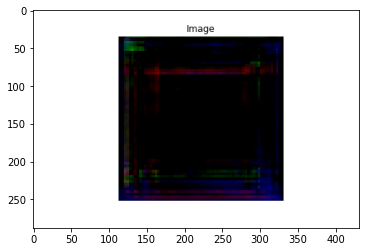

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/content/results/gen_0_0.png')
imgplot = plt.imshow(img)
plt.show()

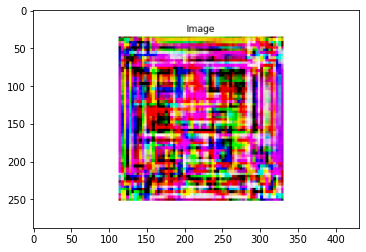

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/content/results/gen_8_0.png')
imgplot = plt.imshow(img)
plt.show()

In [ ]:
if __name__ == '__main__':
    data_dir = "/content/birds/"
    train_dir = data_dir + "/train"
    test_dir = data_dir + "/test"
    image_size = 64
    batch_size = 128
    z_dim = 100
    stage1_generator_lr = 0.0002
    stage1_discriminator_lr = 0.0002
    stage1_lr_decay_step = 600
    epochs = 250
    condition_dim = 128

    embeddings_file_path_train = train_dir + "/char-CNN-RNN-embeddings.pickle"
    embeddings_file_path_test = test_dir + "/char-CNN-RNN-embeddings.pickle"

    filenames_file_path_train = train_dir + "/filenames.pickle"
    filenames_file_path_test = test_dir + "/filenames.pickle"

    class_info_file_path_train = train_dir + "/class_info.pickle"
    class_info_file_path_test = test_dir + "/class_info.pickle"

    cub_dataset_dir = "/content/CUB_200_2011"
    
    # Define optimizers
    dis_optimizer = Adam(lr=stage1_discriminator_lr, beta_1=0.5, beta_2=0.999)
    gen_optimizer = Adam(lr=stage1_generator_lr, beta_1=0.5, beta_2=0.999)

    """"
    Load datasets
    """
    X_train, y_train, embeddings_train = load_dataset(filenames_file_path=filenames_file_path_train,
                                                      class_info_file_path=class_info_file_path_train,
                                                      cub_dataset_dir=cub_dataset_dir,
                                                      embeddings_file_path=embeddings_file_path_train,
                                                      image_size=(64, 64))

    X_test, y_test, embeddings_test = load_dataset(filenames_file_path=filenames_file_path_test,
                                                   class_info_file_path=class_info_file_path_test,
                                                   cub_dataset_dir=cub_dataset_dir,
                                                   embeddings_file_path=embeddings_file_path_test,
                                                   image_size=(64, 64))

    """
    Build and compile networks
    """
    ca_model = build_ca_model()
    ca_model.compile(loss="binary_crossentropy", optimizer="adam")

    stage1_dis = build_stage1_discriminator()
    stage1_dis.compile(loss='binary_crossentropy', optimizer=dis_optimizer)

    stage1_gen = build_stage1_generator()
    stage1_gen.compile(loss="mse", optimizer=gen_optimizer)

    embedding_compressor_model = build_embedding_compressor_model()
    embedding_compressor_model.compile(loss="binary_crossentropy", optimizer="adam")

    adversarial_model = build_adversarial_model(gen_model=stage1_gen, dis_model=stage1_dis)
    adversarial_model.compile(loss=['binary_crossentropy', KL_loss], loss_weights=[1, 2.0],
                              optimizer=gen_optimizer, metrics=None)

    tensorboard = TensorBoard(log_dir="logs/".format(time.time()))
    tensorboard.set_model(stage1_gen)
    tensorboard.set_model(stage1_dis)
    tensorboard.set_model(ca_model)
    tensorboard.set_model(embedding_compressor_model)

    # Generate an array containing real and fake values
    # Apply label smoothing as well
    real_labels = np.ones((batch_size, 1), dtype=float) * 0.9
    fake_labels = np.zeros((batch_size, 1), dtype=float) * 0.1

    for epoch in range(epochs):
        print("========================================")
        print("Epoch is:", epoch)
        print("Number of batches", int(X_train.shape[0] / batch_size))

        gen_losses = []
        dis_losses = []

        # Load data and train model
        number_of_batches = int(X_train.shape[0] / batch_size)
        for index in range(number_of_batches):
            print("Batch:{}".format(index+1))
            
            """
            Train the discriminator network
            """
            # Sample a batch of data
            z_noise = np.random.normal(0, 1, size=(batch_size, z_dim))
            image_batch = X_train[index * batch_size:(index + 1) * batch_size]
            embedding_batch = embeddings_train[index * batch_size:(index + 1) * batch_size]
            image_batch = (image_batch - 127.5) / 127.5

            # Generate fake images
            fake_images, _ = stage1_gen.predict([embedding_batch, z_noise], verbose=3)

            # Generate compressed embeddings
            compressed_embedding = embedding_compressor_model.predict_on_batch(embedding_batch)
            compressed_embedding = np.reshape(compressed_embedding, (-1, 1, 1, condition_dim))
            compressed_embedding = np.tile(compressed_embedding, (1, 4, 4, 1))

            dis_loss_real = stage1_dis.train_on_batch([image_batch, compressed_embedding],
                                                      np.reshape(real_labels, (batch_size, 1)))
            dis_loss_fake = stage1_dis.train_on_batch([fake_images, compressed_embedding],
                                                      np.reshape(fake_labels, (batch_size, 1)))
            dis_loss_wrong = stage1_dis.train_on_batch([image_batch[:(batch_size - 1)], compressed_embedding[1:]],
                                                       np.reshape(fake_labels[1:], (batch_size-1, 1)))

            d_loss = 0.5 * np.add(dis_loss_real, 0.5 * np.add(dis_loss_wrong, dis_loss_fake))

            print("d_loss_real:{}".format(dis_loss_real))
            print("d_loss_fake:{}".format(dis_loss_fake))
            print("d_loss_wrong:{}".format(dis_loss_wrong))
            print("d_loss:{}".format(d_loss))

            """
            Train the generator network 
            """
            g_loss = adversarial_model.train_on_batch([embedding_batch, z_noise, compressed_embedding],[K.ones((batch_size, 1)) * 0.9, K.ones((batch_size, 256)) * 0.9])
            print("g_loss:{}".format(g_loss))

            dis_losses.append(d_loss)
            gen_losses.append(g_loss)

        """
        Save losses to Tensorboard after each epoch
        """
        print('----------------------------------------\n\n\n------------------------------------------')
        print('epoch', epoch)
        print('discriminator_loss', np.mean(dis_losses))
        print('generator_loss', np.mean(gen_losses[0]))
        print('----------------------------------------\n\n\n------------------------------------------')
        # write_log(tensorboard, 'discriminator_loss', np.mean(dis_losses), epoch)
        # write_log(tensorboard, 'generator_loss', np.mean(gen_losses[0]), epoch)
        
        # Generate and save images after every 2nd epoch
        if epoch % 2 == 0:
            # z_noise2 = np.random.uniform(-1, 1, size=(batch_size, z_dim))
            z_noise2 = np.random.normal(0, 1, size=(batch_size, z_dim))
            embedding_batch = embeddings_test[0:batch_size]
            fake_images, _ = stage1_gen.predict_on_batch([embedding_batch, z_noise2])

            # Save images
            for i, img in enumerate(fake_images[:10]):
                save_rgb_img(img, "results2/gen_{}_{}.png".format(epoch, i))

    # Save models
    stage1_gen.save_weights("stage1_gen.h5")
    stage1_dis.save_weights("stage1_dis.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


embeddings:  (8855, 10, 1024)
Embeddings shape: (8855, 10, 1024)
embeddings:  (2933, 10, 1024)
Embeddings shape: (2933, 10, 1024)
Epoch is: 0
Number of batches 69
Batch:1
d_loss_real:0.8122678399085999
d_loss_fake:3.575197458267212
d_loss_wrong:4.886605739593506
d_loss:2.5215847194194794
g_loss:[0.7455109357833862, 0.710536003112793, 0.017487453296780586]
Batch:2
d_loss_real:1.5270516872406006
d_loss_fake:0.054266706109046936
d_loss_wrong:1.375795841217041
d_loss:1.1210414804518223
g_loss:[0.7267926931381226, 0.6928505301475525, 0.016971085220575333]
Batch:3
d_loss_real:2.021291732788086
d_loss_fake:0.2251158058643341
d_loss_wrong:3.0501608848571777
d_loss:1.829465039074421
g_loss:[0.7480901479721069, 0.7243802547454834, 0.011854937300086021]
Batch:4
d_loss_real:2.3700950145721436
d_loss_fake:0.010762353427708149
d_loss_wrong:0.7327295541763306
d_loss:1.3709204841870815
g_loss:[0.7460479140281677, 0.7076355814933777, 0.019206177443265915]
Batch:5
d_loss_real:2.2405407428741455
d_loss_f

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 1
Number of batches 69
Batch:1
d_loss_real:0.9213145971298218
d_loss_fake:0.0005900527467019856
d_loss_wrong:0.754291832447052
d_loss:0.6493777698633494
g_loss:[0.45322301983833313, 0.44844353199005127, 0.0023897383362054825]
Batch:2
d_loss_real:0.9445130228996277
d_loss_fake:0.002051097806543112
d_loss_wrong:0.7343789935112
d_loss:0.6563640342792496
g_loss:[0.41061297059059143, 0.40428653359413147, 0.003163212211802602]
Batch:3
d_loss_real:0.893027663230896
d_loss_fake:0.00028162344824522734
d_loss_wrong:0.956836462020874
d_loss:0.6857933529827278
g_loss:[0.506680428981781, 0.5011781454086304, 0.00275114132091403]
Batch:4
d_loss_real:0.9032697677612305
d_loss_fake:0.0011434359475970268
d_loss_wrong:0.6537822484970093
d_loss:0.6153663049917668
g_loss:[0.4124213755130768, 0.40418586134910583, 0.004117755219340324]
Batch:5
d_loss_real:0.9247691631317139
d_loss_fake:0.0004726737679447979
d_loss_wrong:0.6727274060249329
d_loss:0.6306846015140763
g_loss:[0.4028138816356659, 0.3926

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 3
Number of batches 69
Batch:1
d_loss_real:1.0857205390930176
d_loss_fake:0.06504020094871521
d_loss_wrong:0.615401029586792
d_loss:0.7129705771803856
g_loss:[4.040676116943359, 4.032192230224609, 0.0042419834062457085]
Batch:2
d_loss_real:1.0942867994308472
d_loss_fake:0.00046706225839443505
d_loss_wrong:0.6423060894012451
d_loss:0.7078366876303335
g_loss:[2.8288071155548096, 2.820859670639038, 0.0039737592451274395]
Batch:3
d_loss_real:0.9749003052711487
d_loss_fake:0.21492469310760498
d_loss_wrong:0.6730251312255859
d_loss:0.7094376087188721
g_loss:[3.377887010574341, 3.3644537925720215, 0.006716636009514332]
Batch:4
d_loss_real:0.9879158735275269
d_loss_fake:0.040220748633146286
d_loss_wrong:0.5771950483322144
d_loss:0.6483118860051036
g_loss:[1.5441375970840454, 1.5280874967575073, 0.008025022223591805]
Batch:5
d_loss_real:0.9080861210823059
d_loss_fake:0.004983770661056042
d_loss_wrong:0.686542809009552
d_loss:0.626924705458805
g_loss:[0.876732587814331, 0.8597395420074

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 5
Number of batches 69
Batch:1
d_loss_real:0.8477171659469604
d_loss_fake:0.0012204722734168172
d_loss_wrong:0.7054361701011658
d_loss:0.6005227435671259
g_loss:[0.615507185459137, 0.6102569103240967, 0.002625132445245981]
Batch:2
d_loss_real:0.865454375743866
d_loss_fake:0.0018291380256414413
d_loss_wrong:0.664260745048523
d_loss:0.5992496586404741
g_loss:[0.6089679002761841, 0.6034291982650757, 0.0027693479787558317]
Batch:3
d_loss_real:0.8580170273780823
d_loss_fake:0.0005208717193454504
d_loss_wrong:0.6934827566146851
d_loss:0.6025094207725488
g_loss:[0.5322863459587097, 0.5270014405250549, 0.002642467152327299]
Batch:4
d_loss_real:0.8193806409835815
d_loss_fake:0.0014082463458180428
d_loss_wrong:0.6494528651237488
d_loss:0.5724055983591825
g_loss:[0.5796101093292236, 0.5733222961425781, 0.003143899142742157]
Batch:5
d_loss_real:0.826644241809845
d_loss_fake:0.0007737101404927671
d_loss_wrong:0.6398836374282837
d_loss:0.5734864577971166
g_loss:[0.5298892855644226, 0.52369

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 7
Number of batches 69
Batch:1
d_loss_real:0.8487866520881653
d_loss_fake:0.0011570262722671032
d_loss_wrong:0.6868325471878052
d_loss:0.5963907194091007
g_loss:[0.41678282618522644, 0.40093231201171875, 0.00792525801807642]
Batch:2
d_loss_real:0.8520414233207703
d_loss_fake:0.0006181951612234116
d_loss_wrong:0.6564940810203552
d_loss:0.5902987807057798
g_loss:[0.40332621335983276, 0.3858962059020996, 0.008715000003576279]
Batch:3
d_loss_real:0.8404146432876587
d_loss_fake:0.0003639289061538875
d_loss_wrong:0.6643353700637817
d_loss:0.5863821463863133
g_loss:[0.38347452878952026, 0.3682778775691986, 0.007598319090902805]
Batch:4
d_loss_real:0.8122152090072632
d_loss_fake:0.00019932215218432248
d_loss_wrong:0.6403814554214478
d_loss:0.5662527988970396
g_loss:[0.4087657630443573, 0.39308813214302063, 0.007838817313313484]
Batch:5
d_loss_real:0.8124189376831055
d_loss_fake:0.0002151050721295178
d_loss_wrong:0.6358350515365601
d_loss:0.5652220079937251
g_loss:[0.40063712000846863

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 9
Number of batches 69
Batch:1
d_loss_real:0.8474550247192383
d_loss_fake:3.439569263719022e-05
d_loss_wrong:0.6758078932762146
d_loss:0.5926880846018321
g_loss:[0.3393385112285614, 0.3303750157356262, 0.0044817496091127396]
Batch:2
d_loss_real:0.8419486284255981
d_loss_fake:3.8718564610462636e-05
d_loss_wrong:0.6508623361587524
d_loss:0.5836995778936398
g_loss:[0.3430007994174957, 0.33549633622169495, 0.003752230666577816]
Batch:3
d_loss_real:0.8258339166641235
d_loss_fake:2.3548522221972235e-05
d_loss_wrong:0.6567901968955994
d_loss:0.5771203946865171
g_loss:[0.3409123718738556, 0.3344266414642334, 0.0032428710255771875]
Batch:4
d_loss_real:0.8025124073028564
d_loss_fake:4.324390829424374e-05
d_loss_wrong:0.6370023488998413
d_loss:0.5605176018534621
g_loss:[0.39347901940345764, 0.38648319244384766, 0.003497917205095291]
Batch:5
d_loss_real:0.8029321432113647
d_loss_fake:2.5083558284677565e-05
d_loss_wrong:0.6354966163635254
d_loss:0.5603464965861349
g_loss:[0.34899160265922

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 11
Number of batches 69
Batch:1
d_loss_real:0.8475600481033325
d_loss_fake:4.982060090696905e-06
d_loss_wrong:0.6712711453437805
d_loss:0.5915990559026341
g_loss:[0.35821086168289185, 0.3539354205131531, 0.0021377219818532467]
Batch:2
d_loss_real:0.8344000577926636
d_loss_fake:0.0003393332299310714
d_loss_wrong:0.6482771039009094
d_loss:0.5793541381790419
g_loss:[0.34594598412513733, 0.34138578176498413, 0.002280105371028185]
Batch:3
d_loss_real:0.8213738799095154
d_loss_fake:2.084697007376235e-05
d_loss_wrong:0.652147114276886
d_loss:0.5737289302664976
g_loss:[0.33712056279182434, 0.3328494429588318, 0.0021355627104640007]
Batch:4
d_loss_real:0.7982391119003296
d_loss_fake:0.0005764951347373426
d_loss_wrong:0.6359237432479858
d_loss:0.5582446155458456
g_loss:[0.346405953168869, 0.3424232304096222, 0.0019913676660507917]
Batch:5
d_loss_real:0.7964386940002441
d_loss_fake:3.8072099414421245e-05
d_loss_wrong:0.6373041272163391
d_loss:0.5575548968290605
g_loss:[0.350427895784378

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 13
Number of batches 69
Batch:1
d_loss_real:0.8502588868141174
d_loss_fake:5.826014330523321e-06
d_loss_wrong:0.6723852753639221
d_loss:0.5932272187516219
g_loss:[0.35560858249664307, 0.3531380295753479, 0.0012352734338492155]
Batch:2
d_loss_real:0.8273817300796509
d_loss_fake:1.0167880645894911e-05
d_loss_wrong:0.6503221392631531
d_loss:0.5762739418257752
g_loss:[0.36230549216270447, 0.3599827289581299, 0.001161379972472787]
Batch:3
d_loss_real:0.815488338470459
d_loss_fake:5.999898803565884e-06
d_loss_wrong:0.6499650478363037
d_loss:0.5702369311690063
g_loss:[0.34412118792533875, 0.3422515392303467, 0.0009348265011794865]
Batch:4
d_loss_real:0.7964811325073242
d_loss_fake:0.00018357021326664835
d_loss_wrong:0.6333369016647339
d_loss:0.5566206842231622
g_loss:[0.34999147057533264, 0.3478758633136749, 0.001057810615748167]
Batch:5
d_loss_real:0.7962511777877808
d_loss_fake:2.19650064536836e-05
d_loss_wrong:0.6325626969337463
d_loss:0.5562717543789404
g_loss:[0.342112809419631

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 15
Number of batches 69
Batch:1
d_loss_real:0.8480435609817505
d_loss_fake:0.00033929364872165024
d_loss_wrong:0.669266402721405
d_loss:0.5914232045834069
g_loss:[0.6372022032737732, 0.634773313999176, 0.001214445917867124]
Batch:2
d_loss_real:0.8662924766540527
d_loss_fake:0.0019677099771797657
d_loss_wrong:0.7116040587425232
d_loss:0.6115391805069521
g_loss:[0.6215828061103821, 0.619442880153656, 0.0010699722915887833]
Batch:3
d_loss_real:0.8678125143051147
d_loss_fake:0.000820585701148957
d_loss_wrong:1.063559889793396
d_loss:0.7000013760261936
g_loss:[0.6377671957015991, 0.6361896395683289, 0.0007887693354859948]
Batch:4
d_loss_real:0.9114474654197693
d_loss_fake:0.029112815856933594
d_loss_wrong:0.5910724401473999
d_loss:0.610770046710968
g_loss:[0.8273172974586487, 0.825492262840271, 0.0009125269716605544]
Batch:5
d_loss_real:0.8854754567146301
d_loss_fake:0.03228183090686798
d_loss_wrong:0.6102470755577087
d_loss:0.6033699549734592
g_loss:[1.239190697669983, 1.23742580

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 17
Number of batches 69
Batch:1
d_loss_real:0.8297145366668701
d_loss_fake:0.00017545757873449475
d_loss_wrong:0.6608463525772095
d_loss:0.580112720872421
g_loss:[0.47805866599082947, 0.4768199622631073, 0.0006193456356413662]
Batch:2
d_loss_real:0.8297591209411621
d_loss_fake:0.00013981552910991013
d_loss_wrong:0.6472783088684082
d_loss:0.5767340915699606
g_loss:[0.5445550680160522, 0.5432792901992798, 0.0006378801772370934]
Batch:3
d_loss_real:0.8111233711242676
d_loss_fake:9.21035825740546e-05
d_loss_wrong:0.6468592286109924
d_loss:0.5672995186105254
g_loss:[0.5091226696968079, 0.5079284310340881, 0.0005971112404949963]
Batch:4
d_loss_real:0.7997262477874756
d_loss_fake:0.001012476277537644
d_loss_wrong:0.6300032138824463
d_loss:0.5576170464337338
g_loss:[0.5103870630264282, 0.5090815424919128, 0.0006527472287416458]
Batch:5
d_loss_real:0.7972598075866699
d_loss_fake:0.00024619276518933475
d_loss_wrong:0.6296241283416748
d_loss:0.556097484070051
g_loss:[0.49698618054389954

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 19
Number of batches 69
Batch:1
d_loss_real:0.8300206661224365
d_loss_fake:0.00010306836338713765
d_loss_wrong:0.6604788303375244
d_loss:0.5801558077364461
g_loss:[0.5344832539558411, 0.533390998840332, 0.0005461323307827115]
Batch:2
d_loss_real:0.8247554302215576
d_loss_fake:0.00016384871560148895
d_loss_wrong:0.6462076902389526
d_loss:0.5739705998494173
g_loss:[0.5143977999687195, 0.5132182836532593, 0.000589765259064734]
Batch:3
d_loss_real:0.8109580278396606
d_loss_fake:7.646469020983204e-05
d_loss_wrong:0.6418706774711609
d_loss:0.565965799460173
g_loss:[0.5122683048248291, 0.5112333297729492, 0.0005174871766939759]
Batch:4
d_loss_real:0.801296591758728
d_loss_fake:5.557155964197591e-05
d_loss_wrong:0.6264434456825256
d_loss:0.5572730501899059
g_loss:[0.5766538977622986, 0.5757190585136414, 0.00046742294216528535]
Batch:5
d_loss_real:0.8021402955055237
d_loss_fake:0.00032947794534265995
d_loss_wrong:0.6267799139022827
d_loss:0.5578474957146682
g_loss:[0.54129558801651, 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 21
Number of batches 69
Batch:1
d_loss_real:0.828312337398529
d_loss_fake:0.000311483396217227
d_loss_wrong:0.6635266542434692
d_loss:0.5801157031091861
g_loss:[0.7118874788284302, 0.7113931775093079, 0.0002471409388817847]
Batch:2
d_loss_real:0.8232464790344238
d_loss_fake:0.0051675355061888695
d_loss_wrong:0.6509201526641846
d_loss:0.5756451615598053
g_loss:[0.7244163751602173, 0.7238678932189941, 0.0002742303186096251]
Batch:3
d_loss_real:0.8157211542129517
d_loss_fake:0.00014011144230607897
d_loss_wrong:0.6365212202072144
d_loss:0.5670259100188559
g_loss:[0.7123386263847351, 0.7118539810180664, 0.00024231578572653234]
Batch:4
d_loss_real:0.8009148836135864
d_loss_fake:0.00020864850375801325
d_loss_wrong:0.621163547039032
d_loss:0.5558004906924907
g_loss:[0.7092844247817993, 0.7087517380714417, 0.00026633107336238027]
Batch:5
d_loss_real:0.7984578013420105
d_loss_fake:0.0003107711090706289
d_loss_wrong:0.6219797134399414
d_loss:0.5548015218082583
g_loss:[0.6913097500801086

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 23
Number of batches 69
Batch:1
d_loss_real:0.8289719820022583
d_loss_fake:0.00018767730216495693
d_loss_wrong:0.6583555340766907
d_loss:0.5791217938458431
g_loss:[0.6491794586181641, 0.6487489938735962, 0.00021523100440390408]
Batch:2
d_loss_real:0.8252640962600708
d_loss_fake:0.000323351239785552
d_loss_wrong:0.6504605412483215
d_loss:0.5753280212520622
g_loss:[0.6257755756378174, 0.6253079175949097, 0.0002338301856070757]
Batch:3
d_loss_real:0.8131476640701294
d_loss_fake:0.00033391013857908547
d_loss_wrong:0.6362581253051758
d_loss:0.5657218408960034
g_loss:[0.6112385392189026, 0.6108665466308594, 0.00018598788301460445]
Batch:4
d_loss_real:0.7964211702346802
d_loss_fake:0.00012296656495891511
d_loss_wrong:0.6236945390701294
d_loss:0.5541649615261122
g_loss:[0.6398488283157349, 0.6394387483596802, 0.00020503986161202192]
Batch:5
d_loss_real:0.7963086366653442
d_loss_fake:6.100877726566978e-05
d_loss_wrong:0.623258113861084
d_loss:0.5539840989922595
g_loss:[0.6318711042404

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 25
Number of batches 69
Batch:1
d_loss_real:0.8258059024810791
d_loss_fake:0.00010643992573022842
d_loss_wrong:0.6590294241905212
d_loss:0.5776869172696024
g_loss:[0.6154345273971558, 0.6150851249694824, 0.00017470738384872675]
Batch:2
d_loss_real:0.8163244724273682
d_loss_fake:4.964055187883787e-05
d_loss_wrong:0.6580883860588074
d_loss:0.5726967428663556
g_loss:[0.6399391889572144, 0.6395589709281921, 0.00019010585674550384]
Batch:3
d_loss_real:0.8083487153053284
d_loss_fake:6.5963962697424e-05
d_loss_wrong:0.6384139060974121
d_loss:0.5637943251676916
g_loss:[0.5879758596420288, 0.5876286625862122, 0.00017360495985485613]
Batch:4
d_loss_real:0.7951882481575012
d_loss_fake:6.711360765621066e-05
d_loss_wrong:0.6229522228240967
d_loss:0.5533489581866888
g_loss:[0.6348811388015747, 0.634503960609436, 0.00018859311239793897]
Batch:5
d_loss_real:0.796808123588562
d_loss_fake:6.704336556140333e-05
d_loss_wrong:0.6234789490699768
d_loss:0.5542905599031656
g_loss:[0.636876106262207,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 27
Number of batches 69
Batch:1
d_loss_real:0.8155268430709839
d_loss_fake:0.00034701600088737905
d_loss_wrong:0.6759583950042725
d_loss:0.5768397742867819
g_loss:[0.5568588972091675, 0.5565609931945801, 0.00014895066851750016]
Batch:2
d_loss_real:0.8291561007499695
d_loss_fake:3.434087193454616e-05
d_loss_wrong:0.6351099014282227
d_loss:0.573364110950024
g_loss:[0.5788682699203491, 0.5785555243492126, 0.00015637389151379466]
Batch:3
d_loss_real:0.8354063034057617
d_loss_fake:4.722857556771487e-05
d_loss_wrong:0.6213973760604858
d_loss:0.5730643028618942
g_loss:[0.5585928559303284, 0.5583087205886841, 0.00014205434126779437]
Batch:4
d_loss_real:0.8001817464828491
d_loss_fake:9.650764695834368e-06
d_loss_wrong:0.6168637871742249
d_loss:0.5543092327261547
g_loss:[0.6670325994491577, 0.6667053699493408, 0.0001636175438761711]
Batch:5
d_loss_real:0.8052658438682556
d_loss_fake:1.6648020391585305e-05
d_loss_wrong:0.6198480129241943
d_loss:0.5575990871702743
g_loss:[0.5770601630210

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 29
Number of batches 69
Batch:1
d_loss_real:0.8449382781982422
d_loss_fake:0.0014300582697615027
d_loss_wrong:0.6556755304336548
d_loss:0.5867455362749752
g_loss:[0.6490125060081482, 0.6487458944320679, 0.00013331678928807378]
Batch:2
d_loss_real:0.8487361073493958
d_loss_fake:0.0006096041179262102
d_loss_wrong:0.6509235501289368
d_loss:0.5872513422364136
g_loss:[0.6230220198631287, 0.6227318644523621, 0.00014507419837173074]
Batch:3
d_loss_real:0.8275136947631836
d_loss_fake:0.0015185512602329254
d_loss_wrong:0.6384210586547852
d_loss:0.5737417498603463
g_loss:[0.5941275954246521, 0.593863844871521, 0.00013186571595724672]
Batch:4
d_loss_real:0.8175414800643921
d_loss_fake:0.0002754219458438456
d_loss_wrong:0.6106076240539551
d_loss:0.5614915015321458
g_loss:[0.606162965297699, 0.6058310866355896, 0.00016593429609201849]
Batch:5
d_loss_real:0.8094476461410522
d_loss_fake:0.0002718519535847008
d_loss_wrong:0.6176331043243408
d_loss:0.5592000621400075
g_loss:[0.600499987602233

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 31
Number of batches 69
Batch:1
d_loss_real:0.818395733833313
d_loss_fake:8.766783867031336e-05
d_loss_wrong:0.662691593170166
d_loss:0.5748926821688656
g_loss:[0.5345675945281982, 0.5343345403671265, 0.00011653778346953914]
Batch:2
d_loss_real:0.8141239285469055
d_loss_fake:0.00038995459908619523
d_loss_wrong:0.6536167860031128
d_loss:0.5705636494240025
g_loss:[0.5955244898796082, 0.5952720642089844, 0.00012621181667782366]
Batch:3
d_loss_real:0.8103815317153931
d_loss_fake:0.0001354029809590429
d_loss_wrong:0.629525899887085
d_loss:0.5626060915747075
g_loss:[0.5703467130661011, 0.5701266527175903, 0.00011002854444086552]
Batch:4
d_loss_real:0.8001604080200195
d_loss_fake:2.4778657461865805e-05
d_loss_wrong:0.6169432401657104
d_loss:0.5543222087158028
g_loss:[0.6115818619728088, 0.6113133430480957, 0.00013425560609903187]
Batch:5
d_loss_real:0.8061391115188599
d_loss_fake:2.564416718087159e-05
d_loss_wrong:0.6168184876441956
d_loss:0.557280588712274
g_loss:[0.557361245155334

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 33
Number of batches 69
Batch:1
d_loss_real:0.8178809285163879
d_loss_fake:2.685009349079337e-05
d_loss_wrong:0.6454706192016602
d_loss:0.5703148315819817
g_loss:[0.501437783241272, 0.501222550868988, 0.00010762643069028854]
Batch:2
d_loss_real:0.8180042505264282
d_loss_fake:1.848333158704918e-05
d_loss_wrong:0.6491716504096985
d_loss:0.5712996586985355
g_loss:[0.5539469718933105, 0.5537130832672119, 0.0001169363094959408]
Batch:3
d_loss_real:0.8080512285232544
d_loss_fake:2.8173975806566887e-05
d_loss_wrong:0.6286469101905823
d_loss:0.5611943853032244
g_loss:[0.49019497632980347, 0.4899892807006836, 0.00010285027383361012]
Batch:4
d_loss_real:0.7924211025238037
d_loss_fake:2.6839214115170762e-05
d_loss_wrong:0.6124527454376221
d_loss:0.5493304474248362
g_loss:[0.5385866761207581, 0.5383303165435791, 0.00012818218965549022]
Batch:5
d_loss_real:0.8031094074249268
d_loss_fake:2.95060635835398e-05
d_loss_wrong:0.6164357662200928
d_loss:0.5556710217833825
g_loss:[0.49467223882675

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 35
Number of batches 69
Batch:1
d_loss_real:0.8147307634353638
d_loss_fake:3.0381048418348655e-05
d_loss_wrong:0.6412875056266785
d_loss:0.5676948533864561
g_loss:[0.46824967861175537, 0.4680459499359131, 0.00010186574945691973]
Batch:2
d_loss_real:0.8018712997436523
d_loss_fake:1.7370257410220802e-05
d_loss_wrong:0.6406114101409912
d_loss:0.5610928449714265
g_loss:[0.5938937664031982, 0.593668520450592, 0.000112619498395361]
Batch:3
d_loss_real:0.8083799481391907
d_loss_fake:7.642684067832306e-06
d_loss_wrong:0.6382646560668945
d_loss:0.5637580487573359
g_loss:[0.4652629792690277, 0.46506965160369873, 9.666247933637351e-05]
Batch:4
d_loss_real:0.782689094543457
d_loss_fake:6.47488468530355e-06
d_loss_wrong:0.6202922463417053
d_loss:0.5464192275783262
g_loss:[0.5015788674354553, 0.5013387203216553, 0.00012008626799797639]
Batch:5
d_loss_real:0.7936791181564331
d_loss_fake:5.60203170607565e-06
d_loss_wrong:0.625429630279541
d_loss:0.5531983671560283
g_loss:[0.46625927090644836

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 37
Number of batches 69
Batch:1
d_loss_real:0.8187373876571655
d_loss_fake:0.0002259473840240389
d_loss_wrong:0.6552214622497559
d_loss:0.5732305462370277
g_loss:[0.4914278984069824, 0.49123308062553406, 9.741017129272223e-05]
Batch:2
d_loss_real:0.8093089461326599
d_loss_fake:7.717648986726999e-05
d_loss_wrong:0.6499544978141785
d_loss:0.5671623916423414
g_loss:[0.5425047278404236, 0.5422793626785278, 0.00011269288370385766]
Batch:3
d_loss_real:0.8034735918045044
d_loss_fake:7.743650348857045e-05
d_loss_wrong:0.6344609260559082
d_loss:0.5603713865421014
g_loss:[0.5597456097602844, 0.5595540404319763, 9.579558536643162e-05]
Batch:4
d_loss_real:0.7869652509689331
d_loss_fake:6.714757910231128e-05
d_loss_wrong:0.611542284488678
d_loss:0.5463849835014116
g_loss:[0.6217164397239685, 0.6214759349822998, 0.00012024029274471104]
Batch:5
d_loss_real:0.8038608431816101
d_loss_fake:4.756954876938835e-05
d_loss_wrong:0.6140941381454468
d_loss:0.5554658485143591
g_loss:[0.568813383579254

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 39
Number of batches 69
Batch:1
d_loss_real:0.835224986076355
d_loss_fake:0.0006138880271464586
d_loss_wrong:0.6655088663101196
d_loss:0.584143181622494
g_loss:[0.57856684923172, 0.5772427320480347, 0.0006620726780965924]
Batch:2
d_loss_real:0.8259173631668091
d_loss_fake:0.0006668637506663799
d_loss_wrong:0.6472363471984863
d_loss:0.5749344843206927
g_loss:[0.6022921204566956, 0.601041316986084, 0.0006254096515476704]
Batch:3
d_loss_real:0.8206796646118164
d_loss_fake:0.0007039576303213835
d_loss_wrong:0.6358532309532166
d_loss:0.5694791294517927
g_loss:[0.5956606864929199, 0.5946088433265686, 0.0005259313620626926]
Batch:4
d_loss_real:0.8058106899261475
d_loss_fake:0.0005782441003248096
d_loss_wrong:0.611480712890625
d_loss:0.5559200842108112
g_loss:[0.6144941449165344, 0.6131991147994995, 0.0006475192494690418]
Batch:5
d_loss_real:0.8106241822242737
d_loss_fake:0.000535307452082634
d_loss_wrong:0.6149145364761353
d_loss:0.5591745520941913
g_loss:[0.5874467492103577, 0.5863

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 41
Number of batches 69
Batch:1
d_loss_real:0.8262245655059814
d_loss_fake:4.383437772048637e-05
d_loss_wrong:0.6558312773704529
d_loss:0.5770810606900341
g_loss:[0.6143468618392944, 0.6139754056930542, 0.00018574146088212729]
Batch:2
d_loss_real:0.8162883520126343
d_loss_fake:4.490162245929241e-05
d_loss_wrong:0.6452683210372925
d_loss:0.5694724816712551
g_loss:[0.6518041491508484, 0.6513685584068298, 0.0002177849819418043]
Batch:3
d_loss_real:0.809202253818512
d_loss_fake:2.631251663842704e-05
d_loss_wrong:0.6313492059707642
d_loss:0.5624450065311066
g_loss:[0.5900487303733826, 0.5896673202514648, 0.00019069672271143645]
Batch:4
d_loss_real:0.7956904768943787
d_loss_fake:1.3626297004520893e-05
d_loss_wrong:0.6131032109260559
d_loss:0.5511244477529544
g_loss:[0.567685604095459, 0.567279040813446, 0.0002032783959293738]
Batch:5
d_loss_real:0.8031792044639587
d_loss_fake:1.2931539458804764e-05
d_loss_wrong:0.614057719707489
d_loss:0.5551072650437163
g_loss:[0.5494383573532104,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 43
Number of batches 69
Batch:1
d_loss_real:0.8322543501853943
d_loss_fake:4.5409586164169014e-05
d_loss_wrong:0.6418488025665283
d_loss:0.5766007281308703
g_loss:[0.5809950828552246, 0.5807608962059021, 0.00011710770195350051]
Batch:2
d_loss_real:0.8178238868713379
d_loss_fake:3.2675663533154875e-05
d_loss_wrong:0.631822407245636
d_loss:0.5668757141629612
g_loss:[0.5676499605178833, 0.5673565864562988, 0.00014667776122223586]
Batch:3
d_loss_real:0.8102027177810669
d_loss_fake:2.9155162337701768e-05
d_loss_wrong:0.6235837936401367
d_loss:0.561004596091152
g_loss:[0.5614029765129089, 0.5611374378204346, 0.0001327651261817664]
Batch:4
d_loss_real:0.7920114994049072
d_loss_fake:3.952081533498131e-05
d_loss_wrong:0.6093978881835938
d_loss:0.5483651019521858
g_loss:[0.579452395439148, 0.5791645050048828, 0.00014393075252883136]
Batch:5
d_loss_real:0.8019400835037231
d_loss_fake:6.63665123283863e-05
d_loss_wrong:0.6116707921028137
d_loss:0.5539043314056471
g_loss:[0.553183197975158

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 45
Number of batches 69
Batch:1
d_loss_real:0.8117583990097046
d_loss_fake:5.036279253545217e-05
d_loss_wrong:0.6506429314613342
d_loss:0.5685525230683197
g_loss:[0.5621852874755859, 0.5619551539421082, 0.00011505839211167768]
Batch:2
d_loss_real:0.8018254041671753
d_loss_fake:3.04709465126507e-05
d_loss_wrong:0.640048086643219
d_loss:0.5609323414810206
g_loss:[0.6343803405761719, 0.6341118216514587, 0.0001342669129371643]
Batch:3
d_loss_real:0.8051954507827759
d_loss_fake:5.275622243061662e-05
d_loss_wrong:0.6267687082290649
d_loss:0.5593030915042618
g_loss:[0.5722585916519165, 0.572035014629364, 0.00011178384011145681]
Batch:4
d_loss_real:0.7912098169326782
d_loss_fake:7.923345401650295e-05
d_loss_wrong:0.6087917685508728
d_loss:0.5478226589675614
g_loss:[0.6082513332366943, 0.6079763174057007, 0.00013752066297456622]
Batch:5
d_loss_real:0.8004281520843506
d_loss_fake:0.0001120092420023866
d_loss_wrong:0.6114493608474731
d_loss:0.5531044185645442
g_loss:[0.5748780965805054,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 47
Number of batches 69
Batch:1
d_loss_real:0.822853684425354
d_loss_fake:4.9028578359866515e-05
d_loss_wrong:0.6735472083091736
d_loss:0.5798259014345604
g_loss:[0.646107017993927, 0.6459018588066101, 0.00010256541281705722]
Batch:2
d_loss_real:0.7920833826065063
d_loss_fake:8.427279681200162e-05
d_loss_wrong:0.6633345484733582
d_loss:0.5618963966207957
g_loss:[0.6744920611381531, 0.6742624044418335, 0.00011482840636745095]
Batch:3
d_loss_real:0.7889808416366577
d_loss_fake:5.028511077398434e-05
d_loss_wrong:0.6415007710456848
d_loss:0.5548781848574436
g_loss:[0.6246417760848999, 0.6244336366653442, 0.0001040742063196376]
Batch:4
d_loss_real:0.7858169674873352
d_loss_fake:6.651443254668266e-05
d_loss_wrong:0.6135768890380859
d_loss:0.5463193346113258
g_loss:[0.6918906569480896, 0.6916539072990417, 0.00011837870988529176]
Batch:5
d_loss_real:0.7981153726577759
d_loss_fake:5.156294355401769e-05
d_loss_wrong:0.618308961391449
d_loss:0.5536478174126387
g_loss:[0.6176379323005676

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 49
Number of batches 69
Batch:1
d_loss_real:0.8101484179496765
d_loss_fake:0.0001942244853125885
d_loss_wrong:0.6659070253372192
d_loss:0.5715995214304712
g_loss:[0.6255422830581665, 0.6253684759140015, 8.689002424944192e-05]
Batch:2
d_loss_real:0.8117713928222656
d_loss_fake:1.9646431610453874e-05
d_loss_wrong:0.6362125873565674
d_loss:0.5649437548581773
g_loss:[0.7786643505096436, 0.7784713506698608, 9.650882566347718e-05]
Batch:3
d_loss_real:0.8192610740661621
d_loss_fake:0.0001816445728763938
d_loss_wrong:0.617500364780426
d_loss:0.5640510393714067
g_loss:[0.6455993056297302, 0.6454284191131592, 8.544707088731229e-05]
Batch:4
d_loss_real:0.801651656627655
d_loss_fake:4.638381506083533e-05
d_loss_wrong:0.6029258966445923
d_loss:0.5515688984287408
g_loss:[0.6909168362617493, 0.6907179355621338, 9.945531201083213e-05]
Batch:5
d_loss_real:0.8104534149169922
d_loss_fake:3.139950058539398e-05
d_loss_wrong:0.6066461801528931
d_loss:0.5568961023718657
g_loss:[0.6022934913635254, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 51
Number of batches 69
Batch:1
d_loss_real:0.8137316703796387
d_loss_fake:7.0452488216687925e-06
d_loss_wrong:0.6515944004058838
d_loss:0.5697661966034957
g_loss:[0.589346170425415, 0.5891925096511841, 7.683511648792773e-05]
Batch:2
d_loss_real:0.8035138845443726
d_loss_fake:1.378785691485973e-05
d_loss_wrong:0.6435588002204895
d_loss:0.5626500892915374
g_loss:[0.6093299388885498, 0.6091563701629639, 8.67720737005584e-05]
Batch:3
d_loss_real:0.7980296611785889
d_loss_fake:1.3007641427975614e-05
d_loss_wrong:0.6320357918739319
d_loss:0.5570270304681344
g_loss:[0.552850604057312, 0.5527021884918213, 7.421373447868973e-05]
Batch:4
d_loss_real:0.7870687246322632
d_loss_fake:2.2902935597812757e-05
d_loss_wrong:0.608488142490387
d_loss:0.5456621236726278
g_loss:[0.6125451326370239, 0.6123642921447754, 9.041532757692039e-05]
Batch:5
d_loss_real:0.801011860370636
d_loss_fake:3.9249247492989525e-05
d_loss_wrong:0.6114100813865662
d_loss:0.5533682628438328
g_loss:[0.5250612497329712, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 53
Number of batches 69
Batch:1
d_loss_real:0.8020914793014526
d_loss_fake:5.40027303941315e-06
d_loss_wrong:0.646638035774231
d_loss:0.5627065986625439
g_loss:[0.5744853615760803, 0.5743358731269836, 7.475409074686468e-05]
Batch:2
d_loss_real:0.7930139303207397
d_loss_fake:2.9976411042298423e-06
d_loss_wrong:0.6325533390045166
d_loss:0.5546460493217751
g_loss:[0.6308495402336121, 0.6306817531585693, 8.389923459617421e-05]
Batch:3
d_loss_real:0.7974326014518738
d_loss_fake:2.4096391371131176e-06
d_loss_wrong:0.6324978470802307
d_loss:0.5568413649057788
g_loss:[0.5511574745178223, 0.5510143041610718, 7.159673987189308e-05]
Batch:4
d_loss_real:0.7809352278709412
d_loss_fake:2.505139718778082e-06
d_loss_wrong:0.6092888712882996
d_loss:0.5427904580424752
g_loss:[0.6044597625732422, 0.6042835712432861, 8.809388964436948e-05]
Batch:5
d_loss_real:0.7985141277313232
d_loss_fake:1.5806378996785497e-06
d_loss_wrong:0.6169271469116211
d_loss:0.5534892457530418
g_loss:[0.5256280899047852

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss:[0.5528353452682495, 0.5526994466781616, 6.796368688810617e-05]
----------------------------------------


------------------------------------------
epoch 54
discriminator_loss 0.5555136747750731
generator_loss 0.3537109798950648
----------------------------------------


------------------------------------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch is: 55
Number of batches 69
Batch:1
d_loss_real:0.8000865578651428
d_loss_fake:2.4411818230873905e-05
d_loss_wrong:0.647443950176239
d_loss:0.5619103694311889
g_loss:[0.5236073136329651, 0.5234663486480713, 7.047496183076873e-05]
Batch:2
d_loss_real:0.7985197305679321
d_loss_fake:3.6390169952937867e-06
d_loss_wrong:0.6269978880882263
d_loss:0.5560102470602715
g_loss:[0.6255251169204712, 0.6253629922866821, 8.10673664091155e-05]
Batch:3
d_loss_real:0.8111146688461304
d_loss_fake:3.1171141472441377e-06
d_loss_wrong:0.6217851042747498
d_loss:0.5610043897702894
g_loss:[0.5248293280601501, 0.5246922969818115, 6.852105434518307e-05]
Batch:4
d_loss_real:0.7877476811408997
d_loss_fake:3.590165533751133e-06
d_loss_wrong:0.603935182094574
d_loss:0.5448585336354768
g_loss:[0.587703287601471, 0.5875376462936401, 8.283412171294913e-05]
Batch:5
d_loss_real:0.806951642036438
d_loss_fake:4.647968125937041e-06
d_loss_wrong:0.6065572500228882
d_loss:0.5551162955159725
g_loss:[0.5055267214775085, 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 57
Number of batches 69
Batch:1
d_loss_real:0.8360491991043091
d_loss_fake:2.8584778192453086e-05
d_loss_wrong:0.6359162926673889
d_loss:0.5770108189135499
g_loss:[0.5023556351661682, 0.5022190809249878, 6.827947800047696e-05]
Batch:2
d_loss_real:0.7963883876800537
d_loss_fake:4.8168094508582726e-05
d_loss_wrong:0.6315634846687317
d_loss:0.5560971070308369
g_loss:[0.6061422228813171, 0.6059868335723877, 7.768112845951691e-05]
Batch:3
d_loss_real:0.8058441281318665
d_loss_fake:2.6821297069545835e-05
d_loss_wrong:0.6263203024864197
d_loss:0.5595088450118055
g_loss:[0.4958091676235199, 0.49567630887031555, 6.642241351073608e-05]
Batch:4
d_loss_real:0.786349892616272
d_loss_fake:1.926451295730658e-05
d_loss_wrong:0.6055026054382324
d_loss:0.5445554137959334
g_loss:[0.561420738697052, 0.5612595081329346, 8.061644621193409e-05]
Batch:5
d_loss_real:0.7999241352081299
d_loss_fake:1.752447133185342e-05
d_loss_wrong:0.6095859408378601
d_loss:0.5523629339313629
g_loss:[0.496545195579528

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 59
Number of batches 69
Batch:1
d_loss_real:0.8009859323501587
d_loss_fake:8.257167792180553e-05
d_loss_wrong:0.7524829506874084
d_loss:0.5886343467664119
g_loss:[0.5702311396598816, 0.5701018571853638, 6.465464684879407e-05]
Batch:2
d_loss_real:0.8038660883903503
d_loss_fake:0.0022441151086241007
d_loss_wrong:0.6395695805549622
d_loss:0.5623864681110717
g_loss:[0.9086935520172119, 0.9085451364517212, 7.420295150950551e-05]
Batch:3
d_loss_real:0.8287181258201599
d_loss_fake:9.185746603179723e-05
d_loss_wrong:0.6287438273429871
d_loss:0.5715679841123347
g_loss:[0.7025249004364014, 0.7023990154266357, 6.293479236774147e-05]
Batch:4
d_loss_real:0.8239384293556213
d_loss_fake:0.0010944290552288294
d_loss_wrong:0.6048446893692017
d_loss:0.5634539942839183
g_loss:[0.7053444981575012, 0.7051802277565002, 8.21416251710616e-05]
Batch:5
d_loss_real:0.821694016456604
d_loss_fake:0.0003305056015960872
d_loss_wrong:0.6085749268531799
d_loss:0.563073366341996
g_loss:[0.5805007815361023, 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 61
Number of batches 69
Batch:1
d_loss_real:0.8004905581474304
d_loss_fake:2.3589316697325557e-05
d_loss_wrong:0.6483398079872131
d_loss:0.5623361283996928
g_loss:[0.4951024353504181, 0.4949772357940674, 6.260482768993825e-05]
Batch:2
d_loss_real:0.7826225757598877
d_loss_fake:4.7628982429159805e-06
d_loss_wrong:0.642837405204773
d_loss:0.5520218299056978
g_loss:[0.5344572067260742, 0.5343120098114014, 7.261110295075923e-05]
Batch:3
d_loss_real:0.7944861650466919
d_loss_fake:4.260790774424095e-06
d_loss_wrong:0.6344374418258667
d_loss:0.5558535081775062
g_loss:[0.45469456911087036, 0.454571932554245, 6.131797272246331e-05]
Batch:4
d_loss_real:0.7760756611824036
d_loss_fake:5.506175057234941e-06
d_loss_wrong:0.6084374785423279
d_loss:0.5401485767705481
g_loss:[0.49217328429222107, 0.4920215606689453, 7.586815627291799e-05]
Batch:5
d_loss_real:0.7962539196014404
d_loss_fake:5.503238753590267e-06
d_loss_wrong:0.6090527772903442
d_loss:0.5503915299329947
g_loss:[0.438904076814651

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 63
Number of batches 69
Batch:1
d_loss_real:0.7881489992141724
d_loss_fake:6.87901847413741e-05
d_loss_wrong:0.6465994715690613
d_loss:0.5557415650455368
g_loss:[0.4632149338722229, 0.46309375762939453, 6.0590929933823645e-05]
Batch:2
d_loss_real:0.7811290621757507
d_loss_fake:2.3151995264925063e-05
d_loss_wrong:0.6423647403717041
d_loss:0.5511615041796176
g_loss:[0.5170897841453552, 0.5169516801834106, 6.903929897816852e-05]
Batch:3
d_loss_real:0.8037930727005005
d_loss_fake:9.707659955893178e-06
d_loss_wrong:0.6351009607315063
d_loss:0.5606742034481158
g_loss:[0.39748650789260864, 0.39736998081207275, 5.8268720749765635e-05]
Batch:4
d_loss_real:0.779148519039154
d_loss_fake:1.0715903044911101e-05
d_loss_wrong:0.6037334203720093
d_loss:0.5405102935883406
g_loss:[0.4197443425655365, 0.41959890723228455, 7.271126378327608e-05]
Batch:5
d_loss_real:0.8002541661262512
d_loss_fake:7.571804871986387e-06
d_loss_wrong:0.6074764132499695
d_loss:0.551998079326836
g_loss:[0.387034684419

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 65
Number of batches 69
Batch:1
d_loss_real:0.7897893786430359
d_loss_fake:4.4706051994580775e-05
d_loss_wrong:0.6705449223518372
d_loss:0.5625420964224759
g_loss:[0.42348966002464294, 0.4233744144439697, 5.761795910075307e-05]
Batch:2
d_loss_real:0.7885047197341919
d_loss_fake:1.6840478565427475e-05
d_loss_wrong:0.6228153705596924
d_loss:0.5499604126266604
g_loss:[0.45369747281074524, 0.45356422662734985, 6.662830855930224e-05]
Batch:3
d_loss_real:0.8104801177978516
d_loss_fake:5.966135358903557e-05
d_loss_wrong:0.6365752816200256
d_loss:0.5643987946423294
g_loss:[0.39565473794937134, 0.3955419361591339, 5.6394481362076476e-05]
Batch:4
d_loss_real:0.7866689562797546
d_loss_fake:0.00011711857951013371
d_loss_wrong:0.5958288908004761
d_loss:0.5423209804848739
g_loss:[0.4399377405643463, 0.43979883193969727, 6.944709457457066e-05]
Batch:5
d_loss_real:0.8047971129417419
d_loss_fake:4.304363392293453e-05
d_loss_wrong:0.6087544560432434
d_loss:0.5545979313901626
g_loss:[0.39769217

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 67
Number of batches 69
Batch:1
d_loss_real:0.8299973011016846
d_loss_fake:1.9365539628779516e-05
d_loss_wrong:0.6537915468215942
d_loss:0.578451378641148
g_loss:[0.46609869599342346, 0.465984970331192, 5.686075382982381e-05]
Batch:2
d_loss_real:0.7904210090637207
d_loss_fake:0.00026712651015259326
d_loss_wrong:0.677152156829834
d_loss:0.564565325366857
g_loss:[0.46956565976142883, 0.46943196654319763, 6.684710388071835e-05]
Batch:3
d_loss_real:0.797849714756012
d_loss_fake:0.0001820739998947829
d_loss_wrong:0.6462169885635376
d_loss:0.5605246230188641
g_loss:[0.420849472284317, 0.420738160610199, 5.565160245168954e-05]
Batch:4
d_loss_real:0.7812880873680115
d_loss_fake:6.738667434547096e-05
d_loss_wrong:0.6024168133735657
d_loss:0.5412650936959835
g_loss:[0.4141465723514557, 0.41400405764579773, 7.125396223273128e-05]
Batch:5
d_loss_real:0.792579174041748
d_loss_fake:4.665991218644194e-05
d_loss_wrong:0.6140952706336975
d_loss:0.549825069657345
g_loss:[0.37431395053863525, 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 69
Number of batches 69
Batch:1
d_loss_real:0.7853240966796875
d_loss_fake:0.0004878383479081094
d_loss_wrong:0.7502461671829224
d_loss:0.5803455497225514
g_loss:[0.5125677585601807, 0.5124592781066895, 5.423487164080143e-05]
Batch:2
d_loss_real:0.8493629097938538
d_loss_fake:4.2055262383655645e-06
d_loss_wrong:0.6000494956970215
d_loss:0.5746948802027418
g_loss:[1.232358455657959, 1.2322324514389038, 6.301318353507668e-05]
Batch:3
d_loss_real:0.8810334205627441
d_loss_fake:0.0102635333314538
d_loss_wrong:0.5942704081535339
d_loss:0.591650195652619
g_loss:[0.37962159514427185, 0.37948310375213623, 6.923878390807658e-05]
Batch:4
d_loss_real:0.8216327428817749
d_loss_fake:6.296516403381247e-06
d_loss_wrong:0.5737647414207458
d_loss:0.5542591309251748
g_loss:[0.39753225445747375, 0.3973502218723297, 9.101715113501996e-05]
Batch:5
d_loss_real:0.8492192029953003
d_loss_fake:0.0005509051261469722
d_loss_wrong:0.5942477583885193
d_loss:0.5733092673763167
g_loss:[0.37363991141319275,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 71
Number of batches 69
Batch:1
d_loss_real:0.8219925761222839
d_loss_fake:0.00036948153865523636
d_loss_wrong:0.5949572324752808
d_loss:0.559827966564626
g_loss:[0.5104814767837524, 0.5100654363632202, 0.00020802917424589396]
Batch:2
d_loss_real:0.7926625609397888
d_loss_fake:0.000511699472554028
d_loss_wrong:0.6822677850723267
d_loss:0.5670261516061146
g_loss:[0.49705079197883606, 0.4964710474014282, 0.0002898707170970738]
Batch:3
d_loss_real:0.8136531114578247
d_loss_fake:0.00038830089033581316
d_loss_wrong:0.6289357542991638
d_loss:0.5641575695262873
g_loss:[0.4955093264579773, 0.495036244392395, 0.00023654372489545494]
Batch:4
d_loss_real:0.7908639907836914
d_loss_fake:0.00033011691994033754
d_loss_wrong:0.5823777318000793
d_loss:0.5411089575718506
g_loss:[0.5422534942626953, 0.5415879487991333, 0.0003327734302729368]
Batch:5
d_loss_real:0.7896237373352051
d_loss_fake:0.0002004378184210509
d_loss_wrong:0.6095476746559143
d_loss:0.5472488967861864
g_loss:[0.54102355241775

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 73
Number of batches 69
Batch:1
d_loss_real:0.7569661736488342
d_loss_fake:0.0001561685639899224
d_loss_wrong:0.5666666030883789
d_loss:0.5201887797375093
g_loss:[0.4246286153793335, 0.4242570400238037, 0.00018578485469333827]
Batch:2
d_loss_real:0.767964243888855
d_loss_fake:0.00010820503666764125
d_loss_wrong:0.6893706321716309
d_loss:0.5563518312465021
g_loss:[0.3943835198879242, 0.39397382736206055, 0.00020484483684413135]
Batch:3
d_loss_real:0.7820465564727783
d_loss_fake:0.00012774181959684938
d_loss_wrong:0.6170415282249451
d_loss:0.5453155957475246
g_loss:[0.37647077441215515, 0.37596577405929565, 0.00025249275495298207]
Batch:4
d_loss_real:0.7963340282440186
d_loss_fake:0.0001861901255324483
d_loss_wrong:0.5624268054962158
d_loss:0.5388202630274463
g_loss:[0.40978196263313293, 0.40931519865989685, 0.00023338693426921964]
Batch:5
d_loss_real:0.7801589369773865
d_loss_fake:8.872932812664658e-05
d_loss_wrong:0.5805097818374634
d_loss:0.5352290962800907
g_loss:[0.4282130

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 75
Number of batches 69
Batch:1
d_loss_real:0.7181627154350281
d_loss_fake:2.514184234314598e-05
d_loss_wrong:0.5298632383346558
d_loss:0.49155345276176377
g_loss:[0.33288681507110596, 0.33275654911994934, 6.513542030006647e-05]
Batch:2
d_loss_real:0.7613040208816528
d_loss_fake:3.4931563277496025e-05
d_loss_wrong:0.6413772106170654
d_loss:0.5410050459859121
g_loss:[0.3270168602466583, 0.32687368988990784, 7.159050437621772e-05]
Batch:3
d_loss_real:0.7476254105567932
d_loss_fake:3.085767093580216e-05
d_loss_wrong:0.5945166349411011
d_loss:0.5224495784314058
g_loss:[0.32730549573898315, 0.32717424631118774, 6.561818008776754e-05]
Batch:4
d_loss_real:0.7585959434509277
d_loss_fake:4.173594788881019e-05
d_loss_wrong:0.5451700091362
d_loss:0.5156009079964861
g_loss:[0.3317161798477173, 0.33155152201652527, 8.232587424572557e-05]
Batch:5
d_loss_real:0.7570309042930603
d_loss_fake:4.405032086651772e-05
d_loss_wrong:0.5597168803215027
d_loss:0.5184556848071225
g_loss:[0.329942226409

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 77
Number of batches 69
Batch:1
d_loss_real:0.6669315099716187
d_loss_fake:8.518987306160852e-05
d_loss_wrong:0.46180522441864014
d_loss:0.44893835855873476
g_loss:[0.3309462070465088, 0.33083605766296387, 5.5073920520953834e-05]
Batch:2
d_loss_real:0.7044999599456787
d_loss_fake:0.00011537411774042994
d_loss_wrong:0.594631552696228
d_loss:0.5009367116763315
g_loss:[0.3281366527080536, 0.3280065059661865, 6.507098441943526e-05]
Batch:3
d_loss_real:0.6870219707489014
d_loss_fake:8.58244311530143e-05
d_loss_wrong:0.559490442276001
d_loss:0.4834050520512392
g_loss:[0.3288097083568573, 0.3286997675895691, 5.497377424035221e-05]
Batch:4
d_loss_real:0.7041465044021606
d_loss_fake:5.8945093769580126e-05
d_loss_wrong:0.5022083520889282
d_loss:0.4776400764967548
g_loss:[0.33060750365257263, 0.330452024936676, 7.773436664137989e-05]
Batch:5
d_loss_real:0.7202920913696289
d_loss_fake:4.659983824240044e-05
d_loss_wrong:0.5334165692329407
d_loss:0.4935118379526102
g_loss:[0.33021545410156

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 79
Number of batches 69
Batch:1
d_loss_real:0.6146285533905029
d_loss_fake:0.00016038962348829955
d_loss_wrong:0.39638465642929077
d_loss:0.40645053820844623
g_loss:[0.3349452018737793, 0.3348413109779358, 5.19453824381344e-05]
Batch:2
d_loss_real:0.6566703915596008
d_loss_fake:9.41725229495205e-05
d_loss_wrong:0.5122475028038025
d_loss:0.4564206146114884
g_loss:[0.32793062925338745, 0.32780921459198, 6.0712565755238757e-05]
Batch:3
d_loss_real:0.6330381631851196
d_loss_fake:9.558294550515711e-05
d_loss_wrong:0.4780576229095459
d_loss:0.4360573830563226
g_loss:[0.3284321129322052, 0.32831820845603943, 5.695757863577455e-05]
Batch:4
d_loss_real:0.629755973815918
d_loss_fake:0.0001574325142428279
d_loss_wrong:0.4468357264995575
d_loss:0.42662627666140907
g_loss:[0.32774409651756287, 0.3275943100452423, 7.488750998163596e-05]
Batch:5
d_loss_real:0.6531194448471069
d_loss_fake:0.00014128617476671934
d_loss_wrong:0.47459861636161804
d_loss:0.44524469805764966
g_loss:[0.32938170433

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 81
Number of batches 69
Batch:1
d_loss_real:0.5571305155754089
d_loss_fake:3.416523395571858e-05
d_loss_wrong:0.3770211338996887
d_loss:0.3728290825711156
g_loss:[0.3305554687976837, 0.3304562568664551, 4.961321974406019e-05]
Batch:2
d_loss_real:0.6278165578842163
d_loss_fake:2.5930847186828032e-05
d_loss_wrong:0.4524160921573639
d_loss:0.42701878469324583
g_loss:[0.3289882242679596, 0.3288686275482178, 5.9793193941004574e-05]
Batch:3
d_loss_real:0.6046574711799622
d_loss_fake:1.795248499547597e-05
d_loss_wrong:0.44178926944732666
d_loss:0.4127805410730616
g_loss:[0.3282070755958557, 0.32810989022254944, 4.8586371121928096e-05]
Batch:4
d_loss_real:0.5990515351295471
d_loss_fake:1.981184323085472e-05
d_loss_wrong:0.3805675208568573
d_loss:0.3946726007397956
g_loss:[0.33184829354286194, 0.331715852022171, 6.621761713176966e-05]
Batch:5
d_loss_real:0.6006301641464233
d_loss_fake:2.502569986972958e-05
d_loss_wrong:0.45820415019989014
d_loss:0.41487237604815164
g_loss:[0.336595177

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 83
Number of batches 69
Batch:1
d_loss_real:0.5462746024131775
d_loss_fake:6.782710261177272e-05
d_loss_wrong:0.3210325241088867
d_loss:0.35341238900946337
g_loss:[0.3319604992866516, 0.33185017108917236, 5.517143290489912e-05]
Batch:2
d_loss_real:0.5813952088356018
d_loss_fake:6.813654908910394e-05
d_loss_wrong:0.4124982953071594
d_loss:0.39383921238186304
g_loss:[0.328230082988739, 0.3281038999557495, 6.309415766736493e-05]
Batch:3
d_loss_real:0.5404203534126282
d_loss_fake:7.628099410794675e-05
d_loss_wrong:0.36121058464050293
d_loss:0.3605318931149668
g_loss:[0.33199015259742737, 0.3318825364112854, 5.3809882956556976e-05]
Batch:4
d_loss_real:0.5452719330787659
d_loss_fake:5.76488564547617e-05
d_loss_wrong:0.32301074266433716
d_loss:0.3534030644195809
g_loss:[0.34068530797958374, 0.34053805470466614, 7.362046017078683e-05]
Batch:5
d_loss_real:0.5474219918251038
d_loss_fake:3.705446215462871e-05
d_loss_wrong:0.3611617386341095
d_loss:0.3640106941866179
g_loss:[0.3340307176

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 85
Number of batches 69
Batch:1
d_loss_real:0.49101200699806213
d_loss_fake:5.059935210738331e-05
d_loss_wrong:0.25826695561408997
d_loss:0.3100853922405804
g_loss:[0.33044663071632385, 0.33035123348236084, 4.769765291712247e-05]
Batch:2
d_loss_real:0.5352267622947693
d_loss_fake:4.464138328330591e-05
d_loss_wrong:0.3081296980381012
d_loss:0.34465696600273077
g_loss:[0.32714834809303284, 0.32703691720962524, 5.571108340518549e-05]
Batch:3
d_loss_real:0.5017114877700806
d_loss_fake:2.6068417355418205e-05
d_loss_wrong:0.3016667664051056
d_loss:0.32627895259065554
g_loss:[0.32689982652664185, 0.32680824398994446, 4.578557491186075e-05]
Batch:4
d_loss_real:0.4952971637248993
d_loss_fake:3.100205140071921e-05
d_loss_wrong:0.27113834023475647
d_loss:0.31544091743398894
g_loss:[0.3314270079135895, 0.3313107490539551, 5.8125991927227005e-05]
Batch:5
d_loss_real:0.4912317097187042
d_loss_fake:3.351281338836998e-05
d_loss_wrong:0.28381767868995667
d_loss:0.31657865273518837
g_loss:[0.3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 87
Number of batches 69
Batch:1
d_loss_real:0.45311933755874634
d_loss_fake:0.00022235067444853485
d_loss_wrong:0.24060556292533875
d_loss:0.28676664717932
g_loss:[0.3411271274089813, 0.34102579951286316, 5.066663652542047e-05]
Batch:2
d_loss_real:0.485738068819046
d_loss_fake:0.0001646104792598635
d_loss_wrong:0.2698867619037628
d_loss:0.3103818775052787
g_loss:[0.33646073937416077, 0.3363419771194458, 5.9377030993346125e-05]
Batch:3
d_loss_real:0.483295738697052
d_loss_fake:0.0002337966434424743
d_loss_wrong:0.268852174282074
d_loss:0.3089193620799051
g_loss:[0.3463859558105469, 0.34628698229789734, 4.9482492613606155e-05]
Batch:4
d_loss_real:0.454078733921051
d_loss_fake:0.00017730689432937652
d_loss_wrong:0.2233119010925293
d_loss:0.2829116689572402
g_loss:[0.3344546854496002, 0.33431732654571533, 6.868246418889612e-05]
Batch:5
d_loss_real:0.49768179655075073
d_loss_fake:9.528842201689258e-05
d_loss_wrong:0.2381233423948288
d_loss:0.3083955559795868
g_loss:[0.332590490579

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 89
Number of batches 69
Batch:1
d_loss_real:0.4581093490123749
d_loss_fake:0.0006699743098579347
d_loss_wrong:0.21255484223365784
d_loss:0.2823608786420664
g_loss:[0.33878061175346375, 0.33857232332229614, 0.00010414661664981395]
Batch:2
d_loss_real:0.47329288721084595
d_loss_fake:0.0003195994650013745
d_loss_wrong:0.2510017454624176
d_loss:0.2994767798372777
g_loss:[0.3312356472015381, 0.3310011029243469, 0.00011727045784937218]
Batch:3
d_loss_real:0.46097302436828613
d_loss_fake:0.00018669862765818834
d_loss_wrong:0.1963367909193039
d_loss:0.2796173845708836
g_loss:[0.35598498582839966, 0.3558189868927002, 8.29931377666071e-05]
Batch:4
d_loss_real:0.42702335119247437
d_loss_fake:0.00023772030544932932
d_loss_wrong:0.17862744629383087
d_loss:0.25822796724605723
g_loss:[0.3313544988632202, 0.33099284768104553, 0.0001808326196623966]
Batch:5
d_loss_real:0.42540159821510315
d_loss_fake:0.00030988213256932795
d_loss_wrong:0.17186962068080902
d_loss:0.25574567481089616
g_loss:[0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 91
Number of batches 69
Batch:1
d_loss_real:0.42579740285873413
d_loss_fake:8.533521031495184e-05
d_loss_wrong:0.16001129150390625
d_loss:0.25292285810792237
g_loss:[0.32949140667915344, 0.3293733298778534, 5.9033332945546135e-05]
Batch:2
d_loss_real:0.4211856722831726
d_loss_fake:4.591809192788787e-05
d_loss_wrong:0.14998365938663483
d_loss:0.24810023051122698
g_loss:[0.33452409505844116, 0.33438342809677124, 7.032790017547086e-05]
Batch:3
d_loss_real:0.4134427011013031
d_loss_fake:3.762638516491279e-05
d_loss_wrong:0.18071599304676056
d_loss:0.2519097554086329
g_loss:[0.3300047516822815, 0.3298875391483307, 5.861067256773822e-05]
Batch:4
d_loss_real:0.42101120948791504
d_loss_fake:7.506067049689591e-05
d_loss_wrong:0.1600588709115982
d_loss:0.2505390876394813
g_loss:[0.33273032307624817, 0.33253130316734314, 9.950692037818953e-05]
Batch:5
d_loss_real:0.40626832842826843
d_loss_fake:0.00010190714965574443
d_loss_wrong:0.12565763294696808
d_loss:0.23457404923829017
g_loss:[0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 93
Number of batches 69
Batch:1
d_loss_real:0.39562278985977173
d_loss_fake:9.424058225704357e-05
d_loss_wrong:0.1111186221241951
d_loss:0.2256146106064989
g_loss:[0.33320924639701843, 0.3331109881401062, 4.913013253826648e-05]
Batch:2
d_loss_real:0.3911924362182617
d_loss_fake:5.2050752856303006e-05
d_loss_wrong:0.12203729897737503
d_loss:0.2261185555416887
g_loss:[0.3284337818622589, 0.32831594347953796, 5.891297769267112e-05]
Batch:3
d_loss_real:0.3890623152256012
d_loss_fake:4.078325582668185e-05
d_loss_wrong:0.12487000226974487
d_loss:0.2257588539941935
g_loss:[0.32810738682746887, 0.3280135989189148, 4.68963771709241e-05]
Batch:4
d_loss_real:0.3993332087993622
d_loss_fake:7.02420948073268e-05
d_loss_wrong:0.12252368032932281
d_loss:0.23031508500571363
g_loss:[0.3366311490535736, 0.33649879693984985, 6.617442704737186e-05]
Batch:5
d_loss_real:0.37797510623931885
d_loss_fake:9.738375229062513e-05
d_loss_wrong:0.09680608659982681
d_loss:0.21321342070768878
g_loss:[0.331148

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 95
Number of batches 69
Batch:1
d_loss_real:0.41001975536346436
d_loss_fake:2.9083774279570207e-05
d_loss_wrong:0.11122407764196396
d_loss:0.23282316803579306
g_loss:[0.3517840504646301, 0.35165300965309143, 6.551637488882989e-05]
Batch:2
d_loss_real:0.40471041202545166
d_loss_fake:1.1585390893742442e-05
d_loss_wrong:0.1371104121208191
d_loss:0.23663570539065404
g_loss:[0.33639535307884216, 0.33625179529190063, 7.17727598384954e-05]
Batch:3
d_loss_real:0.3818901479244232
d_loss_fake:1.3397901057032868e-05
d_loss_wrong:0.1059429794549942
d_loss:0.21743416830122442
g_loss:[0.3280142843723297, 0.32789623737335205, 5.902534394408576e-05]
Batch:4
d_loss_real:0.3928232789039612
d_loss_fake:2.2414787963498384e-05
d_loss_wrong:0.10711769014596939
d_loss:0.2231966656854638
g_loss:[0.33479613065719604, 0.33460378646850586, 9.616552415536717e-05]
Batch:5
d_loss_real:0.365034818649292
d_loss_fake:4.5835091441404074e-05
d_loss_wrong:0.0806366354227066
d_loss:0.202688026953183
g_loss:[0.33

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 97
Number of batches 69
Batch:1
d_loss_real:0.368479460477829
d_loss_fake:3.07101036014501e-05
d_loss_wrong:0.06855438649654388
d_loss:0.20138600438895082
g_loss:[0.3309650123119354, 0.33085519075393677, 5.491173214977607e-05]
Batch:2
d_loss_real:0.3700029253959656
d_loss_fake:1.9855957361869514e-05
d_loss_wrong:0.11004093289375305
d_loss:0.21251665991076152
g_loss:[0.3280119001865387, 0.3278895616531372, 6.11664290772751e-05]
Batch:3
d_loss_real:0.3621927797794342
d_loss_fake:1.1680630450427998e-05
d_loss_wrong:0.0715780183672905
d_loss:0.19899381463915233
g_loss:[0.3275632858276367, 0.3274585008621216, 5.238805169938132e-05]
Batch:4
d_loss_real:0.3620561957359314
d_loss_fake:2.4692848455742933e-05
d_loss_wrong:0.060836777091026306
d_loss:0.1962434653528362
g_loss:[0.3291341960430145, 0.3289932310581207, 7.047815597616136e-05]
Batch:5
d_loss_real:0.36675429344177246
d_loss_fake:2.840519300661981e-05
d_loss_wrong:0.07758654654026031
d_loss:0.20278088465420296
g_loss:[0.327968

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 99
Number of batches 69
Batch:1
d_loss_real:0.3521272838115692
d_loss_fake:1.6887315723579377e-05
d_loss_wrong:0.05311338230967522
d_loss:0.1893462093121343
g_loss:[0.32888346910476685, 0.32874324917793274, 7.011150592006743e-05]
Batch:2
d_loss_real:0.375816285610199
d_loss_fake:8.86218185769394e-06
d_loss_wrong:0.09234438091516495
d_loss:0.21099645357935515
g_loss:[0.3285987079143524, 0.3284616470336914, 6.852889055153355e-05]
Batch:3
d_loss_real:0.3494165241718292
d_loss_fake:7.025479590083705e-06
d_loss_wrong:0.05070875957608223
d_loss:0.1873872083498327
g_loss:[0.326833575963974, 0.32673293352127075, 5.0327063945587724e-05]
Batch:4
d_loss_real:0.3510986268520355
d_loss_fake:1.3620723620988429e-05
d_loss_wrong:0.04612826928496361
d_loss:0.1870847859281639
g_loss:[0.33307239413261414, 0.3328826427459717, 9.487436909694225e-05]
Batch:5
d_loss_real:0.34692513942718506
d_loss_fake:1.9120401702821255e-05
d_loss_wrong:0.044216785579919815
d_loss:0.1845215462089982
g_loss:[0.3281

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 101
Number of batches 69
Batch:1
d_loss_real:0.35329893231391907
d_loss_fake:1.770888593455311e-05
d_loss_wrong:0.04718441888689995
d_loss:0.18844999810016816
g_loss:[0.33083614706993103, 0.33072325587272644, 5.644433986162767e-05]
Batch:2
d_loss_real:0.36484289169311523
d_loss_fake:1.1070806067436934e-05
d_loss_wrong:0.09187851846218109
d_loss:0.20539384316361975
g_loss:[0.32788243889808655, 0.3277643918991089, 5.902126940782182e-05]
Batch:3
d_loss_real:0.34999996423721313
d_loss_fake:8.438490112894215e-06
d_loss_wrong:0.043587230145931244
d_loss:0.1858988992776176
g_loss:[0.3294736444950104, 0.3293888568878174, 4.238809196976945e-05]
Batch:4
d_loss_real:0.3453684449195862
d_loss_fake:1.4705133253301028e-05
d_loss_wrong:0.03396697714924812
d_loss:0.18117964303041845
g_loss:[0.32908281683921814, 0.3289354145526886, 7.370259845629334e-05]
Batch:5
d_loss_real:0.3421669006347656
d_loss_fake:1.899629205581732e-05
d_loss_wrong:0.03470149636268616
d_loss:0.1797635734810683
g_loss:[

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 103
Number of batches 69
Batch:1
d_loss_real:0.38571250438690186
d_loss_fake:0.0001904251694213599
d_loss_wrong:0.059011753648519516
d_loss:0.20765679689793615
g_loss:[0.38960930705070496, 0.3832654654979706, 0.003171921242028475]
Batch:2
d_loss_real:0.392738401889801
d_loss_fake:9.975345892598853e-05
d_loss_wrong:0.06092112138867378
d_loss:0.21162441965680046
g_loss:[0.36925792694091797, 0.36299842596054077, 0.0031297504901885986]
Batch:3
d_loss_real:0.3680693507194519
d_loss_fake:6.58730132272467e-05
d_loss_wrong:0.0467153899371624
d_loss:0.19572999109732336
g_loss:[0.3479286730289459, 0.34202975034713745, 0.0029494576156139374]
Batch:4
d_loss_real:0.3624953031539917
d_loss_fake:0.000154208013555035
d_loss_wrong:0.04573583975434303
d_loss:0.19272016351897037
g_loss:[0.4411088526248932, 0.43301787972450256, 0.004045492969453335]
Batch:5
d_loss_real:0.3930211365222931
d_loss_fake:8.306856761919335e-05
d_loss_wrong:0.0372726246714592
d_loss:0.20584949157091614
g_loss:[0.358318

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 105
Number of batches 69
Batch:1
d_loss_real:0.3577911853790283
d_loss_fake:7.264211308211088e-05
d_loss_wrong:0.02923770248889923
d_loss:0.1862231788400095
g_loss:[0.3756857216358185, 0.3687514662742615, 0.0034671274479478598]
Batch:2
d_loss_real:0.36129438877105713
d_loss_fake:1.8358179659117013e-05
d_loss_wrong:0.0403982512652874
d_loss:0.1907513467467652
g_loss:[0.35360267758369446, 0.3484798073768616, 0.002561435801908374]
Batch:3
d_loss_real:0.3515101373195648
d_loss_fake:1.85719363798853e-05
d_loss_wrong:0.03146319091320038
d_loss:0.18362550937217748
g_loss:[0.3432222604751587, 0.3405625820159912, 0.0013298331759870052]
Batch:4
d_loss_real:0.3460860848426819
d_loss_fake:6.142873462522402e-05
d_loss_wrong:0.02507154271006584
d_loss:0.1793262852825137
g_loss:[0.35524097084999084, 0.3476600646972656, 0.0037904558703303337]
Batch:5
d_loss_real:0.34647706151008606
d_loss_fake:3.377724715392105e-05
d_loss_wrong:0.019297178834676743
d_loss:0.1780712697755007
g_loss:[0.3532338

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 107
Number of batches 69
Batch:1
d_loss_real:0.3559982180595398
d_loss_fake:2.883200977521483e-05
d_loss_wrong:0.033824119716882706
d_loss:0.18646234696143438
g_loss:[0.35286253690719604, 0.3501530885696411, 0.001354720676317811]
Batch:2
d_loss_real:0.3534497320652008
d_loss_fake:1.4841696611256339e-05
d_loss_wrong:0.03578440099954605
d_loss:0.18567467670663973
g_loss:[0.34075331687927246, 0.33874452114105225, 0.001004391466267407]
Batch:3
d_loss_real:0.3545926511287689
d_loss_fake:9.944300472852774e-06
d_loss_wrong:0.02851499803364277
d_loss:0.18442756114791337
g_loss:[0.33958518505096436, 0.33797159790992737, 0.0008067975286394358]
Batch:4
d_loss_real:0.35080692172050476
d_loss_fake:2.7687307010637596e-05
d_loss_wrong:0.024265551939606667
d_loss:0.1814767706719067
g_loss:[0.3565034568309784, 0.35368841886520386, 0.0014075117651373148]
Batch:5
d_loss_real:0.34736770391464233
d_loss_fake:2.836074236256536e-05
d_loss_wrong:0.038151394575834274
d_loss:0.18322879078687038
g_loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 109
Number of batches 69
Batch:1
d_loss_real:0.39147859811782837
d_loss_fake:4.157819057581946e-05
d_loss_wrong:0.09500984102487564
d_loss:0.21950215386277705
g_loss:[0.34156978130340576, 0.339712530374527, 0.0009286182466894388]
Batch:2
d_loss_real:0.37017953395843506
d_loss_fake:1.3331691661733203e-05
d_loss_wrong:0.04153218865394592
d_loss:0.19547614706561944
g_loss:[0.3371065557003021, 0.33579784631729126, 0.0006543532945215702]
Batch:3
d_loss_real:0.36509519815444946
d_loss_fake:1.3285246495797765e-05
d_loss_wrong:0.042632266879081726
d_loss:0.1932089871086191
g_loss:[0.3449276387691498, 0.3436867594718933, 0.0006204356322996318]
Batch:4
d_loss_real:0.36043232679367065
d_loss_fake:2.3097069060895592e-05
d_loss_wrong:0.031535156071186066
d_loss:0.18810572668189707
g_loss:[0.3602067530155182, 0.357681006193161, 0.0012628695694729686]
Batch:5
d_loss_real:0.3505426347255707
d_loss_fake:1.9710372725967318e-05
d_loss_wrong:0.022074665874242783
d_loss:0.18079491142452753
g_loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 111
Number of batches 69
Batch:1
d_loss_real:0.37294360995292664
d_loss_fake:3.6136341805104166e-05
d_loss_wrong:0.0502944178879261
d_loss:0.19905444353389612
g_loss:[0.3493403494358063, 0.34760546684265137, 0.0008674388518556952]
Batch:2
d_loss_real:0.3805087208747864
d_loss_fake:1.05171184259234e-05
d_loss_wrong:0.07096938043832779
d_loss:0.20799933482658162
g_loss:[0.34267792105674744, 0.34161409735679626, 0.0005319113843142986]
Batch:3
d_loss_real:0.3548888862133026
d_loss_fake:8.007915312191471e-06
d_loss_wrong:0.02394280955195427
d_loss:0.18343214747346792
g_loss:[0.3374983072280884, 0.3362882137298584, 0.0006050453521311283]
Batch:4
d_loss_real:0.3603794574737549
d_loss_fake:2.072877214231994e-05
d_loss_wrong:0.0197807177901268
d_loss:0.18514009037744472
g_loss:[0.339176744222641, 0.336968332529068, 0.001104212598875165]
Batch:5
d_loss_real:0.35709160566329956
d_loss_fake:3.337772795930505e-05
d_loss_wrong:0.02749549224972725
d_loss:0.18542802032607142
g_loss:[0.346300

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 113
Number of batches 69
Batch:1
d_loss_real:0.3663177192211151
d_loss_fake:1.3959126590634696e-05
d_loss_wrong:0.024963654577732086
d_loss:0.18940326303663824
g_loss:[0.3373630940914154, 0.3359478712081909, 0.0007076134788803756]
Batch:2
d_loss_real:0.4142175018787384
d_loss_fake:4.865899427386466e-06
d_loss_wrong:0.09945674985647202
d_loss:0.23197415487834405
g_loss:[0.3405309021472931, 0.33964383602142334, 0.0004435291630215943]
Batch:3
d_loss_real:0.3659279942512512
d_loss_fake:2.75076081379666e-06
d_loss_wrong:0.020306428894400597
d_loss:0.1880412920394292
g_loss:[0.3406502604484558, 0.33968034386634827, 0.0004849549732170999]
Batch:4
d_loss_real:0.37039709091186523
d_loss_fake:1.0197532901656814e-05
d_loss_wrong:0.04279877990484238
d_loss:0.19590078981536863
g_loss:[0.3372136056423187, 0.3352391719818115, 0.0009872131049633026]
Batch:5
d_loss_real:0.34859439730644226
d_loss_fake:1.4291826119006146e-05
d_loss_wrong:0.013764950446784496
d_loss:0.177742009221447
g_loss:[0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 115
Number of batches 69
Batch:1
d_loss_real:0.37112534046173096
d_loss_fake:1.9466315279714763e-05
d_loss_wrong:0.020873643457889557
d_loss:0.1907859476741578
g_loss:[0.34375274181365967, 0.3425358831882477, 0.0006084236083552241]
Batch:2
d_loss_real:0.3701690435409546
d_loss_fake:1.3674497495230753e-05
d_loss_wrong:0.03426849842071533
d_loss:0.19365506500002994
g_loss:[0.344047486782074, 0.34331220388412476, 0.00036763958632946014]
Batch:3
d_loss_real:0.3604203462600708
d_loss_fake:1.1709177670127247e-05
d_loss_wrong:0.020745642483234406
d_loss:0.18539951104526153
g_loss:[0.34067654609680176, 0.3400348424911499, 0.00032084790291264653]
Batch:4
d_loss_real:0.36101001501083374
d_loss_fake:4.0375933167524636e-05
d_loss_wrong:0.01548450905829668
d_loss:0.18438622875328292
g_loss:[0.3416655659675598, 0.3404221832752228, 0.0006216962356120348]
Batch:5
d_loss_real:0.3516705334186554
d_loss_fake:2.701788798731286e-05
d_loss_wrong:0.019567515701055527
d_loss:0.1807339001065884
g_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 117
Number of batches 69
Batch:1
d_loss_real:0.3620571494102478
d_loss_fake:1.5234174497891217e-05
d_loss_wrong:0.020620033144950867
d_loss:0.1861873915349861
g_loss:[0.33541083335876465, 0.3341539800167084, 0.000628433539532125]
Batch:2
d_loss_real:0.3905392289161682
d_loss_fake:7.603711310366634e-06
d_loss_wrong:0.026277879253029823
d_loss:0.20184098519916915
g_loss:[0.33333706855773926, 0.332568883895874, 0.0003840907011181116]
Batch:3
d_loss_real:0.36451905965805054
d_loss_fake:3.87092632081476e-06
d_loss_wrong:0.025016743689775467
d_loss:0.18851468348304934
g_loss:[0.3338468074798584, 0.3333156108856201, 0.00026559404795989394]
Batch:4
d_loss_real:0.3469056487083435
d_loss_fake:1.559031443321146e-05
d_loss_wrong:0.011428141966462135
d_loss:0.1763137574243956
g_loss:[0.34990161657333374, 0.34770169854164124, 0.0010999664664268494]
Batch:5
d_loss_real:0.34577280282974243
d_loss_fake:1.802909537218511e-05
d_loss_wrong:0.018043698742985725
d_loss:0.1774018333744607
g_loss:[0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 119
Number of batches 69
Batch:1
d_loss_real:0.3584916591644287
d_loss_fake:6.400442543963436e-06
d_loss_wrong:0.02095961943268776
d_loss:0.1844873345510223
g_loss:[0.33231091499328613, 0.33082345128059387, 0.0007437389576807618]
Batch:2
d_loss_real:0.3717917203903198
d_loss_fake:2.8345343707769644e-06
d_loss_wrong:0.023941559717059135
d_loss:0.1918819587580174
g_loss:[0.33586087822914124, 0.3351021409034729, 0.00037936324952170253]
Batch:3
d_loss_real:0.3576582670211792
d_loss_fake:1.6743471178415348e-06
d_loss_wrong:0.015164066106081009
d_loss:0.1826205686238893
g_loss:[0.3337985873222351, 0.3331170678138733, 0.0003407599579077214]
Batch:4
d_loss_real:0.348589688539505
d_loss_fake:4.4771632019546814e-06
d_loss_wrong:0.014092580415308475
d_loss:0.1778191086643801
g_loss:[0.3532611131668091, 0.3521687090396881, 0.0005461970577016473]
Batch:5
d_loss_real:0.3449510931968689
d_loss_fake:6.498954917333322e-06
d_loss_wrong:0.015590004622936249
d_loss:0.17637467249289784
g_loss:[0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 121
Number of batches 69
Batch:1
d_loss_real:0.3552338778972626
d_loss_fake:9.647747901908588e-06
d_loss_wrong:0.016874322667717934
d_loss:0.18183793155253625
g_loss:[0.33874979615211487, 0.33705055713653564, 0.0008496224181726575]
Batch:2
d_loss_real:0.3661588430404663
d_loss_fake:5.32628428118187e-06
d_loss_wrong:0.02871161699295044
d_loss:0.19025865733954106
g_loss:[0.34509971737861633, 0.3443613648414612, 0.0003691729507409036]
Batch:3
d_loss_real:0.35611116886138916
d_loss_fake:3.0456226340902504e-06
d_loss_wrong:0.018720552325248718
d_loss:0.18273648391766528
g_loss:[0.33539924025535583, 0.3348889946937561, 0.00025512592401355505]
Batch:4
d_loss_real:0.3535497188568115
d_loss_fake:7.172320692916401e-06
d_loss_wrong:0.015614517033100128
d_loss:0.18068028176685402
g_loss:[0.33359602093696594, 0.33245038986206055, 0.0005728169344365597]
Batch:5
d_loss_real:0.35218286514282227
d_loss_fake:8.30249882710632e-06
d_loss_wrong:0.019176563248038292
d_loss:0.18088764900812748
g_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 123
Number of batches 69
Batch:1
d_loss_real:0.3695685863494873
d_loss_fake:1.86947454494657e-05
d_loss_wrong:0.027917828410863876
d_loss:0.191768423963822
g_loss:[0.3338063657283783, 0.33305370807647705, 0.0003763320273719728]
Batch:2
d_loss_real:0.3751618266105652
d_loss_fake:6.875700819364283e-06
d_loss_wrong:0.023249397054314613
d_loss:0.1933949814940661
g_loss:[0.3335866630077362, 0.33299028873443604, 0.0002981886500492692]
Batch:3
d_loss_real:0.3590295910835266
d_loss_fake:4.797586825588951e-06
d_loss_wrong:0.019459756091237068
d_loss:0.18438093396127897
g_loss:[0.3338684141635895, 0.33317315578460693, 0.0003476314013823867]
Batch:4
d_loss_real:0.351772665977478
d_loss_fake:1.7836035112850368e-05
d_loss_wrong:0.011760471388697624
d_loss:0.17883090984469163
g_loss:[0.33144766092300415, 0.3304412364959717, 0.0005032166372984648]
Batch:5
d_loss_real:0.35398679971694946
d_loss_fake:1.817959673644509e-05
d_loss_wrong:0.0166338961571455
d_loss:0.18115641879694522
g_loss:[0.33

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 125
Number of batches 69
Batch:1
d_loss_real:0.3886274993419647
d_loss_fake:6.5805998019641265e-06
d_loss_wrong:0.012165052816271782
d_loss:0.1973566580250008
g_loss:[0.34323471784591675, 0.3422994613647461, 0.0004676268436014652]
Batch:2
d_loss_real:0.40907931327819824
d_loss_fake:1.4486417967418674e-05
d_loss_wrong:0.10902515798807144
d_loss:0.23179956774060884
g_loss:[0.35081613063812256, 0.3501474857330322, 0.00033431744668632746]
Batch:3
d_loss_real:0.373014360666275
d_loss_fake:3.989362085121684e-06
d_loss_wrong:0.007862213999032974
d_loss:0.18847373117341704
g_loss:[0.3368947505950928, 0.33619779348373413, 0.00034847340430133045]
Batch:4
d_loss_real:0.3907272517681122
d_loss_fake:9.618825060897507e-06
d_loss_wrong:0.04131358489394188
d_loss:0.20569442681380679
g_loss:[0.3568679690361023, 0.35596275329589844, 0.0004526026896201074]
Batch:5
d_loss_real:0.37050092220306396
d_loss_fake:1.1756064850487746e-05
d_loss_wrong:0.02528582140803337
d_loss:0.19157485546975295
g_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 127
Number of batches 69
Batch:1
d_loss_real:0.36063534021377563
d_loss_fake:1.0473178917891346e-05
d_loss_wrong:0.012031551450490952
d_loss:0.18332817626424003
g_loss:[0.33671945333480835, 0.3359345495700836, 0.0003924526390619576]
Batch:2
d_loss_real:0.3789733946323395
d_loss_fake:3.6901599287375575e-06
d_loss_wrong:0.0211917944252491
d_loss:0.1947855684624642
g_loss:[0.3311501145362854, 0.3306540250778198, 0.00024804225540719926]
Batch:3
d_loss_real:0.39141297340393066
d_loss_fake:3.1377182949654525e-06
d_loss_wrong:0.06770900636911392
d_loss:0.21263452272381755
g_loss:[0.33170849084854126, 0.3312172293663025, 0.00024563318584114313]
Batch:4
d_loss_real:0.3580281138420105
d_loss_fake:1.1147323675686494e-05
d_loss_wrong:0.010649388656020164
d_loss:0.1816791909159292
g_loss:[0.3347932696342468, 0.33306190371513367, 0.0008656872669234872]
Batch:5
d_loss_real:0.3606785833835602
d_loss_fake:9.661652256909292e-06
d_loss_wrong:0.012211641296744347
d_loss:0.1833946174290304
g_loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 129
Number of batches 69
Batch:1
d_loss_real:0.3607770800590515
d_loss_fake:7.2606949288456235e-06
d_loss_wrong:0.011199666187167168
d_loss:0.18319027175004976
g_loss:[0.354336678981781, 0.3537728786468506, 0.00028189888689666986]
Batch:2
d_loss_real:0.37854233384132385
d_loss_fake:2.5636109057813883e-06
d_loss_wrong:0.02767721377313137
d_loss:0.19619111126667121
g_loss:[0.33200281858444214, 0.33166229724884033, 0.00017026698333211243]
Batch:3
d_loss_real:0.36914119124412537
d_loss_fake:2.550334556872258e-06
d_loss_wrong:0.011860895901918411
d_loss:0.1875364571811815
g_loss:[0.333044171333313, 0.3326774835586548, 0.00018333854677621275]
Batch:4
d_loss_real:0.366564005613327
d_loss_fake:1.0596487300063018e-05
d_loss_wrong:0.017626626417040825
d_loss:0.18769130853274874
g_loss:[0.330936074256897, 0.3304087221622467, 0.0002636795397847891]
Batch:5
d_loss_real:0.3631671369075775
d_loss_fake:1.2799064279533923e-05
d_loss_wrong:0.044571131467819214
d_loss:0.19272955108681344
g_loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 131
Number of batches 69
Batch:1
d_loss_real:0.37546342611312866
d_loss_fake:7.205740075733047e-06
d_loss_wrong:0.016715427860617638
d_loss:0.19191237145673767
g_loss:[0.33484721183776855, 0.33439692854881287, 0.00022514599550049752]
Batch:2
d_loss_real:0.357589989900589
d_loss_fake:5.232367584540043e-06
d_loss_wrong:0.018292102962732315
d_loss:0.1833693287828737
g_loss:[0.336904376745224, 0.3365541100502014, 0.00017513087368570268]
Batch:3
d_loss_real:0.35825443267822266
d_loss_fake:2.215420181528316e-06
d_loss_wrong:0.0073112379759550095
d_loss:0.18095557968814546
g_loss:[0.33177998661994934, 0.3313007652759552, 0.000239614921156317]
Batch:4
d_loss_real:0.3590768277645111
d_loss_fake:1.6778863937361166e-05
d_loss_wrong:0.012662253342568874
d_loss:0.1827081719338821
g_loss:[0.3372848927974701, 0.3367868959903717, 0.0002489973558112979]
Batch:5
d_loss_real:0.3603188395500183
d_loss_fake:1.2712205716525204e-05
d_loss_wrong:0.01614508591592312
d_loss:0.18419886930541907
g_loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 133
Number of batches 69
Batch:1
d_loss_real:0.3667425215244293
d_loss_fake:1.9906783563783392e-05
d_loss_wrong:0.009192661382257938
d_loss:0.1856744028036701
g_loss:[0.358291357755661, 0.3577107787132263, 0.0002902846899814904]
Batch:2
d_loss_real:0.3651399314403534
d_loss_fake:6.464607849920867e-06
d_loss_wrong:0.02819191850721836
d_loss:0.18961956149894377
g_loss:[0.3428010046482086, 0.3423665761947632, 0.00021721109806094319]
Batch:3
d_loss_real:0.35900381207466125
d_loss_fake:6.195838977873791e-06
d_loss_wrong:0.01456066407263279
d_loss:0.1831436210152333
g_loss:[0.33553311228752136, 0.3351346254348755, 0.00019924138905480504]
Batch:4
d_loss_real:0.3443131148815155
d_loss_fake:1.818306918721646e-05
d_loss_wrong:0.009389583021402359
d_loss:0.17450849896340515
g_loss:[0.3335219919681549, 0.3324909806251526, 0.0005155116086825728]
Batch:5
d_loss_real:0.3483469486236572
d_loss_fake:1.4010920494911261e-05
d_loss_wrong:0.009894520975649357
d_loss:0.17665060728586468
g_loss:[0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 135
Number of batches 69
Batch:1
d_loss_real:0.36424681544303894
d_loss_fake:4.6584195843024645e-06
d_loss_wrong:0.011517043225467205
d_loss:0.18500383313278235
g_loss:[0.33315935730934143, 0.3327118158340454, 0.00022376482957042754]
Batch:2
d_loss_real:0.3780926465988159
d_loss_fake:4.973057912138756e-06
d_loss_wrong:0.027557963505387306
d_loss:0.19593705744023282
g_loss:[0.34200888872146606, 0.34177881479263306, 0.0001150375246652402]
Batch:3
d_loss_real:0.3648834228515625
d_loss_fake:5.869565939065069e-06
d_loss_wrong:0.005623104516416788
d_loss:0.1838489549463702
g_loss:[0.3325574994087219, 0.33230382204055786, 0.00012683466775342822]
Batch:4
d_loss_real:0.3525048792362213
d_loss_fake:9.122990377363749e-06
d_loss_wrong:0.012890621088445187
d_loss:0.1794773756378163
g_loss:[0.331932932138443, 0.3316075801849365, 0.00016267053433693945]
Batch:5
d_loss_real:0.3458332419395447
d_loss_fake:8.40637949295342e-06
d_loss_wrong:0.01274435967206955
d_loss:0.17610481248266296
g_loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 137
Number of batches 69
Batch:1
d_loss_real:0.36251699924468994
d_loss_fake:1.0907535397564061e-05
d_loss_wrong:0.013414510525763035
d_loss:0.18461485413763512
g_loss:[0.33802399039268494, 0.3374377191066742, 0.00029313552659004927]
Batch:2
d_loss_real:0.3573238253593445
d_loss_fake:5.414270162873436e-06
d_loss_wrong:0.00792570598423481
d_loss:0.18064469274327166
g_loss:[0.33490097522735596, 0.3344983458518982, 0.00020131925703026354]
Batch:3
d_loss_real:0.36547723412513733
d_loss_fake:1.9582550976338098e-06
d_loss_wrong:0.013507615774869919
d_loss:0.18611601057006055
g_loss:[0.3321206569671631, 0.3316521644592285, 0.0002342492516618222]
Batch:4
d_loss_real:0.3628397583961487
d_loss_fake:7.416728294629138e-06
d_loss_wrong:0.02601221576333046
d_loss:0.1879247873209806
g_loss:[0.3316170573234558, 0.33125069737434387, 0.00018318594084121287]
Batch:5
d_loss_real:0.3503684401512146
d_loss_fake:8.290211553685367e-06
d_loss_wrong:0.008693905547261238
d_loss:0.17735976901531103
g_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 139
Number of batches 69
Batch:1
d_loss_real:0.3675723075866699
d_loss_fake:3.346639277879149e-05
d_loss_wrong:0.010092727839946747
d_loss:0.18631770235151635
g_loss:[0.34880879521369934, 0.34802305698394775, 0.0003928632359020412]
Batch:2
d_loss_real:0.370916485786438
d_loss_fake:5.453605808725115e-06
d_loss_wrong:0.033987753093242645
d_loss:0.19395654456798184
g_loss:[0.3323467969894409, 0.3319873809814453, 0.00017971076886169612]
Batch:3
d_loss_real:0.35289937257766724
d_loss_fake:1.828166318773583e-06
d_loss_wrong:0.009555979631841183
d_loss:0.1788391382383736
g_loss:[0.3353883624076843, 0.3350314497947693, 0.000178457674337551]
Batch:4
d_loss_real:0.3492736220359802
d_loss_fake:6.099643997004023e-06
d_loss_wrong:0.011179842986166477
d_loss:0.17743329667553098
g_loss:[0.3326431214809418, 0.3321878910064697, 0.00022760804858990014]
Batch:5
d_loss_real:0.35867545008659363
d_loss_fake:6.969702099013375e-06
d_loss_wrong:0.020316170528531075
d_loss:0.18441851010095434
g_loss:[

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 141
Number of batches 69
Batch:1
d_loss_real:0.38085514307022095
d_loss_fake:1.2821268683183007e-05
d_loss_wrong:0.03767244145274162
d_loss:0.19984888721546668
g_loss:[0.3320305645465851, 0.33167409896850586, 0.00017822896188590676]
Batch:2
d_loss_real:0.36856624484062195
d_loss_fake:5.157929081178736e-06
d_loss_wrong:0.02481885999441147
d_loss:0.19048912690118414
g_loss:[0.3374183475971222, 0.3371385335922241, 0.00013991064042784274]
Batch:3
d_loss_real:0.36275941133499146
d_loss_fake:2.2443971374741523e-06
d_loss_wrong:0.008516907691955566
d_loss:0.183509493689769
g_loss:[0.3351742625236511, 0.3348449468612671, 0.00016465061344206333]
Batch:4
d_loss_real:0.352685809135437
d_loss_fake:7.058649316604715e-06
d_loss_wrong:0.016638562083244324
d_loss:0.18050430975085874
g_loss:[0.3459894061088562, 0.3456135392189026, 0.0001879303017631173]
Batch:5
d_loss_real:0.35707005858421326
d_loss_fake:7.459193511749618e-06
d_loss_wrong:0.009989509359002113
d_loss:0.1810342714302351
g_loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 143
Number of batches 69
Batch:1
d_loss_real:0.3612334430217743
d_loss_fake:1.5402880308101885e-05
d_loss_wrong:0.014338120818138123
d_loss:0.1842051024354987
g_loss:[0.3305511772632599, 0.3300899267196655, 0.00023063209664542228]
Batch:2
d_loss_real:0.37323832511901855
d_loss_fake:8.099612387013622e-06
d_loss_wrong:0.029736623167991638
d_loss:0.19405534325460394
g_loss:[0.3308085501194, 0.3305330276489258, 0.00013776046398561448]
Batch:3
d_loss_real:0.36548030376434326
d_loss_fake:8.174778486136347e-06
d_loss_wrong:0.024443695321679115
d_loss:0.18885311940721294
g_loss:[0.34119322896003723, 0.3409385681152344, 0.00012732968025375158]
Batch:4
d_loss_real:0.35609692335128784
d_loss_fake:2.1987416403135285e-05
d_loss_wrong:0.010574004612863064
d_loss:0.18069745968296047
g_loss:[0.3330739438533783, 0.3326117992401123, 0.00023107067681849003]
Batch:5
d_loss_real:0.35020577907562256
d_loss_fake:1.4703406122862361e-05
d_loss_wrong:0.010669694282114506
d_loss:0.17777398895987062
g_l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 145
Number of batches 69
Batch:1
d_loss_real:0.3569270670413971
d_loss_fake:9.670671715866774e-06
d_loss_wrong:0.04032051935791969
d_loss:0.18854608102810744
g_loss:[0.34679919481277466, 0.346280574798584, 0.00025930540869012475]
Batch:2
d_loss_real:0.36830204725265503
d_loss_fake:2.174040901081753e-06
d_loss_wrong:0.013550532050430775
d_loss:0.18753920014916048
g_loss:[0.34328562021255493, 0.3429068326950073, 0.0001893929875222966]
Batch:3
d_loss_real:0.3737681210041046
d_loss_fake:2.5099839149334002e-06
d_loss_wrong:0.017465658485889435
d_loss:0.1912511026195034
g_loss:[0.3334292471408844, 0.33284085988998413, 0.00029419717611745]
Batch:4
d_loss_real:0.3527166545391083
d_loss_fake:8.988639820017852e-06
d_loss_wrong:0.011232542805373669
d_loss:0.17916871013085256
g_loss:[0.34235265851020813, 0.341567724943161, 0.00039246343658305705]
Batch:5
d_loss_real:0.35444387793540955
d_loss_fake:9.871591828414239e-06
d_loss_wrong:0.016073375940322876
d_loss:0.1812427508507426
g_loss:[0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 147
Number of batches 69
Batch:1
d_loss_real:0.35863375663757324
d_loss_fake:1.8079765141010284e-05
d_loss_wrong:0.013982705771923065
d_loss:0.18281707470305264
g_loss:[0.3349965810775757, 0.33461084961891174, 0.00019286380847916007]
Batch:2
d_loss_real:0.35041773319244385
d_loss_fake:6.452080015151296e-06
d_loss_wrong:0.009648839011788368
d_loss:0.1776226893691728
g_loss:[0.331498384475708, 0.3311547040939331, 0.0001718362036626786]
Batch:3
d_loss_real:0.3496292233467102
d_loss_fake:3.137507746941992e-06
d_loss_wrong:0.010169691406190395
d_loss:0.17735781890183944
g_loss:[0.33294013142585754, 0.33256995677948, 0.00018509267829358578]
Batch:4
d_loss_real:0.36337125301361084
d_loss_fake:1.0286981705576181e-05
d_loss_wrong:0.011029768735170364
d_loss:0.1844456404360244
g_loss:[0.3347722589969635, 0.3341687023639679, 0.00030177109874784946]
Batch:5
d_loss_real:0.3584500253200531
d_loss_fake:1.2663641427934635e-05
d_loss_wrong:0.01616623066365719
d_loss:0.18326973623629783
g_loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 149
Number of batches 69
Batch:1
d_loss_real:0.3767842948436737
d_loss_fake:1.6101392247946933e-05
d_loss_wrong:0.02641279809176922
d_loss:0.19499937229284114
g_loss:[0.36662253737449646, 0.366064190864563, 0.00027917439001612365]
Batch:2
d_loss_real:0.35959145426750183
d_loss_fake:7.052782166283578e-06
d_loss_wrong:0.009892882779240608
d_loss:0.18227071102410264
g_loss:[0.3299247920513153, 0.3296615481376648, 0.0001316240814048797]
Batch:3
d_loss_real:0.35840392112731934
d_loss_fake:3.4519703149271663e-06
d_loss_wrong:0.00850947480648756
d_loss:0.1813301922578603
g_loss:[0.332345187664032, 0.3320573568344116, 0.00014390883734449744]
Batch:4
d_loss_real:0.35371893644332886
d_loss_fake:1.1850070222862996e-05
d_loss_wrong:0.009362034499645233
d_loss:0.17920293936413145
g_loss:[0.33284899592399597, 0.3323279619216919, 0.00026051304303109646]
Batch:5
d_loss_real:0.3579081892967224
d_loss_fake:9.677891284809448e-06
d_loss_wrong:0.013498097658157349
d_loss:0.18233103853572175
g_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 151
Number of batches 69
Batch:1
d_loss_real:0.37473487854003906
d_loss_fake:1.0459654731675982e-05
d_loss_wrong:0.009228873997926712
d_loss:0.18967727268318413
g_loss:[0.33944469690322876, 0.3390842080116272, 0.00018024563905782998]
Batch:2
d_loss_real:0.37434113025665283
d_loss_fake:3.434867039686651e-06
d_loss_wrong:0.018994105979800224
d_loss:0.1919199503400364
g_loss:[0.33393600583076477, 0.33371394872665405, 0.00011103322322014719]
Batch:3
d_loss_real:0.3557419776916504
d_loss_fake:2.9354714570217766e-06
d_loss_wrong:0.014080382883548737
d_loss:0.18139181843457663
g_loss:[0.341783732175827, 0.34151554107666016, 0.00013408935046754777]
Batch:4
d_loss_real:0.3484499752521515
d_loss_fake:1.1668179467960726e-05
d_loss_wrong:0.008603467606008053
d_loss:0.17637877157244475
g_loss:[0.33390459418296814, 0.3335058093070984, 0.00019939406774938107]
Batch:5
d_loss_real:0.3660199046134949
d_loss_fake:9.545533430355135e-06
d_loss_wrong:0.014894950203597546
d_loss:0.1867360762410044


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 153
Number of batches 69
Batch:1
d_loss_real:0.35509535670280457
d_loss_fake:5.115914063935634e-06
d_loss_wrong:0.006119945086538792
d_loss:0.17907894360155296
g_loss:[0.3333609402179718, 0.33300328254699707, 0.00017883186228573322]
Batch:2
d_loss_real:0.40463101863861084
d_loss_fake:5.818927093059756e-06
d_loss_wrong:0.0656837522983551
d_loss:0.21873790212566746
g_loss:[0.34259554743766785, 0.3423584997653961, 0.00011853113392135128]
Batch:3
d_loss_real:0.3695068955421448
d_loss_fake:3.6270309919927968e-06
d_loss_wrong:0.005169095005840063
d_loss:0.1860466282802804
g_loss:[0.3339569568634033, 0.3337402939796448, 0.0001083367969840765]
Batch:4
d_loss_real:0.39201420545578003
d_loss_fake:7.48973798181396e-06
d_loss_wrong:0.05268004909157753
d_loss:0.20917898743527985
g_loss:[0.33957618474960327, 0.33927154541015625, 0.00015232330770231783]
Batch:5
d_loss_real:0.3589146137237549
d_loss_fake:6.54288669466041e-06
d_loss_wrong:0.012800989672541618
d_loss:0.1826591900016865
g_loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 155
Number of batches 69
Batch:1
d_loss_real:0.35821443796157837
d_loss_fake:4.184195859124884e-06
d_loss_wrong:0.01989728771150112
d_loss:0.18408258695762925
g_loss:[0.3309215009212494, 0.33064669370651245, 0.0001374094426864758]
Batch:2
d_loss_real:0.36129361391067505
d_loss_fake:2.7236301320954226e-06
d_loss_wrong:0.008895313367247581
d_loss:0.18287131620468244
g_loss:[0.33196696639060974, 0.33175599575042725, 0.00010548024147283286]
Batch:3
d_loss_real:0.36427903175354004
d_loss_fake:2.009501486099907e-06
d_loss_wrong:0.006004577036947012
d_loss:0.1836411625113783
g_loss:[0.3306650221347809, 0.33044227957725525, 0.00011136817192891613]
Batch:4
d_loss_real:0.37353190779685974
d_loss_fake:4.553484814096009e-06
d_loss_wrong:0.014842549338936806
d_loss:0.1904777296043676
g_loss:[0.34214282035827637, 0.34181487560272217, 0.00016397882427554578]
Batch:5
d_loss_real:0.35219764709472656
d_loss_fake:5.304160367813893e-06
d_loss_wrong:0.006180568132549524
d_loss:0.17764529162059262

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 157
Number of batches 69
Batch:1
d_loss_real:0.3619951009750366
d_loss_fake:2.1997255316819064e-05
d_loss_wrong:0.014499709010124207
d_loss:0.18462797705387857
g_loss:[0.3403787612915039, 0.33978158235549927, 0.00029859261121600866]
Batch:2
d_loss_real:0.3483847677707672
d_loss_fake:7.231648851302452e-06
d_loss_wrong:0.01114262267947197
d_loss:0.17697984746746442
g_loss:[0.33827006816864014, 0.33775022625923157, 0.00025992642622441053]
Batch:3
d_loss_real:0.3566455841064453
d_loss_fake:3.555240255082026e-06
d_loss_wrong:0.01046132855117321
d_loss:0.18093901300107973
g_loss:[0.3305329382419586, 0.33014118671417236, 0.00019587459973990917]
Batch:4
d_loss_real:0.34623605012893677
d_loss_fake:1.0553823813097551e-05
d_loss_wrong:0.0075698122382164
d_loss:0.17501311657997576
g_loss:[0.3313390612602234, 0.33079540729522705, 0.0002718227915465832]
Batch:5
d_loss_real:0.369028776884079
d_loss_fake:1.256812538485974e-05
d_loss_wrong:0.0072539192624390125
d_loss:0.18633101028899546
g_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 159
Number of batches 69
Batch:1
d_loss_real:0.35941335558891296
d_loss_fake:7.639432624273468e-06
d_loss_wrong:0.013226193375885487
d_loss:0.18301513599658392
g_loss:[0.33408743143081665, 0.33375340700149536, 0.00016701890854164958]
Batch:2
d_loss_real:0.3580772876739502
d_loss_fake:4.972116585122421e-06
d_loss_wrong:0.007240856997668743
d_loss:0.18085010111553856
g_loss:[0.3311941921710968, 0.3309635818004608, 0.00011530092888278887]
Batch:3
d_loss_real:0.3510497212409973
d_loss_fake:2.467135345796123e-06
d_loss_wrong:0.010884556919336319
d_loss:0.17824661663416919
g_loss:[0.33114415407180786, 0.3308972716331482, 0.00012343417620286345]
Batch:4
d_loss_real:0.34436169266700745
d_loss_fake:6.000095254421467e-06
d_loss_wrong:0.008048111572861671
d_loss:0.17419437425053275
g_loss:[0.33017662167549133, 0.3298161029815674, 0.00018026029283646494]
Batch:5
d_loss_real:0.35251349210739136
d_loss_fake:7.77389323047828e-06
d_loss_wrong:0.008550253696739674
d_loss:0.17839625295118822
g

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 161
Number of batches 69
Batch:1
d_loss_real:0.35882338881492615
d_loss_fake:6.026882147125434e-06
d_loss_wrong:0.012325292453169823
d_loss:0.1824945242412923
g_loss:[0.3391723930835724, 0.3386874198913574, 0.00024248955014627427]
Batch:2
d_loss_real:0.3529435396194458
d_loss_fake:3.0519395295414142e-06
d_loss_wrong:0.017305992543697357
d_loss:0.18079903093052963
g_loss:[0.3337164521217346, 0.33337876200675964, 0.00016884147771634161]
Batch:3
d_loss_real:0.3575717806816101
d_loss_fake:2.5702167931740405e-06
d_loss_wrong:0.008118475787341595
d_loss:0.18081615184183875
g_loss:[0.33257725834846497, 0.33224719762802124, 0.00016503321239724755]
Batch:4
d_loss_real:0.35276103019714355
d_loss_fake:5.09288383909734e-06
d_loss_wrong:0.007265573367476463
d_loss:0.17819818166140067
g_loss:[0.3313039243221283, 0.3309095501899719, 0.00019718334078788757]
Batch:5
d_loss_real:0.34556129574775696
d_loss_fake:4.6260047383839265e-06
d_loss_wrong:0.010265885852277279
d_loss:0.1753482758381324
g

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 163
Number of batches 69
Batch:1
d_loss_real:0.3498154878616333
d_loss_fake:3.4496774787839968e-06
d_loss_wrong:0.008717593736946583
d_loss:0.177088004784423
g_loss:[0.3315039873123169, 0.3312745690345764, 0.00011470509343780577]
Batch:2
d_loss_real:0.3512992262840271
d_loss_fake:1.649758814892266e-06
d_loss_wrong:0.006067770533263683
d_loss:0.1771669682150332
g_loss:[0.3301381766796112, 0.3299400210380554, 9.907987987389788e-05]
Batch:3
d_loss_real:0.3584710955619812
d_loss_fake:1.0356977782066679e-06
d_loss_wrong:0.012024836614727974
d_loss:0.18224201585911715
g_loss:[0.3302991986274719, 0.3300943970680237, 0.00010239622497465461]
Batch:4
d_loss_real:0.34440428018569946
d_loss_fake:4.020389042125316e-06
d_loss_wrong:0.00638887844979763
d_loss:0.17380036480255967
g_loss:[0.337492436170578, 0.3371608853340149, 0.0001657707616686821]
Batch:5
d_loss_real:0.34184062480926514
d_loss_fake:3.4847375900426414e-06
d_loss_wrong:0.006285760551691055
d_loss:0.17249262372695284
g_loss:[0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 165
Number of batches 69
Batch:1
d_loss_real:0.3589862585067749
d_loss_fake:7.027121228020405e-06
d_loss_wrong:0.01886092498898506
d_loss:0.18421011728094072
g_loss:[0.34172436594963074, 0.3415094316005707, 0.00010747459600679576]
Batch:2
d_loss_real:0.3509101867675781
d_loss_fake:6.455554284912068e-06
d_loss_wrong:0.010576190426945686
d_loss:0.1781007548790967
g_loss:[0.33380618691444397, 0.3336338698863983, 8.615478145657107e-05]
Batch:3
d_loss_real:0.35108378529548645
d_loss_fake:3.079334646827192e-06
d_loss_wrong:0.005399422720074654
d_loss:0.1768925181614236
g_loss:[0.3386532664299011, 0.33845534920692444, 9.896593110170215e-05]
Batch:4
d_loss_real:0.35896116495132446
d_loss_fake:7.203825134638464e-06
d_loss_wrong:0.006545413285493851
d_loss:0.18111873675331935
g_loss:[0.33045318722724915, 0.33010441064834595, 0.00017438101349398494]
Batch:5
d_loss_real:0.38075119256973267
d_loss_fake:8.679140591993928e-06
d_loss_wrong:0.025105584412813187
d_loss:0.19665416217321763
g_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 167
Number of batches 69
Batch:1
d_loss_real:0.3560069799423218
d_loss_fake:2.9401771826087497e-06
d_loss_wrong:0.008737070485949516
d_loss:0.18018849263694392
g_loss:[0.3384001553058624, 0.33816659450531006, 0.00011678252485580742]
Batch:2
d_loss_real:0.34657949209213257
d_loss_fake:1.6442429568996886e-06
d_loss_wrong:0.007762281224131584
d_loss:0.1752307274128384
g_loss:[0.33011773228645325, 0.32991349697113037, 0.00010211477638222277]
Batch:3
d_loss_real:0.3614463210105896
d_loss_fake:1.2610355497599812e-06
d_loss_wrong:0.014037391170859337
d_loss:0.18423282355689707
g_loss:[0.33550435304641724, 0.3352794349193573, 0.00011246273061260581]
Batch:4
d_loss_real:0.34826135635375977
d_loss_fake:3.7996562696207548e-06
d_loss_wrong:0.007569440640509129
d_loss:0.17602398825107457
g_loss:[0.3325766324996948, 0.3322804868221283, 0.00014807231491431594]
Batch:5
d_loss_real:0.3504151999950409
d_loss_fake:3.051402245546342e-06
d_loss_wrong:0.006335967220366001
d_loss:0.1767923546531733

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 169
Number of batches 69
Batch:1
d_loss_real:0.3490274250507355
d_loss_fake:4.1494236029393505e-06
d_loss_wrong:0.008343614637851715
d_loss:0.1766006535407314
g_loss:[0.3297046422958374, 0.32951974868774414, 9.245188266504556e-05]
Batch:2
d_loss_real:0.35235971212387085
d_loss_fake:1.893101853056578e-06
d_loss_wrong:0.006175126880407333
d_loss:0.17772411105750052
g_loss:[0.3301919400691986, 0.33004695177078247, 7.248692418215796e-05]
Batch:3
d_loss_real:0.37931331992149353
d_loss_fake:1.6886453977349447e-06
d_loss_wrong:0.024030359461903572
d_loss:0.1956646719875721
g_loss:[0.3316420614719391, 0.3314994275569916, 7.132218161132187e-05]
Batch:4
d_loss_real:0.3651677966117859
d_loss_fake:5.264575065666577e-06
d_loss_wrong:0.007243815343827009
d_loss:0.1843961682856161
g_loss:[0.3368096351623535, 0.3366563320159912, 7.665176235605031e-05]
Batch:5
d_loss_real:0.36123818159103394
d_loss_fake:9.165481060335878e-06
d_loss_wrong:0.01597706414759159
d_loss:0.18461564820267995
g_loss:[

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 171
Number of batches 69
Batch:1
d_loss_real:0.3535030484199524
d_loss_fake:3.484866738290293e-06
d_loss_wrong:0.011427834630012512
d_loss:0.1796093540841639
g_loss:[0.3295060694217682, 0.3293374180793762, 8.433197217527777e-05]
Batch:2
d_loss_real:0.3493987023830414
d_loss_fake:1.660865564190317e-06
d_loss_wrong:0.0068977768532931805
d_loss:0.17642421062123503
g_loss:[0.33100396394729614, 0.33086371421813965, 7.01321623637341e-05]
Batch:3
d_loss_real:0.3626100420951843
d_loss_fake:8.297040494653629e-07
d_loss_wrong:0.003925919998437166
d_loss:0.18228670847321382
g_loss:[0.3301425874233246, 0.3300054669380188, 6.856388063170016e-05]
Batch:4
d_loss_real:0.3703992962837219
d_loss_fake:2.9340426408452913e-06
d_loss_wrong:0.011527828872203827
d_loss:0.18808233887057213
g_loss:[0.3324413299560547, 0.3322486877441406, 9.631560533307493e-05]
Batch:5
d_loss_real:0.35094428062438965
d_loss_fake:3.669921625260031e-06
d_loss_wrong:0.011413193307816982
d_loss:0.17832635611955538
g_loss:[

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 173
Number of batches 69
Batch:1
d_loss_real:0.3499071002006531
d_loss_fake:5.978419721941464e-06
d_loss_wrong:0.006857269909232855
d_loss:0.17666936218256524
g_loss:[0.33379286527633667, 0.3335256576538086, 0.0001335976558038965]
Batch:2
d_loss_real:0.3551599681377411
d_loss_fake:2.624612534418702e-06
d_loss_wrong:0.013950610533356667
d_loss:0.18106829285534332
g_loss:[0.3292697072029114, 0.32907459139823914, 9.755077917361632e-05]
Batch:3
d_loss_real:0.3555544316768646
d_loss_fake:2.0584116100508254e-06
d_loss_wrong:0.016064133495092392
d_loss:0.18179376381510792
g_loss:[0.33039310574531555, 0.3302105665206909, 9.12631512619555e-05]
Batch:4
d_loss_real:0.3608328700065613
d_loss_fake:4.223133146297187e-06
d_loss_wrong:0.006221915129572153
d_loss:0.18197296956896025
g_loss:[0.3298448324203491, 0.3295022249221802, 0.00017129845218732953]
Batch:5
d_loss_real:0.34775644540786743
d_loss_fake:3.7695790524594486e-06
d_loss_wrong:0.00595427118241787
d_loss:0.1753677328943013
g_loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 175
Number of batches 69
Batch:1
d_loss_real:0.36474740505218506
d_loss_fake:4.320683729019947e-06
d_loss_wrong:0.013346808962523937
d_loss:0.18571148493765577
g_loss:[0.3333463668823242, 0.33305037021636963, 0.00014799853670410812]
Batch:2
d_loss_real:0.357360303401947
d_loss_fake:1.7467389170633396e-06
d_loss_wrong:0.008676275610923767
d_loss:0.18084965728843372
g_loss:[0.32902687788009644, 0.3288600742816925, 8.339985652128235e-05]
Batch:3
d_loss_real:0.3602087199687958
d_loss_fake:1.1106280908279587e-06
d_loss_wrong:0.0067322817631065845
d_loss:0.18178770808219724
g_loss:[0.3280520737171173, 0.3278812766075134, 8.539647387806326e-05]
Batch:4
d_loss_real:0.3557888865470886
d_loss_fake:2.7135358777741203e-06
d_loss_wrong:0.0091386828571558
d_loss:0.1801797923718027
g_loss:[0.33124223351478577, 0.3309887945652008, 0.00012672085722442716]
Batch:5
d_loss_real:0.3429793119430542
d_loss_fake:3.12238876176707e-06
d_loss_wrong:0.007790839299559593
d_loss:0.17343814639360744
g_loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 177
Number of batches 69
Batch:1
d_loss_real:0.3636278808116913
d_loss_fake:9.062469871423673e-06
d_loss_wrong:0.01215486042201519
d_loss:0.1848549211288173
g_loss:[0.33833199739456177, 0.33805739879608154, 0.00013730261707678437]
Batch:2
d_loss_real:0.34402400255203247
d_loss_fake:4.0712598092795815e-06
d_loss_wrong:0.009048047475516796
d_loss:0.17427503095984775
g_loss:[0.33593735098838806, 0.3357010781764984, 0.00011813526361947879]
Batch:3
d_loss_real:0.355562686920166
d_loss_fake:1.9110711946268566e-06
d_loss_wrong:0.0046113659627735615
d_loss:0.17893466271857505
g_loss:[0.3318178653717041, 0.3316617012023926, 7.807570364093408e-05]
Batch:4
d_loss_real:0.3488085865974426
d_loss_fake:5.393095761974109e-06
d_loss_wrong:0.008758516050875187
d_loss:0.1765952705853806
g_loss:[0.33205774426460266, 0.3316172659397125, 0.00022023930796422064]
Batch:5
d_loss_real:0.34750664234161377
d_loss_fake:6.837386536062695e-06
d_loss_wrong:0.007043433841317892
d_loss:0.17551588897777037
g_l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 179
Number of batches 69
Batch:1
d_loss_real:0.36272570490837097
d_loss_fake:4.4082194108341355e-06
d_loss_wrong:0.008636466227471828
d_loss:0.18352307106590615
g_loss:[0.3289349675178528, 0.328777939081192, 7.851649570511654e-05]
Batch:2
d_loss_real:0.3494483232498169
d_loss_fake:1.77176025317749e-06
d_loss_wrong:0.007236045319586992
d_loss:0.1765336158948685
g_loss:[0.33266517519950867, 0.33251792192459106, 7.362707401625812e-05]
Batch:3
d_loss_real:0.3533412516117096
d_loss_fake:1.039280050463276e-06
d_loss_wrong:0.012337385676801205
d_loss:0.17975523204506771
g_loss:[0.33170124888420105, 0.3315800428390503, 6.0598209529416636e-05]
Batch:4
d_loss_real:0.3477397859096527
d_loss_fake:2.8020936042594258e-06
d_loss_wrong:0.008144168183207512
d_loss:0.1759066355240293
g_loss:[0.3282026946544647, 0.32801586389541626, 9.341495751868933e-05]
Batch:5
d_loss_real:0.35010504722595215
d_loss_fake:2.6082284421136137e-06
d_loss_wrong:0.006188519299030304
d_loss:0.17660030549484418
g_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 181
Number of batches 69
Batch:1
d_loss_real:0.35252586007118225
d_loss_fake:5.678360139427241e-06
d_loss_wrong:0.012325327843427658
d_loss:0.1793456815864829
g_loss:[0.33571791648864746, 0.3355087637901306, 0.00010458099859533831]
Batch:2
d_loss_real:0.35736528038978577
d_loss_fake:2.71491308012628e-06
d_loss_wrong:0.014333180151879787
d_loss:0.18226661396113286
g_loss:[0.3302825391292572, 0.3301064372062683, 8.80517836776562e-05]
Batch:3
d_loss_real:0.3483409285545349
d_loss_fake:1.6609357089691912e-06
d_loss_wrong:0.006128381472080946
d_loss:0.17570297487921493
g_loss:[0.3290877938270569, 0.3289582133293152, 6.478657451225445e-05]
Batch:4
d_loss_real:0.34464573860168457
d_loss_fake:4.464955054572783e-06
d_loss_wrong:0.0071249911561608315
d_loss:0.17410523332864614
g_loss:[0.33546558022499084, 0.3352261185646057, 0.00011972485663136467]
Batch:5
d_loss_real:0.3531258702278137
d_loss_fake:3.3243245525227394e-06
d_loss_wrong:0.011049004271626472
d_loss:0.1793260172629516
g_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 183
Number of batches 69
Batch:1
d_loss_real:0.34490692615509033
d_loss_fake:3.4264071473444346e-06
d_loss_wrong:0.005787888076156378
d_loss:0.1739012916983711
g_loss:[0.3295285999774933, 0.329303503036499, 0.00011255415302002802]
Batch:2
d_loss_real:0.36022067070007324
d_loss_fake:1.9840624645439675e-06
d_loss_wrong:0.025116976350545883
d_loss:0.18639007545328923
g_loss:[0.3338800370693207, 0.33367547392845154, 0.00010227994062006474]
Batch:3
d_loss_real:0.3484627902507782
d_loss_fake:1.2514201443991624e-06
d_loss_wrong:0.007261899299919605
d_loss:0.1760471828054051
g_loss:[0.3317561745643616, 0.3316122889518738, 7.19426097930409e-05]
Batch:4
d_loss_real:0.34771427512168884
d_loss_fake:3.312723038106924e-06
d_loss_wrong:0.007462351117283106
d_loss:0.17572355352092472
g_loss:[0.3294399082660675, 0.32924455404281616, 9.767217852640897e-05]
Batch:5
d_loss_real:0.34708476066589355
d_loss_fake:3.4236431929457467e-06
d_loss_wrong:0.00862404890358448
d_loss:0.17569924846964113
g_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 185
Number of batches 69
Batch:1
d_loss_real:0.35300570726394653
d_loss_fake:3.0217051971703768e-06
d_loss_wrong:0.010491903871297836
d_loss:0.17912658502609702
g_loss:[0.32890287041664124, 0.3287513256072998, 7.577809446956962e-05]
Batch:2
d_loss_real:0.344609797000885
d_loss_fake:1.6921812857617624e-06
d_loss_wrong:0.006449172273278236
d_loss:0.1739176146140835
g_loss:[0.33042871952056885, 0.33030030131340027, 6.42134400550276e-05]
Batch:3
d_loss_real:0.35291048884391785
d_loss_fake:8.640171245133388e-07
d_loss_wrong:0.004908781498670578
d_loss:0.1776826558009077
g_loss:[0.3301926255226135, 0.33007535338401794, 5.86304631724488e-05]
Batch:4
d_loss_real:0.36309105157852173
d_loss_fake:2.901575953728752e-06
d_loss_wrong:0.0148299066349864
d_loss:0.1852537278419959
g_loss:[0.33087554574012756, 0.3307155966758728, 7.998048386070877e-05]
Batch:5
d_loss_real:0.35709166526794434
d_loss_fake:3.237230430386262e-06
d_loss_wrong:0.008358567953109741
d_loss:0.1806362839298572
g_loss:[0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 187
Number of batches 69
Batch:1
d_loss_real:0.34818029403686523
d_loss_fake:1.1310771697026212e-05
d_loss_wrong:0.007147707976400852
d_loss:0.1758799017054571
g_loss:[0.3302599787712097, 0.3301068842411041, 7.655077934032306e-05]
Batch:2
d_loss_real:0.3533777892589569
d_loss_fake:6.560398105648346e-06
d_loss_wrong:0.028659313917160034
d_loss:0.18385536320829488
g_loss:[0.3320307731628418, 0.33188724517822266, 7.176744111347944e-05]
Batch:3
d_loss_real:0.3462887406349182
d_loss_fake:3.100227786489995e-06
d_loss_wrong:0.005594785325229168
d_loss:0.17454384170571302
g_loss:[0.33130785822868347, 0.3311822712421417, 6.279649096541107e-05]
Batch:4
d_loss_real:0.34253057837486267
d_loss_fake:6.578227839781903e-06
d_loss_wrong:0.006266207434237003
d_loss:0.17283348560295053
g_loss:[0.33006593585014343, 0.3298846483230591, 9.064243931788951e-05]
Batch:5
d_loss_real:0.34403175115585327
d_loss_fake:5.668400262948126e-06
d_loss_wrong:0.005959087982773781
d_loss:0.17350706467368582
g_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 189
Number of batches 69
Batch:1
d_loss_real:0.3473138213157654
d_loss_fake:4.990730303688906e-06
d_loss_wrong:0.006683817133307457
d_loss:0.17532911262378548
g_loss:[0.32960447669029236, 0.3293921649456024, 0.00010616179497446865]
Batch:2
d_loss_real:0.3542434573173523
d_loss_fake:2.2313856788969133e-06
d_loss_wrong:0.01716870628297329
d_loss:0.1814144630758392
g_loss:[0.32987916469573975, 0.3297155797481537, 8.178799180313945e-05]
Batch:3
d_loss_real:0.34375137090682983
d_loss_fake:1.0224731568087009e-06
d_loss_wrong:0.008370309136807919
d_loss:0.1739685183559061
g_loss:[0.3285762369632721, 0.3284321427345276, 7.204795110737905e-05]
Batch:4
d_loss_real:0.3414629101753235
d_loss_fake:4.286699095246149e-06
d_loss_wrong:0.006418190896511078
d_loss:0.17233707448656332
g_loss:[0.33037301898002625, 0.3301977217197418, 8.765455277170986e-05]
Batch:5
d_loss_real:0.34463804960250854
d_loss_fake:3.4656779916986125e-06
d_loss_wrong:0.00526051502674818
d_loss:0.17363501997743924
g_loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 191
Number of batches 69
Batch:1
d_loss_real:0.3523828983306885
d_loss_fake:6.741371180396527e-06
d_loss_wrong:0.009657368063926697
d_loss:0.178607476524121
g_loss:[0.3351437747478485, 0.3349723219871521, 8.572802471462637e-05]
Batch:2
d_loss_real:0.34956085681915283
d_loss_fake:4.994999017071677e-06
d_loss_wrong:0.012723119929432869
d_loss:0.1779624571416889
g_loss:[0.3301595449447632, 0.3300290107727051, 6.526269135065377e-05]
Batch:3
d_loss_real:0.34703218936920166
d_loss_fake:1.6588670632700087e-06
d_loss_wrong:0.006274899002164602
d_loss:0.1750852341519078
g_loss:[0.33005452156066895, 0.3299295902252197, 6.245994882192463e-05]
Batch:4
d_loss_real:0.3406476378440857
d_loss_fake:5.287954991217703e-06
d_loss_wrong:0.006139934528619051
d_loss:0.1718601245429454
g_loss:[0.3297489285469055, 0.32941919565200806, 0.00016486890672240406]
Batch:5
d_loss_real:0.3421976566314697
d_loss_fake:5.382900326367235e-06
d_loss_wrong:0.008043886162340641
d_loss:0.17311114558140162
g_loss:[0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 193
Number of batches 69
Batch:1
d_loss_real:0.3544448912143707
d_loss_fake:8.808778147795238e-06
d_loss_wrong:0.009735208004713058
d_loss:0.17965844980290058
g_loss:[0.33628469705581665, 0.3360888957977295, 9.790222247829661e-05]
Batch:2
d_loss_real:0.349831223487854
d_loss_fake:3.820021447609179e-06
d_loss_wrong:0.005469154566526413
d_loss:0.1762838553909205
g_loss:[0.33162301778793335, 0.3314700722694397, 7.646843732800335e-05]
Batch:3
d_loss_real:0.35103970766067505
d_loss_fake:2.7364640118321404e-06
d_loss_wrong:0.012593383900821209
d_loss:0.17866888392154578
g_loss:[0.3316589891910553, 0.33155083656311035, 5.407734352047555e-05]
Batch:4
d_loss_real:0.34847456216812134
d_loss_fake:5.521648745343555e-06
d_loss_wrong:0.0064885253086686134
d_loss:0.17586079282341416
g_loss:[0.3314868211746216, 0.3312847316265106, 0.00010105180263053626]
Batch:5
d_loss_real:0.3457625210285187
d_loss_fake:5.1848946895916015e-06
d_loss_wrong:0.007971513085067272
d_loss:0.17487543500919855
g_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 195
Number of batches 69
Batch:1
d_loss_real:0.3491847515106201
d_loss_fake:5.412324298958993e-06
d_loss_wrong:0.008775675669312477
d_loss:0.17678764775371292
g_loss:[0.33622103929519653, 0.33608749508857727, 6.677901546936482e-05]
Batch:2
d_loss_real:0.3520822823047638
d_loss_fake:2.401389338047011e-06
d_loss_wrong:0.008011206053197384
d_loss:0.17804454301301575
g_loss:[0.3299550414085388, 0.329842746257782, 5.614732071990147e-05]
Batch:3
d_loss_real:0.3460289239883423
d_loss_fake:1.975747181859333e-06
d_loss_wrong:0.007974660955369473
d_loss:0.17500862116980898
g_loss:[0.3288159668445587, 0.3287202715873718, 4.7852081479504704e-05]
Batch:4
d_loss_real:0.35126417875289917
d_loss_fake:4.013630132249091e-06
d_loss_wrong:0.007275091018527746
d_loss:0.17745186553861458
g_loss:[0.3284674286842346, 0.32827842235565186, 9.450639481656253e-05]
Batch:5
d_loss_real:0.3525651693344116
d_loss_fake:5.540937763726106e-06
d_loss_wrong:0.014087405055761337
d_loss:0.17980582116558708
g_loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 197
Number of batches 69
Batch:1
d_loss_real:0.3498747944831848
d_loss_fake:7.35934645490488e-06
d_loss_wrong:0.009783844463527203
d_loss:0.17738519819408793
g_loss:[0.3320099711418152, 0.3318950831890106, 5.7444802223471925e-05]
Batch:2
d_loss_real:0.35157930850982666
d_loss_fake:3.646076947916299e-06
d_loss_wrong:0.009415539912879467
d_loss:0.17814445075237018
g_loss:[0.32900092005729675, 0.3289199471473694, 4.048912524012849e-05]
Batch:3
d_loss_real:0.3513781726360321
d_loss_fake:2.3112600047170417e-06
d_loss_wrong:0.010999404825270176
d_loss:0.17843951533933478
g_loss:[0.3307480216026306, 0.33067768812179565, 3.5161127016181126e-05]
Batch:4
d_loss_real:0.345024436712265
d_loss_fake:5.549425623030402e-06
d_loss_wrong:0.008724110201001167
d_loss:0.17469463326278856
g_loss:[0.32738474011421204, 0.32729822397232056, 4.3264237319817767e-05]
Batch:5
d_loss_real:0.34302574396133423
d_loss_fake:5.384141786635155e-06
d_loss_wrong:0.006481917109340429
d_loss:0.17313469729344888
g_l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 199
Number of batches 69
Batch:1
d_loss_real:0.35058748722076416
d_loss_fake:1.1337146133882925e-05
d_loss_wrong:0.010500925593078136
d_loss:0.17792180929518508
g_loss:[0.3342825472354889, 0.334159791469574, 6.137381569715217e-05]
Batch:2
d_loss_real:0.34793418645858765
d_loss_fake:7.563159670098685e-06
d_loss_wrong:0.009277700446546078
d_loss:0.17628840913084787
g_loss:[0.3390757441520691, 0.33898165822029114, 4.704375169239938e-05]
Batch:3
d_loss_real:0.35097023844718933
d_loss_fake:3.816833213932114e-06
d_loss_wrong:0.013622741214931011
d_loss:0.1788917587356309
g_loss:[0.32895734906196594, 0.3288699984550476, 4.3675485358107835e-05]
Batch:4
d_loss_real:0.35749202966690063
d_loss_fake:8.096041710814461e-06
d_loss_wrong:0.007307620253413916
d_loss:0.1805749439072315
g_loss:[0.32938483357429504, 0.3292662799358368, 5.928341852268204e-05]
Batch:5
d_loss_real:0.3597041070461273
d_loss_fake:5.638824859488523e-06
d_loss_wrong:0.012356569990515709
d_loss:0.18294260572690746
g_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 201
Number of batches 69
Batch:1
d_loss_real:0.3994092047214508
d_loss_fake:6.45314912617323e-06
d_loss_wrong:0.04199662804603577
d_loss:0.2102053726595159
g_loss:[0.3339887261390686, 0.3338139057159424, 8.741022611502558e-05]
Batch:2
d_loss_real:0.3553829789161682
d_loss_fake:4.36780828749761e-06
d_loss_wrong:0.007937388494610786
d_loss:0.17967692853380868
g_loss:[0.33229878544807434, 0.3321883976459503, 5.519979458767921e-05]
Batch:3
d_loss_real:0.3472796082496643
d_loss_fake:2.783875288514537e-06
d_loss_wrong:0.00620605843141675
d_loss:0.17519201470150847
g_loss:[0.3324113190174103, 0.33230626583099365, 5.253056588117033e-05]
Batch:4
d_loss_real:0.35283827781677246
d_loss_fake:5.403202521847561e-06
d_loss_wrong:0.007395647466182709
d_loss:0.17826940157556237
g_loss:[0.33222782611846924, 0.3319489359855652, 0.00013944403326604515]
Batch:5
d_loss_real:0.3478851914405823
d_loss_fake:4.585966507875128e-06
d_loss_wrong:0.008220002986490726
d_loss:0.1759987429585408
g_loss:[0.33

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 203
Number of batches 69
Batch:1
d_loss_real:0.3481001555919647
d_loss_fake:1.2328706588959903e-06
d_loss_wrong:0.006018194369971752
d_loss:0.17555493460614002
g_loss:[0.3349776566028595, 0.3348639905452728, 5.683608469553292e-05]
Batch:2
d_loss_real:0.37182852625846863
d_loss_fake:8.799931947578443e-07
d_loss_wrong:0.013539145700633526
d_loss:0.18929926955269138
g_loss:[0.328130841255188, 0.32804185152053833, 4.449253901839256e-05]
Batch:3
d_loss_real:0.37312236428260803
d_loss_fake:9.279869459533074e-07
d_loss_wrong:0.015519661828875542
d_loss:0.1904413295952594
g_loss:[0.33388441801071167, 0.3337975740432739, 4.34204594057519e-05]
Batch:4
d_loss_real:0.3524705469608307
d_loss_fake:3.482812189758988e-06
d_loss_wrong:0.007468684576451778
d_loss:0.17810331532757573
g_loss:[0.33360177278518677, 0.3335036039352417, 4.909050767309964e-05]
Batch:5
d_loss_real:0.3475613594055176
d_loss_fake:4.149619144300232e-06
d_loss_wrong:0.00584889343008399
d_loss:0.17524394046506586
g_loss:[0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 205
Number of batches 69
Batch:1
d_loss_real:0.34123843908309937
d_loss_fake:1.999562755372608e-06
d_loss_wrong:0.0048581878654658794
d_loss:0.171834266398605
g_loss:[0.3297828733921051, 0.32967379689216614, 5.4545613238587976e-05]
Batch:2
d_loss_real:0.34302908182144165
d_loss_fake:1.0669083394532208e-06
d_loss_wrong:0.0057767461985349655
d_loss:0.17295899418743943
g_loss:[0.3292337656021118, 0.32912731170654297, 5.322703145793639e-05]
Batch:3
d_loss_real:0.35188496112823486
d_loss_fake:8.101407047433895e-07
d_loss_wrong:0.00426911935210228
d_loss:0.1770099629373192
g_loss:[0.32885217666625977, 0.32876595854759216, 4.3110201659146696e-05]
Batch:4
d_loss_real:0.38117659091949463
d_loss_fake:2.6446255105838645e-06
d_loss_wrong:0.02051004394888878
d_loss:0.19571646760334716
g_loss:[0.33308807015419006, 0.33296453952789307, 6.177184695843607e-05]
Batch:5
d_loss_real:0.3504568338394165
d_loss_fake:3.82772213924909e-06
d_loss_wrong:0.008535893633961678
d_loss:0.17736334725873348
g

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 207
Number of batches 69
Batch:1
d_loss_real:0.33918195962905884
d_loss_fake:2.7571979899221333e-06
d_loss_wrong:0.0058750854805111885
d_loss:0.1710604404841547
g_loss:[0.32971489429473877, 0.329598605632782, 5.814097312395461e-05]
Batch:2
d_loss_real:0.34284281730651855
d_loss_fake:1.6122194210765883e-06
d_loss_wrong:0.004400131292641163
d_loss:0.17252184453127484
g_loss:[0.32760342955589294, 0.3274976313114166, 5.290149783832021e-05]
Batch:3
d_loss_real:0.34472230076789856
d_loss_fake:9.845612112258095e-07
d_loss_wrong:0.004056413657963276
d_loss:0.1733754999387429
g_loss:[0.32756307721138, 0.32747533917427063, 4.3872227251995355e-05]
Batch:4
d_loss_real:0.3444131314754486
d_loss_fake:1.569472260598559e-06
d_loss_wrong:0.004499089438468218
d_loss:0.1733317304654065
g_loss:[0.33047813177108765, 0.3303740322589874, 5.205297202337533e-05]
Batch:5
d_loss_real:0.34776100516319275
d_loss_fake:1.4221336641639937e-06
d_loss_wrong:0.004292135126888752
d_loss:0.1749538918967346
g_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 209
Number of batches 69
Batch:1
d_loss_real:0.34373003244400024
d_loss_fake:3.469071089057252e-06
d_loss_wrong:0.008587928488850594
d_loss:0.17401286561198503
g_loss:[0.33016327023506165, 0.3300648629665375, 4.9196412874152884e-05]
Batch:2
d_loss_real:0.34069037437438965
d_loss_fake:1.8641921997186728e-06
d_loss_wrong:0.005179501138627529
d_loss:0.17164052851990164
g_loss:[0.32861751317977905, 0.32853907346725464, 3.922223186236806e-05]
Batch:3
d_loss_real:0.3430895507335663
d_loss_fake:1.0868166100408416e-06
d_loss_wrong:0.006270007696002722
d_loss:0.17311254899493633
g_loss:[0.3284752070903778, 0.3283916711807251, 4.176272705080919e-05]
Batch:4
d_loss_real:0.34018445014953613
d_loss_fake:2.7081223379354924e-06
d_loss_wrong:0.004418615251779556
d_loss:0.17119755591829744
g_loss:[0.3269994258880615, 0.3269156217575073, 4.189583705738187e-05]
Batch:5
d_loss_real:0.3371579647064209
d_loss_fake:2.4693936211406253e-06
d_loss_wrong:0.0042350213043391705
d_loss:0.16963835502770053

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 211
Number of batches 69
Batch:1
d_loss_real:0.3424144983291626
d_loss_fake:2.6710999918577727e-06
d_loss_wrong:0.0071418085135519505
d_loss:0.17299336906796725
g_loss:[0.3302844762802124, 0.3301902711391449, 4.709725180873647e-05]
Batch:2
d_loss_real:0.3470255136489868
d_loss_fake:1.5386219729407458e-06
d_loss_wrong:0.011680941097438335
d_loss:0.17643337675434623
g_loss:[0.3307070732116699, 0.33061033487319946, 4.836561856791377e-05]
Batch:3
d_loss_real:0.3431108295917511
d_loss_fake:9.321601623923925e-07
d_loss_wrong:0.006999936420470476
d_loss:0.17330563194103377
g_loss:[0.32845059037208557, 0.3283688426017761, 4.087682464160025e-05]
Batch:4
d_loss_real:0.34157222509384155
d_loss_fake:2.361255155847175e-06
d_loss_wrong:0.005195415113121271
d_loss:0.17208555663899006
g_loss:[0.3284122347831726, 0.3282850980758667, 6.356708036037162e-05]
Batch:5
d_loss_real:0.3400534987449646
d_loss_fake:2.3518512080045184e-06
d_loss_wrong:0.005812617018818855
d_loss:0.17148049158998901
g_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 213
Number of batches 69
Batch:1
d_loss_real:0.34073197841644287
d_loss_fake:2.139355501640239e-06
d_loss_wrong:0.006620046216994524
d_loss:0.17202153560134548
g_loss:[0.3289700448513031, 0.32887086272239685, 4.959831130690873e-05]
Batch:2
d_loss_real:0.3421865701675415
d_loss_fake:1.2195788485769299e-06
d_loss_wrong:0.006854115519672632
d_loss:0.17280711885840105
g_loss:[0.3286948800086975, 0.3285892605781555, 5.280368714011274e-05]
Batch:3
d_loss_real:0.3478038012981415
d_loss_fake:7.61143724048452e-07
d_loss_wrong:0.007323130965232849
d_loss:0.17573287367630996
g_loss:[0.3321878910064697, 0.33211106061935425, 3.841657598968595e-05]
Batch:4
d_loss_real:0.34379279613494873
d_loss_fake:1.878594048321247e-06
d_loss_wrong:0.006508961319923401
d_loss:0.1735241080459673
g_loss:[0.32842010259628296, 0.32831692695617676, 5.1586219342425466e-05]
Batch:5
d_loss_real:0.3408762514591217
d_loss_fake:1.7477134406362893e-06
d_loss_wrong:0.00571384746581316
d_loss:0.1718670245243743
g_loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 215
Number of batches 69
Batch:1
d_loss_real:0.34670522809028625
d_loss_fake:9.216438047587872e-05
d_loss_wrong:0.007490814663469791
d_loss:0.17524835880612954
g_loss:[0.3885841965675354, 0.3853410482406616, 0.0016215745126828551]
Batch:2
d_loss_real:0.34248924255371094
d_loss_fake:0.00011637878196779639
d_loss_wrong:0.006422555539757013
d_loss:0.17287935485728667
g_loss:[0.38052061200141907, 0.3782750368118286, 0.0011227854993194342]
Batch:3
d_loss_real:0.34859609603881836
d_loss_fake:0.00011367555998731405
d_loss_wrong:0.0049828412011265755
d_loss:0.17557217720968765
g_loss:[0.35858869552612305, 0.3564528226852417, 0.00106793490704149]
Batch:4
d_loss_real:0.3456185460090637
d_loss_fake:0.00017788000695873052
d_loss_wrong:0.007163187023252249
d_loss:0.1746445397620846
g_loss:[0.39390549063682556, 0.38578465580940247, 0.0040604108944535255]
Batch:5
d_loss_real:0.34531140327453613
d_loss_fake:5.842863902216777e-05
d_loss_wrong:0.007168835029006004
d_loss:0.1744625175542751
g_l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 217
Number of batches 69
Batch:1
d_loss_real:0.3432159423828125
d_loss_fake:1.1579102647374384e-05
d_loss_wrong:0.006844954565167427
d_loss:0.17332210460835995
g_loss:[0.3310299217700958, 0.33061105012893677, 0.00020944088464602828]
Batch:2
d_loss_real:0.3407054543495178
d_loss_fake:1.0133923751709517e-05
d_loss_wrong:0.005742148030549288
d_loss:0.17179079766333416
g_loss:[0.33654552698135376, 0.33613377809524536, 0.00020587342442013323]
Batch:3
d_loss_real:0.3398309648036957
d_loss_fake:6.582131391041912e-06
d_loss_wrong:0.00484111625701189
d_loss:0.17112740699894857
g_loss:[0.3339327871799469, 0.33366307616233826, 0.00013485296221915632]
Batch:4
d_loss_real:0.33588582277297974
d_loss_fake:1.9033674107049592e-05
d_loss_wrong:0.006022975314408541
d_loss:0.16945341363361877
g_loss:[0.33924511075019836, 0.33871394395828247, 0.00026558959507383406]
Batch:5
d_loss_real:0.338626891374588
d_loss_fake:1.1141804861836135e-05
d_loss_wrong:0.005044786725193262
d_loss:0.1705774278198077

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 219
Number of batches 69
Batch:1
d_loss_real:0.34607499837875366
d_loss_fake:9.615563612896949e-06
d_loss_wrong:0.007957608439028263
d_loss:0.17502930519003712
g_loss:[0.33293330669403076, 0.33260107040405273, 0.00016611469618510455]
Batch:2
d_loss_real:0.3432108759880066
d_loss_fake:5.634405169985257e-06
d_loss_wrong:0.006085935048758984
d_loss:0.17312833035748554
g_loss:[0.3362587094306946, 0.3359842002391815, 0.0001372580591123551]
Batch:3
d_loss_real:0.34425145387649536
d_loss_fake:6.100086920923786e-06
d_loss_wrong:0.0070686424151062965
d_loss:0.17389441256375449
g_loss:[0.3312566876411438, 0.3310450613498688, 0.00010581190144876018]
Batch:4
d_loss_real:0.34195423126220703
d_loss_fake:1.3426171790342778e-05
d_loss_wrong:0.006405167747288942
d_loss:0.17258176411087334
g_loss:[0.3304942846298218, 0.330035924911499, 0.000229182856855914]
Batch:5
d_loss_real:0.3406277000904083
d_loss_fake:1.4600487702409737e-05
d_loss_wrong:0.005374107044190168
d_loss:0.1716610269281773
g_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 221
Number of batches 69
Batch:1
d_loss_real:0.3435114324092865
d_loss_fake:7.777471182635054e-06
d_loss_wrong:0.007032653316855431
d_loss:0.17351582390165277
g_loss:[0.3320351541042328, 0.33178964257240295, 0.0001227549946634099]
Batch:2
d_loss_real:0.34768882393836975
d_loss_fake:4.751295819005463e-06
d_loss_wrong:0.006351753603667021
d_loss:0.17543353819405638
g_loss:[0.33083057403564453, 0.33058884739875793, 0.00012085842899978161]
Batch:3
d_loss_real:0.3507019281387329
d_loss_fake:5.695022082363721e-06
d_loss_wrong:0.009192814119160175
d_loss:0.1776505913546771
g_loss:[0.330518513917923, 0.33035609126091003, 8.120873826555908e-05]
Batch:4
d_loss_real:0.34743326902389526
d_loss_fake:1.0204060345131438e-05
d_loss_wrong:0.005726702511310577
d_loss:0.17515086115486156
g_loss:[0.33098098635673523, 0.3307969570159912, 9.201630018651485e-05]
Batch:5
d_loss_real:0.3487691283226013
d_loss_fake:8.498247552779503e-06
d_loss_wrong:0.009288410656154156
d_loss:0.1767087913872274
g_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 223
Number of batches 69
Batch:1
d_loss_real:0.3498397469520569
d_loss_fake:5.614968358713668e-06
d_loss_wrong:0.008553521707654
d_loss:0.17705965764503162
g_loss:[0.3301320970058441, 0.33001044392585754, 6.083220796426758e-05]
Batch:2
d_loss_real:0.3480411469936371
d_loss_fake:4.331011041358579e-06
d_loss_wrong:0.005794682539999485
d_loss:0.17547032688457875
g_loss:[0.32861486077308655, 0.3285053074359894, 5.477378726936877e-05]
Batch:3
d_loss_real:0.34198641777038574
d_loss_fake:3.406497626201599e-06
d_loss_wrong:0.006605149246752262
d_loss:0.1726453478212875
g_loss:[0.33397313952445984, 0.33384960889816284, 6.176506576593965e-05]
Batch:4
d_loss_real:0.34284019470214844
d_loss_fake:5.741482254961738e-06
d_loss_wrong:0.006654971279203892
d_loss:0.17308527554143893
g_loss:[0.332405149936676, 0.332262247800827, 7.144529809011146e-05]
Batch:5
d_loss_real:0.35103675723075867
d_loss_fake:6.6124621298513375e-06
d_loss_wrong:0.008713881485164165
d_loss:0.17769850210220284
g_loss:[0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 225
Number of batches 69
Batch:1
d_loss_real:0.3525336682796478
d_loss_fake:9.002709703054279e-06
d_loss_wrong:0.009761582128703594
d_loss:0.17870948034942558
g_loss:[0.34638848900794983, 0.3462018072605133, 9.333487832918763e-05]
Batch:2
d_loss_real:0.35992687940597534
d_loss_fake:1.3603494153358042e-05
d_loss_wrong:0.024163341149687767
d_loss:0.18600767586394795
g_loss:[0.33967089653015137, 0.3394724726676941, 9.92089044302702e-05]
Batch:3
d_loss_real:0.3515614867210388
d_loss_fake:7.72795556258643e-06
d_loss_wrong:0.00878314208239317
d_loss:0.17797846087000835
g_loss:[0.3344707190990448, 0.3342282176017761, 0.00012124697968829423]
Batch:4
d_loss_real:0.3492211103439331
d_loss_fake:1.3888613466406241e-05
d_loss_wrong:0.007456319872289896
d_loss:0.17647810729340563
g_loss:[0.3342817723751068, 0.33410942554473877, 8.616620471002534e-05]
Batch:5
d_loss_real:0.3438425064086914
d_loss_fake:8.255075044871774e-06
d_loss_wrong:0.0065171802416443825
d_loss:0.17355261203351802
g_loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 227
Number of batches 69
Batch:1
d_loss_real:0.35538536310195923
d_loss_fake:1.6410460375482216e-05
d_loss_wrong:0.01618056185543537
d_loss:0.18174192462993233
g_loss:[0.3309144079685211, 0.3308101296424866, 5.214323027757928e-05]
Batch:2
d_loss_real:0.34713321924209595
d_loss_fake:1.127807263401337e-05
d_loss_wrong:0.008825954049825668
d_loss:0.1757759176516629
g_loss:[0.3292912244796753, 0.3291931748390198, 4.902327054878697e-05]
Batch:3
d_loss_real:0.34944137930870056
d_loss_fake:7.384673153865151e-06
d_loss_wrong:0.009679105132818222
d_loss:0.1771423121058433
g_loss:[0.3303748369216919, 0.3302731513977051, 5.083905125502497e-05]
Batch:4
d_loss_real:0.34877675771713257
d_loss_fake:1.4047064723854419e-05
d_loss_wrong:0.009702097624540329
d_loss:0.17681741503088233
g_loss:[0.3290579915046692, 0.3289579749107361, 5.000340024707839e-05]
Batch:5
d_loss_real:0.3487186133861542
d_loss_fake:7.283850209205411e-06
d_loss_wrong:0.009250111877918243
d_loss:0.17667365562510895
g_loss:[

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 229
Number of batches 69
Batch:1
d_loss_real:0.5385982990264893
d_loss_fake:1.2429796925061964e-06
d_loss_wrong:0.0395192988216877
d_loss:0.2791792849635897
g_loss:[0.33231961727142334, 0.33219459652900696, 6.250946171348915e-05]
Batch:2
d_loss_real:0.356340229511261
d_loss_fake:2.824271405188483e-06
d_loss_wrong:0.011758347973227501
d_loss:0.18111040781678867
g_loss:[0.3277689516544342, 0.327580988407135, 9.398884139955044e-05]
Batch:3
d_loss_real:0.3416668772697449
d_loss_fake:2.81552843262034e-06
d_loss_wrong:0.007528070360422134
d_loss:0.17271616010708613
g_loss:[0.3328515887260437, 0.33273398876190186, 5.880714888917282e-05]
Batch:4
d_loss_real:0.3587992787361145
d_loss_fake:6.048142950021429e-06
d_loss_wrong:0.007604150101542473
d_loss:0.18130218892918037
g_loss:[0.33112919330596924, 0.33100011944770813, 6.454051617765799e-05]
Batch:5
d_loss_real:0.3461627960205078
d_loss_fake:5.518932994164061e-06
d_loss_wrong:0.009411519393324852
d_loss:0.17543565759183366
g_loss:[0.3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 231
Number of batches 69
Batch:1
d_loss_real:0.3685576021671295
d_loss_fake:1.3345470506465062e-06
d_loss_wrong:0.0029242888558655977
d_loss:0.18501020693429382
g_loss:[0.33229702711105347, 0.3321661353111267, 6.545035284943879e-05]
Batch:2
d_loss_real:0.3755650520324707
d_loss_fake:8.522899861418409e-07
d_loss_wrong:0.006980564445257187
d_loss:0.18952788020004618
g_loss:[0.3320790231227875, 0.3319707214832306, 5.414488259702921e-05]
Batch:3
d_loss_real:0.5391453504562378
d_loss_fake:1.035530317494704e-06
d_loss_wrong:0.0806969478726387
d_loss:0.28974717107885795
g_loss:[0.40047213435173035, 0.4003828763961792, 4.463154618861154e-05]
Batch:4
d_loss_real:0.3598606288433075
d_loss_fake:4.9790824050433e-06
d_loss_wrong:0.009085619822144508
d_loss:0.18220296414779114
g_loss:[0.34040626883506775, 0.34027665853500366, 6.481197488028556e-05]
Batch:5
d_loss_real:0.35016128420829773
d_loss_fake:7.095762157405261e-06
d_loss_wrong:0.010382425040006638
d_loss:0.17767802230468988
g_loss:[

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 233
Number of batches 69
Batch:1
d_loss_real:0.3506457209587097
d_loss_fake:2.8687304620689247e-06
d_loss_wrong:0.003969987388700247
d_loss:0.17631607450914544
g_loss:[0.32830119132995605, 0.3281831443309784, 5.901671829633415e-05]
Batch:2
d_loss_real:0.3537190556526184
d_loss_fake:1.6307552641592338e-06
d_loss_wrong:0.002485606586560607
d_loss:0.1774813371617654
g_loss:[0.32706207036972046, 0.32697439193725586, 4.384441126603633e-05]
Batch:3
d_loss_real:0.3608253598213196
d_loss_fake:9.890704859571997e-07
d_loss_wrong:0.0020083303097635508
d_loss:0.18091500975572217
g_loss:[0.32771795988082886, 0.3276330828666687, 4.2442672565812245e-05]
Batch:4
d_loss_real:0.37334030866622925
d_loss_fake:1.6587737263762392e-06
d_loss_wrong:0.0045215352438390255
d_loss:0.18780095283750597
g_loss:[0.3293001353740692, 0.3292020559310913, 4.9043501348933205e-05]
Batch:5
d_loss_real:0.44708794355392456
d_loss_fake:3.00117699225666e-06
d_loss_wrong:0.034959983080625534
d_loss:0.23228471784136673


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 235
Number of batches 69
Batch:1
d_loss_real:0.3369515538215637
d_loss_fake:2.226005790362251e-06
d_loss_wrong:0.0036318672355264425
d_loss:0.16938430022111106
g_loss:[0.32863929867744446, 0.32852405309677124, 5.762532236985862e-05]
Batch:2
d_loss_real:0.3383004367351532
d_loss_fake:1.474699956816039e-06
d_loss_wrong:0.0031189594883471727
d_loss:0.1699303269146526
g_loss:[0.33068180084228516, 0.330600380897522, 4.070719296578318e-05]
Batch:3
d_loss_real:0.34800538420677185
d_loss_fake:1.019527871903847e-06
d_loss_wrong:0.0027785629499703646
d_loss:0.1746975877228465
g_loss:[0.328445702791214, 0.3283475637435913, 4.906679532723501e-05]
Batch:4
d_loss_real:0.3492503762245178
d_loss_fake:1.4276681667979574e-06
d_loss_wrong:0.002194649539887905
d_loss:0.1751742074142726
g_loss:[0.3274756669998169, 0.32738322019577026, 4.622374035534449e-05]
Batch:5
d_loss_real:0.35083529353141785
d_loss_fake:8.419445975960116e-07
d_loss_wrong:0.0023934957571327686
d_loss:0.17601623119114151
g_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 237
Number of batches 69
Batch:1
d_loss_real:0.3389739990234375
d_loss_fake:3.650353619377711e-06
d_loss_wrong:0.0045522102154791355
d_loss:0.17062596465399338
g_loss:[0.32946309447288513, 0.3293737769126892, 4.46648191427812e-05]
Batch:2
d_loss_real:0.3361493945121765
d_loss_fake:3.028949777217349e-06
d_loss_wrong:0.00402163527905941
d_loss:0.1690808633132974
g_loss:[0.32800430059432983, 0.32792145013809204, 4.143072874285281e-05]
Batch:3
d_loss_real:0.33777669072151184
d_loss_fake:2.1815794752910733e-06
d_loss_wrong:0.0035054462496191263
d_loss:0.16976525231802952
g_loss:[0.32880157232284546, 0.32872241735458374, 3.958048910135403e-05]
Batch:4
d_loss_real:0.33698171377182007
d_loss_fake:3.950006430386566e-06
d_loss_wrong:0.003048304934054613
d_loss:0.16925392062103128
g_loss:[0.3275720477104187, 0.3274911642074585, 4.04422971769236e-05]
Batch:5
d_loss_real:0.3498375415802002
d_loss_fake:1.9679505385283846e-06
d_loss_wrong:0.006183731369674206
d_loss:0.17646519562015328
g_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 239
Number of batches 69
Batch:1
d_loss_real:0.338551789522171
d_loss_fake:3.6730179999722168e-06
d_loss_wrong:0.005706980358809233
d_loss:0.1707035581052878
g_loss:[0.32980912923812866, 0.32971709966659546, 4.6010030928300694e-05]
Batch:2
d_loss_real:0.3378649353981018
d_loss_fake:2.5390322662133258e-06
d_loss_wrong:0.0048219445161521435
d_loss:0.1701385885861555
g_loss:[0.3274778723716736, 0.3274037837982178, 3.704241680679843e-05]
Batch:3
d_loss_real:0.3394206762313843
d_loss_fake:2.0633081021514954e-06
d_loss_wrong:0.004179974086582661
d_loss:0.17075584746436334
g_loss:[0.32730555534362793, 0.32722175121307373, 4.1899031202774495e-05]
Batch:4
d_loss_real:0.33786749839782715
d_loss_fake:3.743776460396475e-06
d_loss_wrong:0.004418106749653816
d_loss:0.17003921183044213
g_loss:[0.3274257779121399, 0.32733434438705444, 4.5720451453235e-05]
Batch:5
d_loss_real:0.3363317549228668
d_loss_fake:2.445350219204556e-06
d_loss_wrong:0.004123952239751816
d_loss:0.16919747685892617
g_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 241
Number of batches 69
Batch:1
d_loss_real:0.34748876094818115
d_loss_fake:1.5555124264210463e-06
d_loss_wrong:0.0077302111312747
d_loss:0.17567732213501586
g_loss:[0.3339325487613678, 0.3336588144302368, 0.00013687078899238259]
Batch:2
d_loss_real:0.3431011438369751
d_loss_fake:1.2556783985928632e-06
d_loss_wrong:0.006077971775084734
d_loss:0.17307037878185838
g_loss:[0.3323706388473511, 0.3322060704231262, 8.227968646679074e-05]
Batch:3
d_loss_real:0.341356098651886
d_loss_fake:9.057450824911939e-07
d_loss_wrong:0.003981673624366522
d_loss:0.17167369416830525
g_loss:[0.3314867317676544, 0.3313907980918884, 4.796254143002443e-05]
Batch:4
d_loss_real:0.3376898765563965
d_loss_fake:1.8365919913776452e-06
d_loss_wrong:0.004091799724847078
d_loss:0.16986834735740786
g_loss:[0.3292197585105896, 0.3291112780570984, 5.423934999271296e-05]
Batch:5
d_loss_real:0.34054839611053467
d_loss_fake:9.53149935867259e-07
d_loss_wrong:0.003969578538089991
d_loss:0.1712668309772738
g_loss:[0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 243
Number of batches 69
Batch:1
d_loss_real:0.35123562812805176
d_loss_fake:2.186146048188675e-06
d_loss_wrong:0.006903565488755703
d_loss:0.17734425197272685
g_loss:[0.32973983883857727, 0.32966166734695435, 3.908503640559502e-05]
Batch:2
d_loss_real:0.3490409553050995
d_loss_fake:1.9465310288069304e-06
d_loss_wrong:0.006861375644803047
d_loss:0.1762363081965077
g_loss:[0.32829007506370544, 0.3282199800014496, 3.504993946989998e-05]
Batch:3
d_loss_real:0.34405526518821716
d_loss_fake:1.5999660263332771e-06
d_loss_wrong:0.005433494690805674
d_loss:0.17338640625831658
g_loss:[0.32767459750175476, 0.32760393619537354, 3.53289651684463e-05]
Batch:4
d_loss_real:0.34397509694099426
d_loss_fake:3.0695316581841325e-06
d_loss_wrong:0.0052016195841133595
d_loss:0.17328872074944002
g_loss:[0.33004030585289, 0.3299434185028076, 4.844685463467613e-05]
Batch:5
d_loss_real:0.3389078676700592
d_loss_fake:2.22299399865733e-06
d_loss_wrong:0.006127944216132164
d_loss:0.1709864756375623
g_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 245
Number of batches 69
Batch:1
d_loss_real:0.34320300817489624
d_loss_fake:1.3494197901309235e-06
d_loss_wrong:0.004163659643381834
d_loss:0.1726427563532411
g_loss:[0.3299069106578827, 0.3298344612121582, 3.622111398726702e-05]
Batch:2
d_loss_real:0.35522446036338806
d_loss_fake:1.6503851156812743e-06
d_loss_wrong:0.005065770819783211
d_loss:0.17887908548291875
g_loss:[0.3287629187107086, 0.32870131731033325, 3.080222450080328e-05]
Batch:3
d_loss_real:0.35390719771385193
d_loss_fake:1.2956993487023283e-06
d_loss_wrong:0.005700268317013979
d_loss:0.17837898986101663
g_loss:[0.32862481474876404, 0.32855671644210815, 3.404824383324012e-05]
Batch:4
d_loss_real:0.3430895507335663
d_loss_fake:3.1521051369054476e-06
d_loss_wrong:0.005324061494320631
d_loss:0.17287657876664753
g_loss:[0.33179962635040283, 0.3317384719848633, 3.057564390473999e-05]
Batch:5
d_loss_real:0.34282684326171875
d_loss_fake:2.63246010945295e-06
d_loss_wrong:0.0048523712903261185
d_loss:0.17262717256846827


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 247
Number of batches 69
Batch:1
d_loss_real:0.33804529905319214
d_loss_fake:1.827244204832823e-06
d_loss_wrong:0.004737169481813908
d_loss:0.17020739870810075
g_loss:[0.32901495695114136, 0.32891929149627686, 4.7831526899244636e-05]
Batch:2
d_loss_real:0.3381824493408203
d_loss_fake:1.149181571236113e-06
d_loss_wrong:0.0038977779913693666
d_loss:0.1700659564636453
g_loss:[0.32722732424736023, 0.32714104652404785, 4.313955651014112e-05]
Batch:3
d_loss_real:0.34356337785720825
d_loss_fake:8.369115676032379e-07
d_loss_wrong:0.00492590107023716
d_loss:0.17301337342405532
g_loss:[0.32920584082603455, 0.3291272521018982, 3.929389640688896e-05]
Batch:4
d_loss_real:0.3476991355419159
d_loss_fake:1.605571128493466e-06
d_loss_wrong:0.003814708674326539
d_loss:0.1748036463323217
g_loss:[0.3316083252429962, 0.33153772354125977, 3.530352842062712e-05]
Batch:5
d_loss_real:0.3468213677406311
d_loss_fake:1.3823463405060465e-06
d_loss_wrong:0.005712214857339859
d_loss:0.17483908317123564
g_l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 249
Number of batches 69
Batch:1
d_loss_real:0.35990557074546814
d_loss_fake:1.3790038337901933e-06
d_loss_wrong:0.010202145203948021
d_loss:0.18250366642467952
g_loss:[0.32943475246429443, 0.3292474150657654, 9.36754877329804e-05]
Batch:2
d_loss_real:0.3442569077014923
d_loss_fake:1.1001775419572368e-06
d_loss_wrong:0.005907155107706785
d_loss:0.17360551767205834
g_loss:[0.32839351892471313, 0.32832229137420654, 3.56165983248502e-05]
Batch:3
d_loss_real:0.3414499759674072
d_loss_fake:8.698798978912237e-07
d_loss_wrong:0.0043539381586015224
d_loss:0.17181368999332847
g_loss:[0.3277035057544708, 0.32762467861175537, 3.9409474993590266e-05]
Batch:4
d_loss_real:0.3444330096244812
d_loss_fake:2.017108499785536e-06
d_loss_wrong:0.003943185321986675
d_loss:0.17320280541986222
g_loss:[0.3272077441215515, 0.32714134454727173, 3.320557880215347e-05]
Batch:5
d_loss_real:0.3458501994609833
d_loss_fake:1.4366137293109205e-06
d_loss_wrong:0.007829954847693443
d_loss:0.17488294759584733
g_

In [ ]:
# Save models
stage1_gen.save_weights("stage1_gen.h5")
stage1_dis.save_weights("stage1_dis.h5")

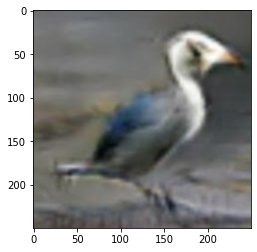

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/content/results2/gen_190_0.png')
imgplot = plt.imshow(img)
plt.show()

# Stage 2

In [ ]:
import os
import pickle
import random
import time

import PIL
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from keras import Input, Model
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.layers import Dense, LeakyReLU, BatchNormalization, ReLU, Reshape, UpSampling2D, Conv2D, Activation, \
    concatenate, Flatten, Lambda, Concatenate, ZeroPadding2D
from keras.layers import add
from keras.optimizers import Adam
from matplotlib import pyplot as plt

def build_ca_model():
    """
    Get conditioning augmentation model.
    Takes an embedding of shape (1024,) and returns a tensor of shape (256,)
    """
    input_layer = Input(shape=(1024,))
    x = Dense(256)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)
    model = Model(inputs=[input_layer], outputs=[x])
    return model

def build_embedding_compressor_model():
    """
    Build embedding compressor model
    """
    input_layer = Input(shape=(1024,))
    x = Dense(128)(input_layer)
    x = ReLU()(x)
    model = Model(inputs=[input_layer], outputs=[x])
    return model
  
def generate_c(x):
    mean = x[:, :128]
    log_sigma = x[:, 128:]

    stddev = K.exp(log_sigma)
    epsilon = K.random_normal(shape=K.constant((mean.shape[1],), dtype='int32'))
    c = stddev * epsilon + mean

    return c

def build_stage1_generator():
    """
    Builds a generator model used in Stage-I
    """
    input_layer = Input(shape=(1024,))
    x = Dense(256)(input_layer)
    mean_logsigma = LeakyReLU(alpha=0.2)(x)

    c = Lambda(generate_c)(mean_logsigma)

    input_layer2 = Input(shape=(100,))

    gen_input = Concatenate(axis=1)([c, input_layer2])

    x = Dense(128 * 8 * 4 * 4, use_bias=False)(gen_input)
    x = ReLU()(x)

    x = Reshape((4, 4, 128 * 8), input_shape=(128 * 8 * 4 * 4,))(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(512, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(3, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = Activation(activation='tanh')(x)

    stage1_gen = Model(inputs=[input_layer, input_layer2], outputs=[x, mean_logsigma])
    return stage1_gen
  
def residual_block(input):
    """
    Residual block in the generator network
    """
    x = Conv2D(128 * 4, kernel_size=(3, 3), padding='same', strides=1)(input)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(128 * 4, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    x = add([x, input])
    x = ReLU()(x)

    return x
  
def joint_block(inputs):
    c = inputs[0]
    x = inputs[1]

    c = K.expand_dims(c, axis=1)
    c = K.expand_dims(c, axis=1)
    c = K.tile(c, [1, 16, 16, 1])
    return K.concatenate([c, x], axis=3)
  
def build_stage2_generator():
    """
    Create Stage-II generator containing the CA Augmentation Network,
    the image encoder and the generator network
    """

    # 1. CA Augmentation Network
    input_layer = Input(shape=(1024,))
    input_lr_images = Input(shape=(64, 64, 3))

    ca = Dense(256)(input_layer)
    mean_logsigma = LeakyReLU(alpha=0.2)(ca)
    c = Lambda(generate_c)(mean_logsigma)

    # 2. Image Encoder
    x = ZeroPadding2D(padding=(1, 1))(input_lr_images)
    x = Conv2D(128, kernel_size=(3, 3), strides=1, use_bias=False)(x)
    x = ReLU()(x)

    x = ZeroPadding2D(padding=(1, 1))(x)
    x = Conv2D(256, kernel_size=(4, 4), strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = ZeroPadding2D(padding=(1, 1))(x)
    x = Conv2D(512, kernel_size=(4, 4), strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # 3. Joint
    c_code = Lambda(joint_block)([c, x])

    x = ZeroPadding2D(padding=(1, 1))(c_code)
    x = Conv2D(512, kernel_size=(3, 3), strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # 4. Residual blocks
    x = residual_block(x)
    x = residual_block(x)
    x = residual_block(x)
    x = residual_block(x)

    # 5. Upsampling blocks
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(512, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(3, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = Activation('tanh')(x)

    model = Model(inputs=[input_layer, input_lr_images], outputs=[x, mean_logsigma])
    return model
  
def build_stage2_discriminator():
    """
    Create Stage-II discriminator network
    """
    input_layer = Input(shape=(256, 256, 3))

    x = Conv2D(64, (4, 4), padding='same', strides=2, input_shape=(256, 256, 3), use_bias=False)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(1024, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(2048, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(1024, (1, 1), padding='same', strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, (1, 1), padding='same', strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)

    x2 = Conv2D(128, (1, 1), padding='same', strides=1, use_bias=False)(x)
    x2 = BatchNormalization()(x2)
    x2 = LeakyReLU(alpha=0.2)(x2)

    x2 = Conv2D(128, (3, 3), padding='same', strides=1, use_bias=False)(x2)
    x2 = BatchNormalization()(x2)
    x2 = LeakyReLU(alpha=0.2)(x2)

    x2 = Conv2D(512, (3, 3), padding='same', strides=1, use_bias=False)(x2)
    x2 = BatchNormalization()(x2)

    added_x = add([x, x2])
    added_x = LeakyReLU(alpha=0.2)(added_x)

    input_layer2 = Input(shape=(4, 4, 128))

    merged_input = concatenate([added_x, input_layer2])

    x3 = Conv2D(64 * 8, kernel_size=1, padding="same", strides=1)(merged_input)
    x3 = BatchNormalization()(x3)
    x3 = LeakyReLU(alpha=0.2)(x3)
    x3 = Flatten()(x3)
    x3 = Dense(1)(x3)
    x3 = Activation('sigmoid')(x3)

    stage2_dis = Model(inputs=[input_layer, input_layer2], outputs=[x3])
    return stage2_dis
  
def build_adversarial_model(gen_model2, dis_model, gen_model1):
    """
    Create adversarial model
    """
    embeddings_input_layer = Input(shape=(1024, ))
    noise_input_layer = Input(shape=(100, ))
    compressed_embedding_input_layer = Input(shape=(4, 4, 128))

    gen_model1.trainable = False
    dis_model.trainable = False

    lr_images, mean_logsigma1 = gen_model1([embeddings_input_layer, noise_input_layer])
    hr_images, mean_logsigma2 = gen_model2([embeddings_input_layer, lr_images])
    valid = dis_model([hr_images, compressed_embedding_input_layer])

    model = Model(inputs=[embeddings_input_layer, noise_input_layer, compressed_embedding_input_layer], outputs=[valid, mean_logsigma2])
    return model

  
"""
Dataset loading related methods
"""


def load_class_ids(class_info_file_path):
    """
    Load class ids from class_info.pickle file
    """
    with open(class_info_file_path, 'rb') as f:
        class_ids = pickle.load(f, encoding='latin1')
        return class_ids


def load_embeddings(embeddings_file_path):
    """
    Function to load embeddings
    """
    with open(embeddings_file_path, 'rb') as f:
        embeddings = pickle.load(f, encoding='latin1')
        embeddings = np.array(embeddings)
        print('embeddings: ', embeddings.shape)
    return embeddings


def load_filenames(filenames_file_path):
    """
    Load filenames.pickle file and return a list of all file names
    """
    with open(filenames_file_path, 'rb') as f:
        filenames = pickle.load(f, encoding='latin1')
    return filenames


def load_bounding_boxes(dataset_dir):
    """
    Load bounding boxes and return a dictionary of file names and corresponding bounding boxes
    """
    # Paths
    bounding_boxes_path = os.path.join(dataset_dir, 'bounding_boxes.txt')
    file_paths_path = os.path.join(dataset_dir, 'images.txt')

    # Read bounding_boxes.txt and images.txt file
    df_bounding_boxes = pd.read_csv(bounding_boxes_path,
                                    delim_whitespace=True, header=None).astype(int)
    df_file_names = pd.read_csv(file_paths_path, delim_whitespace=True, header=None)

    # Create a list of file names
    file_names = df_file_names[1].tolist()

    # Create a dictionary of file_names and bounding boxes
    filename_boundingbox_dict = {img_file[:-4]: [] for img_file in file_names[:2]}

    # Assign a bounding box to the corresponding image
    for i in range(0, len(file_names)):
        # Get the bounding box
        bounding_box = df_bounding_boxes.iloc[i][1:].tolist()
        key = file_names[i][:-4]
        filename_boundingbox_dict[key] = bounding_box

    return filename_boundingbox_dict


def get_img(img_path, bbox, image_size):
    """
    Load and resize images
    """
    img = Image.open(img_path).convert('RGB')
    width, height = img.size
    if bbox is not None:
        R = int(np.maximum(bbox[2], bbox[3]) * 0.75)
        center_x = int((2 * bbox[0] + bbox[2]) / 2)
        center_y = int((2 * bbox[1] + bbox[3]) / 2)
        y1 = np.maximum(0, center_y - R)
        y2 = np.minimum(height, center_y + R)
        x1 = np.maximum(0, center_x - R)
        x2 = np.minimum(width, center_x + R)
        img = img.crop([x1, y1, x2, y2])
    img = img.resize(image_size, PIL.Image.BILINEAR)
    return img


def load_dataset(filenames_file_path, class_info_file_path, cub_dataset_dir, embeddings_file_path, image_size):
    filenames = load_filenames(filenames_file_path)
    class_ids = load_class_ids(class_info_file_path)
    bounding_boxes = load_bounding_boxes(cub_dataset_dir)
    all_embeddings = load_embeddings(embeddings_file_path)

    X, y, embeddings = [], [], []

    print("All embeddings shape:", all_embeddings.shape)

    for index, filename in enumerate(filenames):
        bounding_box = bounding_boxes[filename]

        try:
            # Load images
            img_name = '{}/images/{}.jpg'.format(cub_dataset_dir, filename)
            img = get_img(img_name, bounding_box, image_size)

            all_embeddings1 = all_embeddings[index, :, :]

            embedding_ix = random.randint(0, all_embeddings1.shape[0] - 1)
            embedding = all_embeddings1[embedding_ix, :]

            X.append(np.array(img))
            y.append(class_ids[index])
            embeddings.append(embedding)
        except Exception as e:
            print(e)

    X = np.array(X)
    y = np.array(y)
    embeddings = np.array(embeddings)

    return X, y, embeddings

"""
Loss functions
"""


def KL_loss(y_true, y_pred):
    mean = y_pred[:, :128]
    logsigma = y_pred[:, :128]
    loss = -logsigma + .5 * (-1 + K.exp(2. * logsigma) + K.square(mean))
    loss = K.mean(loss)
    return loss


def custom_generator_loss(y_true, y_pred):
    # Calculate binary cross entropy loss
    return K.binary_crossentropy(y_true, y_pred)


def write_log(callback, name, loss, batch_no):
    """
    Write training summary to TensorBoard
    """
    summary = tf.Summary()
    summary_value = summary.value.add()
    summary_value.simple_value = loss
    summary_value.tag = name
    callback.writer.add_summary(summary, batch_no)
    callback.writer.flush()


def save_rgb_img(img, path):
    """
    Save an rgb image
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Image")

    plt.savefig(path)
    plt.close()

In [ ]:
if __name__ == '__main__':
    data_dir = "/content/birds/"
    train_dir = data_dir + "/train"
    test_dir = data_dir + "/test"
    hr_image_size = (256, 256)
    lr_image_size = (64, 64)
    batch_size = 32
    z_dim = 100
    stage1_generator_lr = 0.0002
    stage1_discriminator_lr = 0.0002
    stage1_lr_decay_step = 600
    epochs = 2
    condition_dim = 128

    embeddings_file_path_train = train_dir + "/char-CNN-RNN-embeddings.pickle"
    embeddings_file_path_test = test_dir + "/char-CNN-RNN-embeddings.pickle"

    filenames_file_path_train = train_dir + "/filenames.pickle"
    filenames_file_path_test = test_dir + "/filenames.pickle"

    class_info_file_path_train = train_dir + "/class_info.pickle"
    class_info_file_path_test = test_dir + "/class_info.pickle"

    cub_dataset_dir = "/content/CUB_200_2011"

    # Define optimizers
    dis_optimizer = Adam(lr=stage1_discriminator_lr, beta_1=0.5, beta_2=0.999)
    gen_optimizer = Adam(lr=stage1_generator_lr, beta_1=0.5, beta_2=0.999)

    """
    Load datasets
    """
    X_hr_train, y_hr_train, embeddings_train = load_dataset(filenames_file_path=filenames_file_path_train,
                                                            class_info_file_path=class_info_file_path_train,
                                                            cub_dataset_dir=cub_dataset_dir,
                                                            embeddings_file_path=embeddings_file_path_train,
                                                            image_size=(256, 256))

    X_hr_test, y_hr_test, embeddings_test = load_dataset(filenames_file_path=filenames_file_path_test,
                                                         class_info_file_path=class_info_file_path_test,
                                                         cub_dataset_dir=cub_dataset_dir,
                                                         embeddings_file_path=embeddings_file_path_test,
                                                         image_size=(256, 256))

    X_lr_train, y_lr_train, _ = load_dataset(filenames_file_path=filenames_file_path_train,
                                             class_info_file_path=class_info_file_path_train,
                                             cub_dataset_dir=cub_dataset_dir,
                                             embeddings_file_path=embeddings_file_path_train,
                                             image_size=(64, 64))

    X_lr_test, y_lr_test, _ = load_dataset(filenames_file_path=filenames_file_path_test,
                                           class_info_file_path=class_info_file_path_test,
                                           cub_dataset_dir=cub_dataset_dir,
                                           embeddings_file_path=embeddings_file_path_test,
                                           image_size=(64, 64))

    """
    Build and compile models
    """
    stage2_dis = build_stage2_discriminator()
    stage2_dis.compile(loss='binary_crossentropy', optimizer=dis_optimizer)

    stage1_gen = build_stage1_generator()
    stage1_gen.compile(loss="binary_crossentropy", optimizer=gen_optimizer)

    stage1_gen.load_weights("stage1_gen.h5")

    stage2_gen = build_stage2_generator()
    stage2_gen.compile(loss="binary_crossentropy", optimizer=gen_optimizer)

    embedding_compressor_model = build_embedding_compressor_model()
    embedding_compressor_model.compile(loss='binary_crossentropy', optimizer='adam')

    adversarial_model = build_adversarial_model(stage2_gen, stage2_dis, stage1_gen)
    adversarial_model.compile(loss=['binary_crossentropy', KL_loss], loss_weights=[1.0, 2.0],
                              optimizer=gen_optimizer, metrics=None)

    tensorboard = TensorBoard(log_dir="logs/".format(time.time()))
    tensorboard.set_model(stage2_gen)
    tensorboard.set_model(stage2_dis)

    # Generate an array containing real and fake values
    # Apply label smoothing
    real_labels = np.ones((batch_size, 1), dtype=float) * 0.9
    fake_labels = np.zeros((batch_size, 1), dtype=float) * 0.1

    for epoch in range(epochs):
        print("========================================")
        print("Epoch is:", epoch)

        gen_losses = []
        dis_losses = []

        # Load data and train model
        number_of_batches = int(X_hr_train.shape[0] / batch_size)
        print("Number of batches:{}".format(number_of_batches))
        for index in range(number_of_batches):
            print("Batch:{}".format(index+1))

            # Create a noise vector
            z_noise = np.random.normal(0, 1, size=(batch_size, z_dim))
            X_hr_train_batch = X_hr_train[index * batch_size:(index + 1) * batch_size]
            embedding_batch = embeddings_train[index * batch_size:(index + 1) * batch_size]
            X_hr_train_batch = (X_hr_train_batch - 127.5) / 127.5

            # Generate fake images
            lr_fake_images, _ = stage1_gen.predict([embedding_batch, z_noise], verbose=3)
            hr_fake_images, _ = stage2_gen.predict([embedding_batch, lr_fake_images], verbose=3)

            """
            4. Generate compressed embeddings
            """
            compressed_embedding = embedding_compressor_model.predict_on_batch(embedding_batch)
            compressed_embedding = np.reshape(compressed_embedding, (-1, 1, 1, condition_dim))
            compressed_embedding = np.tile(compressed_embedding, (1, 4, 4, 1))

            """
            5. Train the discriminator model
            """
            dis_loss_real = stage2_dis.train_on_batch([X_hr_train_batch, compressed_embedding],
                                                      np.reshape(real_labels, (batch_size, 1)))
            dis_loss_fake = stage2_dis.train_on_batch([hr_fake_images, compressed_embedding],
                                                      np.reshape(fake_labels, (batch_size, 1)))
            dis_loss_wrong = stage2_dis.train_on_batch([X_hr_train_batch[:(batch_size - 1)], compressed_embedding[1:]],
                                                       np.reshape(fake_labels[1:], (batch_size-1, 1)))
            d_loss = 0.5 * np.add(dis_loss_real, 0.5 * np.add(dis_loss_wrong,  dis_loss_fake))
            print("d_loss:{}".format(d_loss))

            """
            Train the adversarial model
            """
            g_loss = adversarial_model.train_on_batch([embedding_batch, z_noise, compressed_embedding],
                                                                [K.ones((batch_size, 1)) * 0.9, K.ones((batch_size, 256)) * 0.9])

            print("g_loss:{}".format(g_loss))

            dis_losses.append(d_loss)
            gen_losses.append(g_loss)

        """
        Save losses to Tensorboard after each epoch
        """
        # write_log(tensorboard, 'discriminator_loss', np.mean(dis_losses), epoch)
        # write_log(tensorboard, 'generator_loss', np.mean(gen_losses)[0], epoch)

        # Generate and save images after every 2nd epoch
        if epoch % 2 == 0:
            # z_noise2 = np.random.uniform(-1, 1, size=(batch_size, z_dim))
            z_noise2 = np.random.normal(0, 1, size=(batch_size, z_dim))
            embedding_batch = embeddings_test[0:batch_size]

            lr_fake_images, _ = stage1_gen.predict([embedding_batch, z_noise2], verbose=3)
            hr_fake_images, _ = stage2_gen.predict([embedding_batch, lr_fake_images], verbose=3)

            # Save images
            for i, img in enumerate(hr_fake_images[:10]):
                save_rgb_img(img, "results3/gen_{}_{}.png".format(epoch, i))

    # Saving the models
    stage2_gen.save_weights("stage2_gen.h5")
    stage2_dis.save_weights("stage2_dis.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


embeddings:  (8855, 10, 1024)
All embeddings shape: (8855, 10, 1024)
embeddings:  (2933, 10, 1024)
All embeddings shape: (2933, 10, 1024)
embeddings:  (8855, 10, 1024)
All embeddings shape: (8855, 10, 1024)
embeddings:  (2933, 10, 1024)
All embeddings shape: (2933, 10, 1024)


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch is: 0
Number of batches:276
Batch:1
d_loss:5.5022135972976685
g_loss:[0.7524586915969849, 0.7115340232849121, 0.02046232484281063]
Batch:2
d_loss:1.7732253670692444
g_loss:[0.7680233716964722, 0.7345836758613586, 0.016719834879040718]
Batch:3
d_loss:2.4335855580866337
g_loss:[0.6814221739768982, 0.6565432548522949, 0.012439453974366188]
Batch:4
d_loss:1.4985709823668003
g_loss:[0.6366231441497803, 0.6052916049957275, 0.015665771439671516]
Batch:5
d_loss:1.3170484006404877
g_loss:[0.7701627612113953, 0.7370638847351074, 0.016549428924918175]
Batch:6
d_loss:1.7440567389130592
g_loss:[0.7779375910758972, 0.7423194646835327, 0.017809070646762848]
Batch:7
d_loss:1.7041959129273891
g_loss:[0.7002376914024353, 0.6736898422241211, 0.013273934833705425]
Batch:8
d_loss:1.8658316722139716
g_loss:[0.6823386549949646, 0.6523519158363342, 0.014993367716670036]
Batch:9
d_loss:0.88276859583857
g_loss:[0.6473233103752136, 0.6247941851615906, 0.011264555156230927]
Batch:10
d_loss:1.225430876038444

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch is: 1
Number of batches:276
Batch:1
d_loss:0.6209907092852518
g_loss:[0.6801699995994568, 0.6791211366653442, 0.0005244195926934481]
Batch:2
d_loss:0.5623062708764337
g_loss:[0.8428531289100647, 0.8418208360671997, 0.0005161534645594656]
Batch:3
d_loss:0.5836190576374065
g_loss:[0.6274400949478149, 0.6266273856163025, 0.00040636202902533114]
Batch:4
d_loss:0.5956557014142163
g_loss:[0.6964951753616333, 0.6955075263977051, 0.0004938258207403123]
Batch:5
d_loss:0.5925053157552611
g_loss:[0.7282188534736633, 0.7272627353668213, 0.00047805975191295147]
Batch:6
d_loss:0.6092800866390462
g_loss:[0.6649017333984375, 0.6640082001686096, 0.00044675220851786435]
Batch:7
d_loss:0.6368963474669727
g_loss:[0.6449930667877197, 0.6440402269363403, 0.00047643319703638554]
Batch:8
d_loss:0.5901120947673917
g_loss:[0.6478269696235657, 0.6465087532997131, 0.0006591195124201477]
Batch:9
d_loss:0.5917361203755718
g_loss:[0.7169877886772156, 0.7159827351570129, 0.000502522976603359]
Batch:10
d_loss:0.

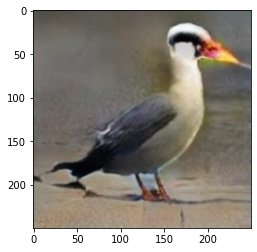

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/content/results3/gen_190_0.png')
imgplot = plt.imshow(img)
plt.show()